<h1><b>Importing Libraries</b></h1>

In [1]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

In [ ]:
import numpy as np
import pandas as pd
import random
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from collections import Counter
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix, accuracy_score
#from imblearn.metrics import geometric_mean_score
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
from torchvision import datasets

<h1><b>Datset Loading</b></h1>

In [ ]:
dataset_path = '/kaggle/input/50-skin-disease/Best_50_class'

In [ ]:
dataset = datasets.ImageFolder(root= dataset_path)
class_names = dataset.classes
print(class_names)

In [ ]:
# dataset.targets has numeric labels for each image
counts = Counter(dataset.targets)

# Map counts to class names
for class_idx, count in counts.items():
    print(f"{dataset.classes[class_idx]}: {count} images")

In [ ]:
df_counts = pd.DataFrame({
    "Class": [dataset.classes[idx] for idx in counts.keys()],
    "Count": [counts[idx] for idx in counts.keys()]
})

# Save to CSV
df_counts.to_csv("class_counts.csv", index=False)

print("Counts saved to class_counts.csv")

<h1><b>Vision Transformer (ViT)-Tensforflow</b></h1>

<h2><b>Dataset Splitting</b></h2>

In [ ]:
import tensorflow as tf

data_dir = dataset_path
img_size = (224, 224)
batch_size = 32

# =========================
# Step 1: 70% training set
# =========================
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.30,   # leave 30% for val+test
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# =========================
# Step 2: 30% val+test pool
# =========================
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.30,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# =========================
# Step 3: Split val_test_ds into 15% val + 15% test
# =========================
val_test_size = val_test_ds.cardinality().numpy()
val_size = val_test_size // 2
test_size = val_test_size - val_size  # handles odd numbers safely

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
batch_size = 32  # Use the same batch size you set

def dataset_size(dataset):
    # Get number of batches
    batches = dataset.cardinality().numpy()
    if batches == tf.data.INFINITE_CARDINALITY or batches == tf.data.UNKNOWN_CARDINALITY:
        return "Unknown size"
    else:
        return batches * batch_size

print("Train set size:", dataset_size(train_ds))
print("Validation set size:", dataset_size(val_ds))
print("Test set size:", dataset_size(test_ds))

<h2><b>Model Compilation</b></h2>

In [ ]:
!pip install vit-keras

In [ ]:
from vit_keras import vit
from tensorflow.keras import layers, models, optimizers

# =========================
# Configuration
# =========================
num_classes = len(class_names)
image_size = 224  # ViT was pretrained on 224x224
learning_rate = 1e-4

# =========================
# Backbone (ViT)
# =========================
# vit-keras does not allow include_top=False with pretrained=True
# Instead, load with pretrained weights, then remove the head manually.
vit_base = vit.vit_b16(
    image_size=image_size,
    pretrained=True,
    include_top=True,     # must be True if pretrained=True
    pretrained_top=True   # load the pretrained head
)

# Remove the classification head (last layer)
vit_base = models.Model(
    inputs=vit_base.input,
    outputs=vit_base.layers[-2].output   # take features before final Dense
)

# Freeze the backbone
vit_base.trainable = False

# =========================
# Custom classification head
# =========================
x = vit_base.output
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs=vit_base.input, outputs=output)

# =========================
# Compile
# =========================
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
model.summary()

In [ ]:
#sections to modify
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor
    patience=5,              # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore model weights from the epoch with best val_loss
)

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model_vit.h5',        # File path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only when improvement
    verbose=1
)

<h2><b>Model Training</b></h2>

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, checkpoint]   # Include both callbacks here
)


<h2><b>Results</b></h2>

In [ ]:
hist_training_vit=pd.DataFrame(history.history)
hist_training_vit
# Save to CSV
hist_training_vit.to_csv("hist_training_vit.csv", index=False)
print("ViT Training history to hist_training_vit.csv")

In [ ]:
#sections to modify
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

num_epochs = len(history.history['accuracy'])  # total epochs trained

# X ticks positions (integers from 0 to num_epochs, step 4)
xticks = range(0, num_epochs + 1, 4)

# Plot accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch', fontsize=20)
axs[0].set_ylabel('Accuracy', fontsize=20)
axs[0].set_title('Training and Validation Accuracy - ViT', fontsize=22)
axs[0].legend(fontsize=18)
axs[0].set_xticks(xticks)
axs[0].tick_params(axis='x', labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].grid(True)

# Plot loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch', fontsize=20)
axs[1].set_ylabel('Loss', fontsize=20)
axs[1].set_title('Training and Validation Loss - ViT', fontsize=22)
axs[1].legend(fontsize=18)
axs[1].set_xticks(xticks)
axs[1].tick_params(axis='x', labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].grid(True)

plt.tight_layout()

# Save the combined figure
plt.savefig('vit_training_curves.png', dpi=600)
plt.savefig('vit_training_curves.pdf')

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

# 1. Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute confusion matrix and metrics
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

# 3. Plot confusion matrix
plt.figure(figsize=(30, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels= class_names, yticklabels= class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('vit_confusion_matrix.png', dpi=600)
plt.savefig('vit_confusion_matrix.pdf')
plt.show()

# 4. Save metrics to CSV
metrics = {
    'Accuracy': [accuracy],
    'Recall': [recall],
    'Precision': [precision],
    'F1 Score': [f1],
    'MCC':[mcc]
}
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm.to_csv("confusion_vit.csv")

df_metrics_vit = pd.DataFrame(metrics)
df_metrics_vit.to_csv('performance_metrics_vit.csv', index=False)

<h1><b>Swin Transformer</b></h1>

<h2><b>Importing Librarires</b></h2>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef
import copy
import os

<h2><b>Dataset Loading</b></h2>

In [18]:
data_dir = "/kaggle/input/50-skin-disease/Best_50_class"   # dataset root folder (class subfolders inside)
img_size = 224            # Swin expects 224x224
batch_size = 32
epochs = 2
learning_rate = 1e-4
seed = 123
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms   # ✅ this line

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet normalization
        std=[0.229, 0.224, 0.225]
    )
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(full_dataset.classes)

<h2><b>Dataset Splitting</b></h2>

In [20]:
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)
test_size  = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 12397 | Val: 2656 | Test: 2658


In [21]:
# full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# save class names once
class_names = full_dataset.classes   # ✅ store here

<h2>Model Compiling</h2>

In [ ]:
from torchvision import models

model = models.swin_t(weights="IMAGENET1K_V1")  # Swin Tiny pretrained
model.head = nn.Linear(model.head.in_features, num_classes)  # replace classifier
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

<h2><b>Model Training</b></h2>

In [ ]:
# =========================
# Early Stopping + Checkpoint
# =========================
best_val_loss = float("inf")
best_model_wts = copy.deepcopy(model.state_dict())
patience = 1
counter = 0
checkpoint_path = "best_swin_model.pth"

num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---- Validation ----
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # ---- Checkpoint + Early Stopping ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Best model updated & saved at epoch {epoch+1}")
        counter = 0
    else:
        counter += 1
        print(f"⚠️ No improvement for {counter} epochs")

        if counter >= patience:
            print("⏹️ Early stopping triggered")
            break

# Load best model weights
model.load_state_dict(best_model_wts)
print("✅ Loaded best model from training")

# =========================
# Save Training History
# =========================
history = {
    'loss': train_losses,
    'val_loss': val_losses,
    'accuracy': train_accuracies,
    'val_accuracy': val_accuracies
}
df_history = pd.DataFrame(history)
df_history.to_csv("swin_training_history.csv", index=False)
print("📁 Training history saved to swin_training_history.csv")

<h2><b>Results</b></h2>

In [ ]:
# =========================
# Plot Training Curves
# =========================
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
num_epochs_done = len(train_losses)
xticks = range(0, num_epochs_done + 1, 2)

# Accuracy
axs[0].plot(train_accuracies, label='Train Accuracy')
axs[0].plot(val_accuracies, label='Validation Accuracy')
axs[0].set_xlabel('Epoch', fontsize=20)
axs[0].set_ylabel('Accuracy (%)', fontsize=20)
axs[0].set_title('Training and Validation Accuracy - Swin', fontsize=22)
axs[0].legend(fontsize=18)
axs[0].set_xticks(xticks)
axs[0].grid(True)

# Loss
axs[1].plot(train_losses, label='Train Loss')
axs[1].plot(val_losses, label='Validation Loss')
axs[1].set_xlabel('Epoch', fontsize=20)
axs[1].set_ylabel('Loss', fontsize=20)
axs[1].set_title('Training and Validation Loss - Swin', fontsize=22)
axs[1].legend(fontsize=18)
axs[1].set_xticks(xticks)
axs[1].grid(True)

plt.tight_layout()
plt.savefig('swin_training_curves.png', dpi=600)
plt.savefig('swin_training_curves.pdf')
plt.show()

In [ ]:
# =========================
# Test Evaluation
# =========================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Performance Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
mcc = matthews_corrcoef(y_true, y_pred)

print("\n===== 📊 Test Performance =====")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")

# Save Performance Metrics
metrics_df = pd.DataFrame([{
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "MCC": mcc
}])
metrics_df.to_csv("swin_test_metrics.csv", index=False)
print("📁 Test metrics saved to swin_test_metrics.csv")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate on test set
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(30, 25))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('swin_confusion_matrix.png', dpi=600)
plt.savefig('swin_confusion_matrix.pdf')
plt.show()

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm.to_csv("confusion_swin.csv")

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


<h1><b>Vit-Pytorch</b></h2>

<h2><b>Importing Libraries</b></h2>

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

<h2><b>Model Compiling</b></h2>

In [29]:
# =========================
# Define ViT Model
# =========================
model = models.vit_b_16(weights="IMAGENET1K_V1")  # Pretrained ViT-Base, patch 16
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)  # Replace classification head
model = model.to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth



  0%|          | 0.00/330M [00:00<?, ?B/s]


  3%|▎         | 8.38M/330M [00:00<00:03, 87.6MB/s]


  9%|▉         | 30.1M/330M [00:00<00:01, 170MB/s] 


 16%|█▌        | 52.6M/330M [00:00<00:01, 200MB/s]


 23%|██▎       | 75.4M/330M [00:00<00:01, 215MB/s]


 30%|██▉       | 98.2M/330M [00:00<00:01, 224MB/s]


 37%|███▋      | 121M/330M [00:00<00:00, 228MB/s] 


 43%|████▎     | 144M/330M [00:00<00:00, 231MB/s]


 50%|█████     | 166M/330M [00:00<00:00, 233MB/s]


 57%|█████▋    | 189M/330M [00:00<00:00, 234MB/s]


 64%|██████▍   | 211M/330M [00:01<00:00, 234MB/s]


 71%|███████   | 234M/330M [00:01<00:00, 235MB/s]


 78%|███████▊  | 257M/330M [00:01<00:00, 236MB/s]


 85%|████████▍ | 279M/330M [00:01<00:00, 236MB/s]


 91%|█████████▏| 302M/330M [00:01<00:00, 237MB/s]


 98%|█████████▊| 325M/330M [00:01<00:00, 234MB/s]


100%|██████████| 330M/330M [00:01<00:00, 226MB/s]

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

<h2><b>Model Training</b></h2>

In [31]:
# =========================
# Early Stopping + Checkpoint (same as before)
# =========================
best_val_loss = float("inf")
best_model_wts = copy.deepcopy(model.state_dict())
patience = 5
counter = 0
checkpoint_path = "best_vit_model.pth"

num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---- Validation ----
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # ---- Checkpoint + Early Stopping ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Best model updated & saved at epoch {epoch+1}")
        counter = 0
    else:
        counter += 1
        print(f"⚠️ No improvement for {counter} epochs")
        if counter >= patience:
            print("⏹️ Early stopping triggered")
            break

# Load best model weights
model.load_state_dict(best_model_wts)
print("✅ Loaded best ViT model from training")
# =========================
# Save Training History
# =========================
history = {
    'loss': train_losses,
    'val_loss': val_losses,
    'accuracy': train_accuracies,
    'val_accuracy': val_accuracies
}
df_history = pd.DataFrame(history)
df_history.to_csv("vit_training_history.csv", index=False)
print("📁 Training history saved to vit_training_history.csv")



Epoch 1/50 - Training:   0%|          | 0/388 [00:00<?, ?it/s]


Epoch 1/50 - Training:   0%|          | 1/388 [00:03<22:18,  3.46s/it]


Epoch 1/50 - Training:   1%|          | 2/388 [00:04<12:46,  1.99s/it]


Epoch 1/50 - Training:   1%|          | 3/388 [00:05<09:43,  1.51s/it]


Epoch 1/50 - Training:   1%|          | 4/388 [00:06<08:17,  1.29s/it]


Epoch 1/50 - Training:   1%|▏         | 5/388 [00:07<07:28,  1.17s/it]


Epoch 1/50 - Training:   2%|▏         | 6/388 [00:08<06:59,  1.10s/it]


Epoch 1/50 - Training:   2%|▏         | 7/388 [00:09<06:41,  1.05s/it]


Epoch 1/50 - Training:   2%|▏         | 8/388 [00:10<06:28,  1.02s/it]


Epoch 1/50 - Training:   2%|▏         | 9/388 [00:11<06:20,  1.00s/it]


Epoch 1/50 - Training:   3%|▎         | 10/388 [00:12<06:13,  1.01it/s]


Epoch 1/50 - Training:   3%|▎         | 11/388 [00:13<06:10,  1.02it/s]


Epoch 1/50 - Training:   3%|▎         | 12/388 [00:14<06:07,  1.02it/s]


Epoch 1/50 - Training:   3%|▎         | 13/388 [00:14<06:05,  1.03it/s]


Epoch 1/50 - Training:   4%|▎         | 14/388 [00:15<06:03,  1.03it/s]


Epoch 1/50 - Training:   4%|▍         | 15/388 [00:16<06:01,  1.03it/s]


Epoch 1/50 - Training:   4%|▍         | 16/388 [00:17<06:00,  1.03it/s]


Epoch 1/50 - Training:   4%|▍         | 17/388 [00:18<05:59,  1.03it/s]


Epoch 1/50 - Training:   5%|▍         | 18/388 [00:19<05:58,  1.03it/s]


Epoch 1/50 - Training:   5%|▍         | 19/388 [00:20<05:57,  1.03it/s]


Epoch 1/50 - Training:   5%|▌         | 20/388 [00:21<05:56,  1.03it/s]


Epoch 1/50 - Training:   5%|▌         | 21/388 [00:22<05:56,  1.03it/s]


Epoch 1/50 - Training:   6%|▌         | 22/388 [00:23<05:55,  1.03it/s]


Epoch 1/50 - Training:   6%|▌         | 23/388 [00:24<05:55,  1.03it/s]


Epoch 1/50 - Training:   6%|▌         | 24/388 [00:25<05:53,  1.03it/s]


Epoch 1/50 - Training:   6%|▋         | 25/388 [00:26<05:53,  1.03it/s]


Epoch 1/50 - Training:   7%|▋         | 26/388 [00:27<05:52,  1.03it/s]


Epoch 1/50 - Training:   7%|▋         | 27/388 [00:28<05:52,  1.02it/s]


Epoch 1/50 - Training:   7%|▋         | 28/388 [00:29<05:52,  1.02it/s]


Epoch 1/50 - Training:   7%|▋         | 29/388 [00:30<05:51,  1.02it/s]


Epoch 1/50 - Training:   8%|▊         | 30/388 [00:31<05:51,  1.02it/s]


Epoch 1/50 - Training:   8%|▊         | 31/388 [00:32<05:50,  1.02it/s]


Epoch 1/50 - Training:   8%|▊         | 32/388 [00:33<05:50,  1.02it/s]


Epoch 1/50 - Training:   9%|▊         | 33/388 [00:34<05:49,  1.02it/s]


Epoch 1/50 - Training:   9%|▉         | 34/388 [00:35<05:48,  1.02it/s]


Epoch 1/50 - Training:   9%|▉         | 35/388 [00:36<05:47,  1.01it/s]


Epoch 1/50 - Training:   9%|▉         | 36/388 [00:37<05:47,  1.01it/s]


Epoch 1/50 - Training:  10%|▉         | 37/388 [00:38<05:47,  1.01it/s]


Epoch 1/50 - Training:  10%|▉         | 38/388 [00:39<05:46,  1.01it/s]


Epoch 1/50 - Training:  10%|█         | 39/388 [00:40<05:45,  1.01it/s]


Epoch 1/50 - Training:  10%|█         | 40/388 [00:41<05:45,  1.01it/s]


Epoch 1/50 - Training:  11%|█         | 41/388 [00:42<05:44,  1.01it/s]


Epoch 1/50 - Training:  11%|█         | 42/388 [00:43<05:43,  1.01it/s]


Epoch 1/50 - Training:  11%|█         | 43/388 [00:44<05:42,  1.01it/s]


Epoch 1/50 - Training:  11%|█▏        | 44/388 [00:45<05:42,  1.01it/s]


Epoch 1/50 - Training:  12%|█▏        | 45/388 [00:46<05:41,  1.00it/s]


Epoch 1/50 - Training:  12%|█▏        | 46/388 [00:47<05:40,  1.01it/s]


Epoch 1/50 - Training:  12%|█▏        | 47/388 [00:48<05:38,  1.01it/s]


Epoch 1/50 - Training:  12%|█▏        | 48/388 [00:49<05:37,  1.01it/s]


Epoch 1/50 - Training:  13%|█▎        | 49/388 [00:50<05:36,  1.01it/s]


Epoch 1/50 - Training:  13%|█▎        | 50/388 [00:51<05:36,  1.01it/s]


Epoch 1/50 - Training:  13%|█▎        | 51/388 [00:52<05:35,  1.00it/s]


Epoch 1/50 - Training:  13%|█▎        | 52/388 [00:53<05:34,  1.00it/s]


Epoch 1/50 - Training:  14%|█▎        | 53/388 [00:54<05:34,  1.00it/s]


Epoch 1/50 - Training:  14%|█▍        | 54/388 [00:55<05:34,  1.00s/it]


Epoch 1/50 - Training:  14%|█▍        | 55/388 [00:56<05:33,  1.00s/it]


Epoch 1/50 - Training:  14%|█▍        | 56/388 [00:57<05:32,  1.00s/it]


Epoch 1/50 - Training:  15%|█▍        | 57/388 [00:58<05:32,  1.00s/it]


Epoch 1/50 - Training:  15%|█▍        | 58/388 [00:59<05:31,  1.00s/it]


Epoch 1/50 - Training:  15%|█▌        | 59/388 [01:00<05:30,  1.00s/it]


Epoch 1/50 - Training:  15%|█▌        | 60/388 [01:01<05:29,  1.00s/it]


Epoch 1/50 - Training:  16%|█▌        | 61/388 [01:02<05:29,  1.01s/it]


Epoch 1/50 - Training:  16%|█▌        | 62/388 [01:03<05:28,  1.01s/it]


Epoch 1/50 - Training:  16%|█▌        | 63/388 [01:04<05:27,  1.01s/it]


Epoch 1/50 - Training:  16%|█▋        | 64/388 [01:05<05:26,  1.01s/it]


Epoch 1/50 - Training:  17%|█▋        | 65/388 [01:06<05:26,  1.01s/it]


Epoch 1/50 - Training:  17%|█▋        | 66/388 [01:07<05:25,  1.01s/it]


Epoch 1/50 - Training:  17%|█▋        | 67/388 [01:08<05:25,  1.01s/it]


Epoch 1/50 - Training:  18%|█▊        | 68/388 [01:09<05:24,  1.01s/it]


Epoch 1/50 - Training:  18%|█▊        | 69/388 [01:10<05:23,  1.01s/it]


Epoch 1/50 - Training:  18%|█▊        | 70/388 [01:11<05:23,  1.02s/it]


Epoch 1/50 - Training:  18%|█▊        | 71/388 [01:12<05:22,  1.02s/it]


Epoch 1/50 - Training:  19%|█▊        | 72/388 [01:13<05:21,  1.02s/it]


Epoch 1/50 - Training:  19%|█▉        | 73/388 [01:14<05:21,  1.02s/it]


Epoch 1/50 - Training:  19%|█▉        | 74/388 [01:15<05:20,  1.02s/it]


Epoch 1/50 - Training:  19%|█▉        | 75/388 [01:16<05:19,  1.02s/it]


Epoch 1/50 - Training:  20%|█▉        | 76/388 [01:17<05:18,  1.02s/it]


Epoch 1/50 - Training:  20%|█▉        | 77/388 [01:18<05:17,  1.02s/it]


Epoch 1/50 - Training:  20%|██        | 78/388 [01:19<05:16,  1.02s/it]


Epoch 1/50 - Training:  20%|██        | 79/388 [01:20<05:16,  1.02s/it]


Epoch 1/50 - Training:  21%|██        | 80/388 [01:21<05:15,  1.02s/it]


Epoch 1/50 - Training:  21%|██        | 81/388 [01:22<05:14,  1.02s/it]


Epoch 1/50 - Training:  21%|██        | 82/388 [01:23<05:13,  1.03s/it]


Epoch 1/50 - Training:  21%|██▏       | 83/388 [01:24<05:13,  1.03s/it]


Epoch 1/50 - Training:  22%|██▏       | 84/388 [01:25<05:12,  1.03s/it]


Epoch 1/50 - Training:  22%|██▏       | 85/388 [01:26<05:11,  1.03s/it]


Epoch 1/50 - Training:  22%|██▏       | 86/388 [01:27<05:11,  1.03s/it]


Epoch 1/50 - Training:  22%|██▏       | 87/388 [01:28<05:10,  1.03s/it]


Epoch 1/50 - Training:  23%|██▎       | 88/388 [01:30<05:09,  1.03s/it]


Epoch 1/50 - Training:  23%|██▎       | 89/388 [01:31<05:08,  1.03s/it]


Epoch 1/50 - Training:  23%|██▎       | 90/388 [01:32<05:07,  1.03s/it]


Epoch 1/50 - Training:  23%|██▎       | 91/388 [01:33<05:06,  1.03s/it]


Epoch 1/50 - Training:  24%|██▎       | 92/388 [01:34<05:06,  1.03s/it]


Epoch 1/50 - Training:  24%|██▍       | 93/388 [01:35<05:05,  1.04s/it]


Epoch 1/50 - Training:  24%|██▍       | 94/388 [01:36<05:04,  1.04s/it]


Epoch 1/50 - Training:  24%|██▍       | 95/388 [01:37<05:03,  1.04s/it]


Epoch 1/50 - Training:  25%|██▍       | 96/388 [01:38<05:03,  1.04s/it]


Epoch 1/50 - Training:  25%|██▌       | 97/388 [01:39<05:02,  1.04s/it]


Epoch 1/50 - Training:  25%|██▌       | 98/388 [01:40<05:01,  1.04s/it]


Epoch 1/50 - Training:  26%|██▌       | 99/388 [01:41<05:00,  1.04s/it]


Epoch 1/50 - Training:  26%|██▌       | 100/388 [01:42<05:00,  1.04s/it]


Epoch 1/50 - Training:  26%|██▌       | 101/388 [01:43<04:59,  1.04s/it]


Epoch 1/50 - Training:  26%|██▋       | 102/388 [01:44<04:58,  1.04s/it]


Epoch 1/50 - Training:  27%|██▋       | 103/388 [01:45<04:57,  1.04s/it]


Epoch 1/50 - Training:  27%|██▋       | 104/388 [01:46<04:57,  1.05s/it]


Epoch 1/50 - Training:  27%|██▋       | 105/388 [01:47<04:56,  1.05s/it]


Epoch 1/50 - Training:  27%|██▋       | 106/388 [01:48<04:55,  1.05s/it]


Epoch 1/50 - Training:  28%|██▊       | 107/388 [01:49<04:54,  1.05s/it]


Epoch 1/50 - Training:  28%|██▊       | 108/388 [01:50<04:53,  1.05s/it]


Epoch 1/50 - Training:  28%|██▊       | 109/388 [01:51<04:52,  1.05s/it]


Epoch 1/50 - Training:  28%|██▊       | 110/388 [01:52<04:50,  1.05s/it]


Epoch 1/50 - Training:  29%|██▊       | 111/388 [01:53<04:49,  1.05s/it]


Epoch 1/50 - Training:  29%|██▉       | 112/388 [01:55<04:49,  1.05s/it]


Epoch 1/50 - Training:  29%|██▉       | 113/388 [01:56<04:48,  1.05s/it]


Epoch 1/50 - Training:  29%|██▉       | 114/388 [01:57<04:47,  1.05s/it]


Epoch 1/50 - Training:  30%|██▉       | 115/388 [01:58<04:46,  1.05s/it]


Epoch 1/50 - Training:  30%|██▉       | 116/388 [01:59<04:45,  1.05s/it]


Epoch 1/50 - Training:  30%|███       | 117/388 [02:00<04:44,  1.05s/it]


Epoch 1/50 - Training:  30%|███       | 118/388 [02:01<04:43,  1.05s/it]


Epoch 1/50 - Training:  31%|███       | 119/388 [02:02<04:42,  1.05s/it]


Epoch 1/50 - Training:  31%|███       | 120/388 [02:03<04:42,  1.05s/it]


Epoch 1/50 - Training:  31%|███       | 121/388 [02:04<04:41,  1.05s/it]


Epoch 1/50 - Training:  31%|███▏      | 122/388 [02:05<04:40,  1.05s/it]


Epoch 1/50 - Training:  32%|███▏      | 123/388 [02:06<04:39,  1.05s/it]


Epoch 1/50 - Training:  32%|███▏      | 124/388 [02:07<04:38,  1.05s/it]


Epoch 1/50 - Training:  32%|███▏      | 125/388 [02:08<04:37,  1.05s/it]


Epoch 1/50 - Training:  32%|███▏      | 126/388 [02:09<04:36,  1.06s/it]


Epoch 1/50 - Training:  33%|███▎      | 127/388 [02:10<04:35,  1.06s/it]


Epoch 1/50 - Training:  33%|███▎      | 128/388 [02:11<04:35,  1.06s/it]


Epoch 1/50 - Training:  33%|███▎      | 129/388 [02:12<04:34,  1.06s/it]


Epoch 1/50 - Training:  34%|███▎      | 130/388 [02:14<04:33,  1.06s/it]


Epoch 1/50 - Training:  34%|███▍      | 131/388 [02:15<04:32,  1.06s/it]


Epoch 1/50 - Training:  34%|███▍      | 132/388 [02:16<04:31,  1.06s/it]


Epoch 1/50 - Training:  34%|███▍      | 133/388 [02:17<04:30,  1.06s/it]


Epoch 1/50 - Training:  35%|███▍      | 134/388 [02:18<04:29,  1.06s/it]


Epoch 1/50 - Training:  35%|███▍      | 135/388 [02:19<04:28,  1.06s/it]


Epoch 1/50 - Training:  35%|███▌      | 136/388 [02:20<04:27,  1.06s/it]


Epoch 1/50 - Training:  35%|███▌      | 137/388 [02:21<04:26,  1.06s/it]


Epoch 1/50 - Training:  36%|███▌      | 138/388 [02:22<04:25,  1.06s/it]


Epoch 1/50 - Training:  36%|███▌      | 139/388 [02:23<04:25,  1.06s/it]


Epoch 1/50 - Training:  36%|███▌      | 140/388 [02:24<04:24,  1.07s/it]


Epoch 1/50 - Training:  36%|███▋      | 141/388 [02:25<04:23,  1.07s/it]


Epoch 1/50 - Training:  37%|███▋      | 142/388 [02:26<04:22,  1.07s/it]


Epoch 1/50 - Training:  37%|███▋      | 143/388 [02:27<04:21,  1.07s/it]


Epoch 1/50 - Training:  37%|███▋      | 144/388 [02:28<04:20,  1.07s/it]


Epoch 1/50 - Training:  37%|███▋      | 145/388 [02:30<04:19,  1.07s/it]


Epoch 1/50 - Training:  38%|███▊      | 146/388 [02:31<04:18,  1.07s/it]


Epoch 1/50 - Training:  38%|███▊      | 147/388 [02:32<04:18,  1.07s/it]


Epoch 1/50 - Training:  38%|███▊      | 148/388 [02:33<04:17,  1.07s/it]


Epoch 1/50 - Training:  38%|███▊      | 149/388 [02:34<04:16,  1.07s/it]


Epoch 1/50 - Training:  39%|███▊      | 150/388 [02:35<04:15,  1.07s/it]


Epoch 1/50 - Training:  39%|███▉      | 151/388 [02:36<04:14,  1.07s/it]


Epoch 1/50 - Training:  39%|███▉      | 152/388 [02:37<04:13,  1.07s/it]


Epoch 1/50 - Training:  39%|███▉      | 153/388 [02:38<04:12,  1.08s/it]


Epoch 1/50 - Training:  40%|███▉      | 154/388 [02:39<04:12,  1.08s/it]


Epoch 1/50 - Training:  40%|███▉      | 155/388 [02:40<04:10,  1.08s/it]


Epoch 1/50 - Training:  40%|████      | 156/388 [02:41<04:10,  1.08s/it]


Epoch 1/50 - Training:  40%|████      | 157/388 [02:42<04:09,  1.08s/it]


Epoch 1/50 - Training:  41%|████      | 158/388 [02:44<04:08,  1.08s/it]


Epoch 1/50 - Training:  41%|████      | 159/388 [02:45<04:07,  1.08s/it]


Epoch 1/50 - Training:  41%|████      | 160/388 [02:46<04:06,  1.08s/it]


Epoch 1/50 - Training:  41%|████▏     | 161/388 [02:47<04:05,  1.08s/it]


Epoch 1/50 - Training:  42%|████▏     | 162/388 [02:48<04:04,  1.08s/it]


Epoch 1/50 - Training:  42%|████▏     | 163/388 [02:49<04:03,  1.08s/it]


Epoch 1/50 - Training:  42%|████▏     | 164/388 [02:50<04:02,  1.08s/it]


Epoch 1/50 - Training:  43%|████▎     | 165/388 [02:51<04:01,  1.08s/it]


Epoch 1/50 - Training:  43%|████▎     | 166/388 [02:52<04:00,  1.08s/it]


Epoch 1/50 - Training:  43%|████▎     | 167/388 [02:53<03:58,  1.08s/it]


Epoch 1/50 - Training:  43%|████▎     | 168/388 [02:54<03:56,  1.08s/it]


Epoch 1/50 - Training:  44%|████▎     | 169/388 [02:55<03:56,  1.08s/it]


Epoch 1/50 - Training:  44%|████▍     | 170/388 [02:56<03:54,  1.08s/it]


Epoch 1/50 - Training:  44%|████▍     | 171/388 [02:58<03:53,  1.08s/it]


Epoch 1/50 - Training:  44%|████▍     | 172/388 [02:59<03:52,  1.08s/it]


Epoch 1/50 - Training:  45%|████▍     | 173/388 [03:00<03:51,  1.08s/it]


Epoch 1/50 - Training:  45%|████▍     | 174/388 [03:01<03:50,  1.08s/it]


Epoch 1/50 - Training:  45%|████▌     | 175/388 [03:02<03:49,  1.08s/it]


Epoch 1/50 - Training:  45%|████▌     | 176/388 [03:03<03:48,  1.08s/it]


Epoch 1/50 - Training:  46%|████▌     | 177/388 [03:04<03:47,  1.08s/it]


Epoch 1/50 - Training:  46%|████▌     | 178/388 [03:05<03:47,  1.08s/it]


Epoch 1/50 - Training:  46%|████▌     | 179/388 [03:06<03:45,  1.08s/it]


Epoch 1/50 - Training:  46%|████▋     | 180/388 [03:07<03:45,  1.08s/it]


Epoch 1/50 - Training:  47%|████▋     | 181/388 [03:08<03:44,  1.08s/it]


Epoch 1/50 - Training:  47%|████▋     | 182/388 [03:09<03:43,  1.08s/it]


Epoch 1/50 - Training:  47%|████▋     | 183/388 [03:11<03:41,  1.08s/it]


Epoch 1/50 - Training:  47%|████▋     | 184/388 [03:12<03:41,  1.08s/it]


Epoch 1/50 - Training:  48%|████▊     | 185/388 [03:13<03:40,  1.08s/it]


Epoch 1/50 - Training:  48%|████▊     | 186/388 [03:14<03:38,  1.08s/it]


Epoch 1/50 - Training:  48%|████▊     | 187/388 [03:15<03:37,  1.08s/it]


Epoch 1/50 - Training:  48%|████▊     | 188/388 [03:16<03:37,  1.09s/it]


Epoch 1/50 - Training:  49%|████▊     | 189/388 [03:17<03:35,  1.08s/it]


Epoch 1/50 - Training:  49%|████▉     | 190/388 [03:18<03:35,  1.09s/it]


Epoch 1/50 - Training:  49%|████▉     | 191/388 [03:19<03:33,  1.09s/it]


Epoch 1/50 - Training:  49%|████▉     | 192/388 [03:20<03:33,  1.09s/it]


Epoch 1/50 - Training:  50%|████▉     | 193/388 [03:21<03:32,  1.09s/it]


Epoch 1/50 - Training:  50%|█████     | 194/388 [03:22<03:31,  1.09s/it]


Epoch 1/50 - Training:  50%|█████     | 195/388 [03:24<03:30,  1.09s/it]


Epoch 1/50 - Training:  51%|█████     | 196/388 [03:25<03:29,  1.09s/it]


Epoch 1/50 - Training:  51%|█████     | 197/388 [03:26<03:28,  1.09s/it]


Epoch 1/50 - Training:  51%|█████     | 198/388 [03:27<03:27,  1.09s/it]


Epoch 1/50 - Training:  51%|█████▏    | 199/388 [03:28<03:26,  1.09s/it]


Epoch 1/50 - Training:  52%|█████▏    | 200/388 [03:29<03:25,  1.09s/it]


Epoch 1/50 - Training:  52%|█████▏    | 201/388 [03:30<03:24,  1.09s/it]


Epoch 1/50 - Training:  52%|█████▏    | 202/388 [03:31<03:23,  1.09s/it]


Epoch 1/50 - Training:  52%|█████▏    | 203/388 [03:32<03:22,  1.09s/it]


Epoch 1/50 - Training:  53%|█████▎    | 204/388 [03:33<03:20,  1.09s/it]


Epoch 1/50 - Training:  53%|█████▎    | 205/388 [03:34<03:19,  1.09s/it]


Epoch 1/50 - Training:  53%|█████▎    | 206/388 [03:36<03:18,  1.09s/it]


Epoch 1/50 - Training:  53%|█████▎    | 207/388 [03:37<03:17,  1.09s/it]


Epoch 1/50 - Training:  54%|█████▎    | 208/388 [03:38<03:16,  1.09s/it]


Epoch 1/50 - Training:  54%|█████▍    | 209/388 [03:39<03:15,  1.09s/it]


Epoch 1/50 - Training:  54%|█████▍    | 210/388 [03:40<03:14,  1.09s/it]


Epoch 1/50 - Training:  54%|█████▍    | 211/388 [03:41<03:13,  1.09s/it]


Epoch 1/50 - Training:  55%|█████▍    | 212/388 [03:42<03:12,  1.09s/it]


Epoch 1/50 - Training:  55%|█████▍    | 213/388 [03:43<03:11,  1.09s/it]


Epoch 1/50 - Training:  55%|█████▌    | 214/388 [03:44<03:10,  1.09s/it]


Epoch 1/50 - Training:  55%|█████▌    | 215/388 [03:45<03:09,  1.09s/it]


Epoch 1/50 - Training:  56%|█████▌    | 216/388 [03:47<03:07,  1.09s/it]


Epoch 1/50 - Training:  56%|█████▌    | 217/388 [03:48<03:06,  1.09s/it]


Epoch 1/50 - Training:  56%|█████▌    | 218/388 [03:49<03:05,  1.09s/it]


Epoch 1/50 - Training:  56%|█████▋    | 219/388 [03:50<03:04,  1.09s/it]


Epoch 1/50 - Training:  57%|█████▋    | 220/388 [03:51<03:03,  1.09s/it]


Epoch 1/50 - Training:  57%|█████▋    | 221/388 [03:52<03:02,  1.09s/it]


Epoch 1/50 - Training:  57%|█████▋    | 222/388 [03:53<03:01,  1.09s/it]


Epoch 1/50 - Training:  57%|█████▋    | 223/388 [03:54<03:00,  1.09s/it]


Epoch 1/50 - Training:  58%|█████▊    | 224/388 [03:55<02:59,  1.10s/it]


Epoch 1/50 - Training:  58%|█████▊    | 225/388 [03:56<02:58,  1.10s/it]


Epoch 1/50 - Training:  58%|█████▊    | 226/388 [03:57<02:57,  1.10s/it]


Epoch 1/50 - Training:  59%|█████▊    | 227/388 [03:59<02:57,  1.10s/it]


Epoch 1/50 - Training:  59%|█████▉    | 228/388 [04:00<02:55,  1.10s/it]


Epoch 1/50 - Training:  59%|█████▉    | 229/388 [04:01<02:54,  1.10s/it]


Epoch 1/50 - Training:  59%|█████▉    | 230/388 [04:02<02:53,  1.10s/it]


Epoch 1/50 - Training:  60%|█████▉    | 231/388 [04:03<02:52,  1.10s/it]


Epoch 1/50 - Training:  60%|█████▉    | 232/388 [04:04<02:51,  1.10s/it]


Epoch 1/50 - Training:  60%|██████    | 233/388 [04:05<02:50,  1.10s/it]


Epoch 1/50 - Training:  60%|██████    | 234/388 [04:06<02:49,  1.10s/it]


Epoch 1/50 - Training:  61%|██████    | 235/388 [04:07<02:48,  1.10s/it]


Epoch 1/50 - Training:  61%|██████    | 236/388 [04:08<02:47,  1.10s/it]


Epoch 1/50 - Training:  61%|██████    | 237/388 [04:10<02:46,  1.10s/it]


Epoch 1/50 - Training:  61%|██████▏   | 238/388 [04:11<02:45,  1.10s/it]


Epoch 1/50 - Training:  62%|██████▏   | 239/388 [04:12<02:44,  1.10s/it]


Epoch 1/50 - Training:  62%|██████▏   | 240/388 [04:13<02:43,  1.10s/it]


Epoch 1/50 - Training:  62%|██████▏   | 241/388 [04:14<02:42,  1.10s/it]


Epoch 1/50 - Training:  62%|██████▏   | 242/388 [04:15<02:41,  1.10s/it]


Epoch 1/50 - Training:  63%|██████▎   | 243/388 [04:16<02:40,  1.10s/it]


Epoch 1/50 - Training:  63%|██████▎   | 244/388 [04:17<02:38,  1.10s/it]


Epoch 1/50 - Training:  63%|██████▎   | 245/388 [04:18<02:37,  1.10s/it]


Epoch 1/50 - Training:  63%|██████▎   | 246/388 [04:20<02:36,  1.10s/it]


Epoch 1/50 - Training:  64%|██████▎   | 247/388 [04:21<02:35,  1.10s/it]


Epoch 1/50 - Training:  64%|██████▍   | 248/388 [04:22<02:34,  1.10s/it]


Epoch 1/50 - Training:  64%|██████▍   | 249/388 [04:23<02:33,  1.10s/it]


Epoch 1/50 - Training:  64%|██████▍   | 250/388 [04:24<02:32,  1.10s/it]


Epoch 1/50 - Training:  65%|██████▍   | 251/388 [04:25<02:31,  1.11s/it]


Epoch 1/50 - Training:  65%|██████▍   | 252/388 [04:26<02:30,  1.10s/it]


Epoch 1/50 - Training:  65%|██████▌   | 253/388 [04:27<02:29,  1.11s/it]


Epoch 1/50 - Training:  65%|██████▌   | 254/388 [04:28<02:28,  1.11s/it]


Epoch 1/50 - Training:  66%|██████▌   | 255/388 [04:29<02:27,  1.11s/it]


Epoch 1/50 - Training:  66%|██████▌   | 256/388 [04:31<02:26,  1.11s/it]


Epoch 1/50 - Training:  66%|██████▌   | 257/388 [04:32<02:24,  1.11s/it]


Epoch 1/50 - Training:  66%|██████▋   | 258/388 [04:33<02:23,  1.11s/it]


Epoch 1/50 - Training:  67%|██████▋   | 259/388 [04:34<02:22,  1.11s/it]


Epoch 1/50 - Training:  67%|██████▋   | 260/388 [04:35<02:21,  1.11s/it]


Epoch 1/50 - Training:  67%|██████▋   | 261/388 [04:36<02:20,  1.11s/it]


Epoch 1/50 - Training:  68%|██████▊   | 262/388 [04:37<02:19,  1.11s/it]


Epoch 1/50 - Training:  68%|██████▊   | 263/388 [04:38<02:18,  1.11s/it]


Epoch 1/50 - Training:  68%|██████▊   | 264/388 [04:39<02:17,  1.11s/it]


Epoch 1/50 - Training:  68%|██████▊   | 265/388 [04:41<02:16,  1.11s/it]


Epoch 1/50 - Training:  69%|██████▊   | 266/388 [04:42<02:15,  1.11s/it]


Epoch 1/50 - Training:  69%|██████▉   | 267/388 [04:43<02:14,  1.11s/it]


Epoch 1/50 - Training:  69%|██████▉   | 268/388 [04:44<02:13,  1.11s/it]


Epoch 1/50 - Training:  69%|██████▉   | 269/388 [04:45<02:12,  1.11s/it]


Epoch 1/50 - Training:  70%|██████▉   | 270/388 [04:46<02:11,  1.11s/it]


Epoch 1/50 - Training:  70%|██████▉   | 271/388 [04:47<02:10,  1.11s/it]


Epoch 1/50 - Training:  70%|███████   | 272/388 [04:48<02:08,  1.11s/it]


Epoch 1/50 - Training:  70%|███████   | 273/388 [04:49<02:07,  1.11s/it]


Epoch 1/50 - Training:  71%|███████   | 274/388 [04:51<02:06,  1.11s/it]


Epoch 1/50 - Training:  71%|███████   | 275/388 [04:52<02:05,  1.11s/it]


Epoch 1/50 - Training:  71%|███████   | 276/388 [04:53<02:04,  1.11s/it]


Epoch 1/50 - Training:  71%|███████▏  | 277/388 [04:54<02:03,  1.11s/it]


Epoch 1/50 - Training:  72%|███████▏  | 278/388 [04:55<02:02,  1.11s/it]


Epoch 1/50 - Training:  72%|███████▏  | 279/388 [04:56<02:01,  1.11s/it]


Epoch 1/50 - Training:  72%|███████▏  | 280/388 [04:57<02:00,  1.11s/it]


Epoch 1/50 - Training:  72%|███████▏  | 281/388 [04:58<01:59,  1.11s/it]


Epoch 1/50 - Training:  73%|███████▎  | 282/388 [04:59<01:57,  1.11s/it]


Epoch 1/50 - Training:  73%|███████▎  | 283/388 [05:01<01:56,  1.11s/it]


Epoch 1/50 - Training:  73%|███████▎  | 284/388 [05:02<01:55,  1.11s/it]


Epoch 1/50 - Training:  73%|███████▎  | 285/388 [05:03<01:54,  1.11s/it]


Epoch 1/50 - Training:  74%|███████▎  | 286/388 [05:04<01:53,  1.11s/it]


Epoch 1/50 - Training:  74%|███████▍  | 287/388 [05:05<01:52,  1.11s/it]


Epoch 1/50 - Training:  74%|███████▍  | 288/388 [05:06<01:51,  1.11s/it]


Epoch 1/50 - Training:  74%|███████▍  | 289/388 [05:07<01:50,  1.11s/it]


Epoch 1/50 - Training:  75%|███████▍  | 290/388 [05:08<01:49,  1.11s/it]


Epoch 1/50 - Training:  75%|███████▌  | 291/388 [05:09<01:48,  1.11s/it]


Epoch 1/50 - Training:  75%|███████▌  | 292/388 [05:11<01:46,  1.11s/it]


Epoch 1/50 - Training:  76%|███████▌  | 293/388 [05:12<01:45,  1.11s/it]


Epoch 1/50 - Training:  76%|███████▌  | 294/388 [05:13<01:44,  1.11s/it]


Epoch 1/50 - Training:  76%|███████▌  | 295/388 [05:14<01:43,  1.11s/it]


Epoch 1/50 - Training:  76%|███████▋  | 296/388 [05:15<01:42,  1.11s/it]


Epoch 1/50 - Training:  77%|███████▋  | 297/388 [05:16<01:41,  1.11s/it]


Epoch 1/50 - Training:  77%|███████▋  | 298/388 [05:17<01:40,  1.11s/it]


Epoch 1/50 - Training:  77%|███████▋  | 299/388 [05:18<01:38,  1.11s/it]


Epoch 1/50 - Training:  77%|███████▋  | 300/388 [05:19<01:37,  1.11s/it]


Epoch 1/50 - Training:  78%|███████▊  | 301/388 [05:21<01:36,  1.11s/it]


Epoch 1/50 - Training:  78%|███████▊  | 302/388 [05:22<01:35,  1.11s/it]


Epoch 1/50 - Training:  78%|███████▊  | 303/388 [05:23<01:34,  1.11s/it]


Epoch 1/50 - Training:  78%|███████▊  | 304/388 [05:24<01:33,  1.11s/it]


Epoch 1/50 - Training:  79%|███████▊  | 305/388 [05:25<01:32,  1.11s/it]


Epoch 1/50 - Training:  79%|███████▉  | 306/388 [05:26<01:31,  1.11s/it]


Epoch 1/50 - Training:  79%|███████▉  | 307/388 [05:27<01:30,  1.11s/it]


Epoch 1/50 - Training:  79%|███████▉  | 308/388 [05:28<01:28,  1.11s/it]


Epoch 1/50 - Training:  80%|███████▉  | 309/388 [05:29<01:27,  1.11s/it]


Epoch 1/50 - Training:  80%|███████▉  | 310/388 [05:31<01:26,  1.11s/it]


Epoch 1/50 - Training:  80%|████████  | 311/388 [05:32<01:25,  1.11s/it]


Epoch 1/50 - Training:  80%|████████  | 312/388 [05:33<01:24,  1.11s/it]


Epoch 1/50 - Training:  81%|████████  | 313/388 [05:34<01:23,  1.11s/it]


Epoch 1/50 - Training:  81%|████████  | 314/388 [05:35<01:22,  1.12s/it]


Epoch 1/50 - Training:  81%|████████  | 315/388 [05:36<01:21,  1.12s/it]


Epoch 1/50 - Training:  81%|████████▏ | 316/388 [05:37<01:20,  1.12s/it]


Epoch 1/50 - Training:  82%|████████▏ | 317/388 [05:38<01:19,  1.12s/it]


Epoch 1/50 - Training:  82%|████████▏ | 318/388 [05:40<01:18,  1.12s/it]


Epoch 1/50 - Training:  82%|████████▏ | 319/388 [05:41<01:17,  1.12s/it]


Epoch 1/50 - Training:  82%|████████▏ | 320/388 [05:42<01:15,  1.12s/it]


Epoch 1/50 - Training:  83%|████████▎ | 321/388 [05:43<01:14,  1.12s/it]


Epoch 1/50 - Training:  83%|████████▎ | 322/388 [05:44<01:13,  1.12s/it]


Epoch 1/50 - Training:  83%|████████▎ | 323/388 [05:45<01:12,  1.12s/it]


Epoch 1/50 - Training:  84%|████████▎ | 324/388 [05:46<01:11,  1.12s/it]


Epoch 1/50 - Training:  84%|████████▍ | 325/388 [05:47<01:10,  1.12s/it]


Epoch 1/50 - Training:  84%|████████▍ | 326/388 [05:48<01:09,  1.12s/it]


Epoch 1/50 - Training:  84%|████████▍ | 327/388 [05:50<01:08,  1.12s/it]


Epoch 1/50 - Training:  85%|████████▍ | 328/388 [05:51<01:07,  1.12s/it]


Epoch 1/50 - Training:  85%|████████▍ | 329/388 [05:52<01:05,  1.12s/it]


Epoch 1/50 - Training:  85%|████████▌ | 330/388 [05:53<01:04,  1.12s/it]


Epoch 1/50 - Training:  85%|████████▌ | 331/388 [05:54<01:03,  1.12s/it]


Epoch 1/50 - Training:  86%|████████▌ | 332/388 [05:55<01:02,  1.12s/it]


Epoch 1/50 - Training:  86%|████████▌ | 333/388 [05:56<01:01,  1.12s/it]


Epoch 1/50 - Training:  86%|████████▌ | 334/388 [05:57<01:00,  1.12s/it]


Epoch 1/50 - Training:  86%|████████▋ | 335/388 [05:59<00:59,  1.12s/it]


Epoch 1/50 - Training:  87%|████████▋ | 336/388 [06:00<00:58,  1.12s/it]


Epoch 1/50 - Training:  87%|████████▋ | 337/388 [06:01<00:56,  1.12s/it]


Epoch 1/50 - Training:  87%|████████▋ | 338/388 [06:02<00:55,  1.12s/it]


Epoch 1/50 - Training:  87%|████████▋ | 339/388 [06:03<00:54,  1.12s/it]


Epoch 1/50 - Training:  88%|████████▊ | 340/388 [06:04<00:53,  1.12s/it]


Epoch 1/50 - Training:  88%|████████▊ | 341/388 [06:05<00:52,  1.12s/it]


Epoch 1/50 - Training:  88%|████████▊ | 342/388 [06:06<00:51,  1.12s/it]


Epoch 1/50 - Training:  88%|████████▊ | 343/388 [06:07<00:50,  1.12s/it]


Epoch 1/50 - Training:  89%|████████▊ | 344/388 [06:09<00:49,  1.12s/it]


Epoch 1/50 - Training:  89%|████████▉ | 345/388 [06:10<00:48,  1.12s/it]


Epoch 1/50 - Training:  89%|████████▉ | 346/388 [06:11<00:46,  1.12s/it]


Epoch 1/50 - Training:  89%|████████▉ | 347/388 [06:12<00:45,  1.12s/it]


Epoch 1/50 - Training:  90%|████████▉ | 348/388 [06:13<00:44,  1.12s/it]


Epoch 1/50 - Training:  90%|████████▉ | 349/388 [06:14<00:43,  1.12s/it]


Epoch 1/50 - Training:  90%|█████████ | 350/388 [06:15<00:42,  1.12s/it]


Epoch 1/50 - Training:  90%|█████████ | 351/388 [06:16<00:41,  1.12s/it]


Epoch 1/50 - Training:  91%|█████████ | 352/388 [06:18<00:40,  1.12s/it]


Epoch 1/50 - Training:  91%|█████████ | 353/388 [06:19<00:39,  1.12s/it]


Epoch 1/50 - Training:  91%|█████████ | 354/388 [06:20<00:38,  1.12s/it]


Epoch 1/50 - Training:  91%|█████████▏| 355/388 [06:21<00:36,  1.12s/it]


Epoch 1/50 - Training:  92%|█████████▏| 356/388 [06:22<00:35,  1.12s/it]


Epoch 1/50 - Training:  92%|█████████▏| 357/388 [06:23<00:34,  1.12s/it]


Epoch 1/50 - Training:  92%|█████████▏| 358/388 [06:24<00:33,  1.12s/it]


Epoch 1/50 - Training:  93%|█████████▎| 359/388 [06:25<00:32,  1.12s/it]


Epoch 1/50 - Training:  93%|█████████▎| 360/388 [06:26<00:31,  1.12s/it]


Epoch 1/50 - Training:  93%|█████████▎| 361/388 [06:28<00:30,  1.12s/it]


Epoch 1/50 - Training:  93%|█████████▎| 362/388 [06:29<00:29,  1.12s/it]


Epoch 1/50 - Training:  94%|█████████▎| 363/388 [06:30<00:27,  1.12s/it]


Epoch 1/50 - Training:  94%|█████████▍| 364/388 [06:31<00:26,  1.12s/it]


Epoch 1/50 - Training:  94%|█████████▍| 365/388 [06:32<00:25,  1.12s/it]


Epoch 1/50 - Training:  94%|█████████▍| 366/388 [06:33<00:24,  1.12s/it]


Epoch 1/50 - Training:  95%|█████████▍| 367/388 [06:34<00:23,  1.12s/it]


Epoch 1/50 - Training:  95%|█████████▍| 368/388 [06:35<00:22,  1.12s/it]


Epoch 1/50 - Training:  95%|█████████▌| 369/388 [06:37<00:21,  1.12s/it]


Epoch 1/50 - Training:  95%|█████████▌| 370/388 [06:38<00:20,  1.12s/it]


Epoch 1/50 - Training:  96%|█████████▌| 371/388 [06:39<00:19,  1.12s/it]


Epoch 1/50 - Training:  96%|█████████▌| 372/388 [06:40<00:17,  1.12s/it]


Epoch 1/50 - Training:  96%|█████████▌| 373/388 [06:41<00:16,  1.12s/it]


Epoch 1/50 - Training:  96%|█████████▋| 374/388 [06:42<00:15,  1.12s/it]


Epoch 1/50 - Training:  97%|█████████▋| 375/388 [06:43<00:14,  1.12s/it]


Epoch 1/50 - Training:  97%|█████████▋| 376/388 [06:44<00:13,  1.12s/it]


Epoch 1/50 - Training:  97%|█████████▋| 377/388 [06:46<00:12,  1.12s/it]


Epoch 1/50 - Training:  97%|█████████▋| 378/388 [06:47<00:11,  1.12s/it]


Epoch 1/50 - Training:  98%|█████████▊| 379/388 [06:48<00:10,  1.12s/it]


Epoch 1/50 - Training:  98%|█████████▊| 380/388 [06:49<00:08,  1.12s/it]


Epoch 1/50 - Training:  98%|█████████▊| 381/388 [06:50<00:07,  1.12s/it]


Epoch 1/50 - Training:  98%|█████████▊| 382/388 [06:51<00:06,  1.12s/it]


Epoch 1/50 - Training:  99%|█████████▊| 383/388 [06:52<00:05,  1.12s/it]


Epoch 1/50 - Training:  99%|█████████▉| 384/388 [06:53<00:04,  1.12s/it]


Epoch 1/50 - Training:  99%|█████████▉| 385/388 [06:55<00:03,  1.12s/it]


Epoch 1/50 - Training:  99%|█████████▉| 386/388 [06:56<00:02,  1.12s/it]


Epoch 1/50 - Training: 100%|█████████▉| 387/388 [06:57<00:01,  1.12s/it]


Epoch 1/50 - Training: 100%|██████████| 388/388 [06:57<00:00,  1.07it/s]


Epoch 1/50 - Training: 100%|██████████| 388/388 [06:57<00:00,  1.08s/it]


Epoch 1/50 - Validation:   0%|          | 0/83 [00:00<?, ?it/s]


Epoch 1/50 - Validation:   1%|          | 1/83 [00:00<01:17,  1.06it/s]


Epoch 1/50 - Validation:   2%|▏         | 2/83 [00:01<00:56,  1.43it/s]


Epoch 1/50 - Validation:   4%|▎         | 3/83 [00:01<00:48,  1.65it/s]


Epoch 1/50 - Validation:   5%|▍         | 4/83 [00:02<00:40,  1.97it/s]


Epoch 1/50 - Validation:   6%|▌         | 5/83 [00:02<00:35,  2.21it/s]


Epoch 1/50 - Validation:   7%|▋         | 6/83 [00:03<00:38,  1.99it/s]


Epoch 1/50 - Validation:   8%|▊         | 7/83 [00:03<00:34,  2.20it/s]


Epoch 1/50 - Validation:  10%|▉         | 8/83 [00:04<00:38,  1.95it/s]


Epoch 1/50 - Validation:  11%|█         | 9/83 [00:04<00:34,  2.16it/s]


Epoch 1/50 - Validation:  12%|█▏        | 10/83 [00:04<00:31,  2.32it/s]


Epoch 1/50 - Validation:  13%|█▎        | 11/83 [00:05<00:29,  2.44it/s]


Epoch 1/50 - Validation:  14%|█▍        | 12/83 [00:05<00:28,  2.53it/s]


Epoch 1/50 - Validation:  16%|█▌        | 13/83 [00:06<00:33,  2.07it/s]


Epoch 1/50 - Validation:  17%|█▋        | 14/83 [00:06<00:30,  2.24it/s]


Epoch 1/50 - Validation:  18%|█▊        | 15/83 [00:07<00:44,  1.53it/s]


Epoch 1/50 - Validation:  19%|█▉        | 16/83 [00:08<00:37,  1.77it/s]


Epoch 1/50 - Validation:  20%|██        | 17/83 [00:08<00:40,  1.64it/s]


Epoch 1/50 - Validation:  22%|██▏       | 18/83 [00:09<00:34,  1.88it/s]


Epoch 1/50 - Validation:  23%|██▎       | 19/83 [00:09<00:33,  1.90it/s]


Epoch 1/50 - Validation:  24%|██▍       | 20/83 [00:10<00:29,  2.10it/s]


Epoch 1/50 - Validation:  25%|██▌       | 21/83 [00:10<00:27,  2.28it/s]


Epoch 1/50 - Validation:  27%|██▋       | 22/83 [00:10<00:25,  2.41it/s]


Epoch 1/50 - Validation:  28%|██▊       | 23/83 [00:11<00:23,  2.51it/s]


Epoch 1/50 - Validation:  29%|██▉       | 24/83 [00:11<00:22,  2.59it/s]


Epoch 1/50 - Validation:  30%|███       | 25/83 [00:12<00:24,  2.42it/s]


Epoch 1/50 - Validation:  31%|███▏      | 26/83 [00:12<00:22,  2.52it/s]


Epoch 1/50 - Validation:  33%|███▎      | 27/83 [00:12<00:21,  2.57it/s]


Epoch 1/50 - Validation:  34%|███▎      | 28/83 [00:13<00:30,  1.78it/s]


Epoch 1/50 - Validation:  35%|███▍      | 29/83 [00:14<00:27,  1.99it/s]


Epoch 1/50 - Validation:  36%|███▌      | 30/83 [00:14<00:31,  1.67it/s]


Epoch 1/50 - Validation:  37%|███▋      | 31/83 [00:15<00:27,  1.90it/s]


Epoch 1/50 - Validation:  39%|███▊      | 32/83 [00:16<00:29,  1.73it/s]


Epoch 1/50 - Validation:  40%|███▉      | 33/83 [00:16<00:25,  1.95it/s]


Epoch 1/50 - Validation:  41%|████      | 34/83 [00:17<00:27,  1.76it/s]


Epoch 1/50 - Validation:  42%|████▏     | 35/83 [00:17<00:24,  1.98it/s]


Epoch 1/50 - Validation:  43%|████▎     | 36/83 [00:18<00:25,  1.82it/s]


Epoch 1/50 - Validation:  45%|████▍     | 37/83 [00:18<00:22,  2.04it/s]


Epoch 1/50 - Validation:  46%|████▌     | 38/83 [00:18<00:20,  2.22it/s]


Epoch 1/50 - Validation:  47%|████▋     | 39/83 [00:19<00:18,  2.37it/s]


Epoch 1/50 - Validation:  48%|████▊     | 40/83 [00:19<00:22,  1.93it/s]


Epoch 1/50 - Validation:  49%|████▉     | 41/83 [00:20<00:19,  2.13it/s]


Epoch 1/50 - Validation:  51%|█████     | 42/83 [00:20<00:17,  2.30it/s]


Epoch 1/50 - Validation:  52%|█████▏    | 43/83 [00:20<00:16,  2.43it/s]


Epoch 1/50 - Validation:  53%|█████▎    | 44/83 [00:21<00:20,  1.92it/s]


Epoch 1/50 - Validation:  54%|█████▍    | 45/83 [00:22<00:17,  2.12it/s]


Epoch 1/50 - Validation:  55%|█████▌    | 46/83 [00:22<00:16,  2.29it/s]


Epoch 1/50 - Validation:  57%|█████▋    | 47/83 [00:22<00:14,  2.43it/s]


Epoch 1/50 - Validation:  58%|█████▊    | 48/83 [00:23<00:13,  2.53it/s]


Epoch 1/50 - Validation:  59%|█████▉    | 49/83 [00:23<00:13,  2.61it/s]


Epoch 1/50 - Validation:  60%|██████    | 50/83 [00:23<00:12,  2.67it/s]


Epoch 1/50 - Validation:  61%|██████▏   | 51/83 [00:24<00:11,  2.71it/s]


Epoch 1/50 - Validation:  63%|██████▎   | 52/83 [00:24<00:11,  2.74it/s]


Epoch 1/50 - Validation:  64%|██████▍   | 53/83 [00:24<00:10,  2.76it/s]


Epoch 1/50 - Validation:  65%|██████▌   | 54/83 [00:25<00:11,  2.45it/s]


Epoch 1/50 - Validation:  66%|██████▋   | 55/83 [00:25<00:10,  2.55it/s]


Epoch 1/50 - Validation:  67%|██████▋   | 56/83 [00:26<00:10,  2.62it/s]


Epoch 1/50 - Validation:  69%|██████▊   | 57/83 [00:26<00:09,  2.67it/s]


Epoch 1/50 - Validation:  70%|██████▉   | 58/83 [00:26<00:09,  2.72it/s]


Epoch 1/50 - Validation:  71%|███████   | 59/83 [00:27<00:11,  2.07it/s]


Epoch 1/50 - Validation:  72%|███████▏  | 60/83 [00:27<00:10,  2.25it/s]


Epoch 1/50 - Validation:  73%|███████▎  | 61/83 [00:28<00:11,  1.90it/s]


Epoch 1/50 - Validation:  75%|███████▍  | 62/83 [00:29<00:09,  2.11it/s]


Epoch 1/50 - Validation:  76%|███████▌  | 63/83 [00:29<00:08,  2.28it/s]


Epoch 1/50 - Validation:  77%|███████▋  | 64/83 [00:29<00:07,  2.42it/s]


Epoch 1/50 - Validation:  78%|███████▊  | 65/83 [00:30<00:07,  2.52it/s]


Epoch 1/50 - Validation:  80%|███████▉  | 66/83 [00:30<00:08,  2.05it/s]


Epoch 1/50 - Validation:  81%|████████  | 67/83 [00:31<00:07,  2.23it/s]


Epoch 1/50 - Validation:  82%|████████▏ | 68/83 [00:31<00:06,  2.38it/s]


Epoch 1/50 - Validation:  83%|████████▎ | 69/83 [00:31<00:05,  2.50it/s]


Epoch 1/50 - Validation:  84%|████████▍ | 70/83 [00:32<00:05,  2.29it/s]


Epoch 1/50 - Validation:  86%|████████▌ | 71/83 [00:32<00:04,  2.43it/s]


Epoch 1/50 - Validation:  87%|████████▋ | 72/83 [00:33<00:04,  2.22it/s]


Epoch 1/50 - Validation:  88%|████████▊ | 73/83 [00:33<00:04,  2.36it/s]


Epoch 1/50 - Validation:  89%|████████▉ | 74/83 [00:34<00:04,  1.88it/s]


Epoch 1/50 - Validation:  90%|█████████ | 75/83 [00:34<00:03,  2.09it/s]


Epoch 1/50 - Validation:  92%|█████████▏| 76/83 [00:35<00:03,  2.23it/s]


Epoch 1/50 - Validation:  93%|█████████▎| 77/83 [00:35<00:02,  2.38it/s]


Epoch 1/50 - Validation:  94%|█████████▍| 78/83 [00:36<00:02,  2.10it/s]


Epoch 1/50 - Validation:  95%|█████████▌| 79/83 [00:36<00:01,  2.28it/s]


Epoch 1/50 - Validation:  96%|█████████▋| 80/83 [00:36<00:01,  2.42it/s]


Epoch 1/50 - Validation:  98%|█████████▊| 81/83 [00:37<00:00,  2.53it/s]


Epoch 1/50 - Validation:  99%|█████████▉| 82/83 [00:37<00:00,  2.22it/s]


Epoch 1/50 - Validation: 100%|██████████| 83/83 [00:38<00:00,  2.03it/s]


Epoch 1/50 - Validation: 100%|██████████| 83/83 [00:38<00:00,  2.16it/s]

Epoch [1/50] Train Loss: 1.7869, Train Acc: 52.71% | Val Loss: 1.1978, Val Acc: 67.70%


✅ Best model updated & saved at epoch 1



Epoch 2/50 - Training:   0%|          | 0/388 [00:00<?, ?it/s]


Epoch 2/50 - Training:   0%|          | 1/388 [00:01<11:37,  1.80s/it]


Epoch 2/50 - Training:   1%|          | 2/388 [00:02<08:59,  1.40s/it]


Epoch 2/50 - Training:   1%|          | 3/388 [00:04<08:07,  1.27s/it]


Epoch 2/50 - Training:   1%|          | 4/388 [00:05<07:41,  1.20s/it]


Epoch 2/50 - Training:   1%|▏         | 5/388 [00:06<07:28,  1.17s/it]


Epoch 2/50 - Training:   2%|▏         | 6/388 [00:07<07:19,  1.15s/it]


Epoch 2/50 - Training:   2%|▏         | 7/388 [00:08<07:13,  1.14s/it]


Epoch 2/50 - Training:   2%|▏         | 8/388 [00:09<07:07,  1.13s/it]


Epoch 2/50 - Training:   2%|▏         | 9/388 [00:10<07:05,  1.12s/it]


Epoch 2/50 - Training:   3%|▎         | 10/388 [00:11<07:02,  1.12s/it]


Epoch 2/50 - Training:   3%|▎         | 11/388 [00:12<07:00,  1.12s/it]


Epoch 2/50 - Training:   3%|▎         | 12/388 [00:14<06:59,  1.12s/it]


Epoch 2/50 - Training:   3%|▎         | 13/388 [00:15<06:57,  1.11s/it]


Epoch 2/50 - Training:   4%|▎         | 14/388 [00:16<06:56,  1.11s/it]


Epoch 2/50 - Training:   4%|▍         | 15/388 [00:17<06:55,  1.11s/it]


Epoch 2/50 - Training:   4%|▍         | 16/388 [00:18<06:53,  1.11s/it]


Epoch 2/50 - Training:   4%|▍         | 17/388 [00:19<06:52,  1.11s/it]


Epoch 2/50 - Training:   5%|▍         | 18/388 [00:20<06:51,  1.11s/it]


Epoch 2/50 - Training:   5%|▍         | 19/388 [00:21<06:50,  1.11s/it]


Epoch 2/50 - Training:   5%|▌         | 20/388 [00:22<06:49,  1.11s/it]


Epoch 2/50 - Training:   5%|▌         | 21/388 [00:24<06:47,  1.11s/it]


Epoch 2/50 - Training:   6%|▌         | 22/388 [00:25<06:46,  1.11s/it]


Epoch 2/50 - Training:   6%|▌         | 23/388 [00:26<06:45,  1.11s/it]


Epoch 2/50 - Training:   6%|▌         | 24/388 [00:27<06:44,  1.11s/it]


Epoch 2/50 - Training:   6%|▋         | 25/388 [00:28<06:43,  1.11s/it]


Epoch 2/50 - Training:   7%|▋         | 26/388 [00:29<06:42,  1.11s/it]


Epoch 2/50 - Training:   7%|▋         | 27/388 [00:30<06:41,  1.11s/it]


Epoch 2/50 - Training:   7%|▋         | 28/388 [00:31<06:40,  1.11s/it]


Epoch 2/50 - Training:   7%|▋         | 29/388 [00:32<06:39,  1.11s/it]


Epoch 2/50 - Training:   8%|▊         | 30/388 [00:34<06:37,  1.11s/it]


Epoch 2/50 - Training:   8%|▊         | 31/388 [00:35<06:36,  1.11s/it]


Epoch 2/50 - Training:   8%|▊         | 32/388 [00:36<06:36,  1.11s/it]


Epoch 2/50 - Training:   9%|▊         | 33/388 [00:37<06:34,  1.11s/it]


Epoch 2/50 - Training:   9%|▉         | 34/388 [00:38<06:33,  1.11s/it]


Epoch 2/50 - Training:   9%|▉         | 35/388 [00:39<06:32,  1.11s/it]


Epoch 2/50 - Training:   9%|▉         | 36/388 [00:40<06:31,  1.11s/it]


Epoch 2/50 - Training:  10%|▉         | 37/388 [00:41<06:30,  1.11s/it]


Epoch 2/50 - Training:  10%|▉         | 38/388 [00:42<06:29,  1.11s/it]


Epoch 2/50 - Training:  10%|█         | 39/388 [00:44<06:28,  1.11s/it]


Epoch 2/50 - Training:  10%|█         | 40/388 [00:45<06:27,  1.11s/it]


Epoch 2/50 - Training:  11%|█         | 41/388 [00:46<06:26,  1.11s/it]


Epoch 2/50 - Training:  11%|█         | 42/388 [00:47<06:25,  1.11s/it]


Epoch 2/50 - Training:  11%|█         | 43/388 [00:48<06:24,  1.11s/it]


Epoch 2/50 - Training:  11%|█▏        | 44/388 [00:49<06:23,  1.11s/it]


Epoch 2/50 - Training:  12%|█▏        | 45/388 [00:50<06:21,  1.11s/it]


Epoch 2/50 - Training:  12%|█▏        | 46/388 [00:51<06:21,  1.11s/it]


Epoch 2/50 - Training:  12%|█▏        | 47/388 [00:52<06:20,  1.12s/it]


Epoch 2/50 - Training:  12%|█▏        | 48/388 [00:54<06:19,  1.12s/it]


Epoch 2/50 - Training:  13%|█▎        | 49/388 [00:55<06:18,  1.12s/it]


Epoch 2/50 - Training:  13%|█▎        | 50/388 [00:56<06:17,  1.12s/it]


Epoch 2/50 - Training:  13%|█▎        | 51/388 [00:57<06:15,  1.12s/it]


Epoch 2/50 - Training:  13%|█▎        | 52/388 [00:58<06:14,  1.12s/it]


Epoch 2/50 - Training:  14%|█▎        | 53/388 [00:59<06:13,  1.12s/it]


Epoch 2/50 - Training:  14%|█▍        | 54/388 [01:00<06:13,  1.12s/it]


Epoch 2/50 - Training:  14%|█▍        | 55/388 [01:01<06:12,  1.12s/it]


Epoch 2/50 - Training:  14%|█▍        | 56/388 [01:03<06:11,  1.12s/it]


Epoch 2/50 - Training:  15%|█▍        | 57/388 [01:04<06:10,  1.12s/it]


Epoch 2/50 - Training:  15%|█▍        | 58/388 [01:05<06:08,  1.12s/it]


Epoch 2/50 - Training:  15%|█▌        | 59/388 [01:06<06:08,  1.12s/it]


Epoch 2/50 - Training:  15%|█▌        | 60/388 [01:07<06:07,  1.12s/it]


Epoch 2/50 - Training:  16%|█▌        | 61/388 [01:08<06:06,  1.12s/it]


Epoch 2/50 - Training:  16%|█▌        | 62/388 [01:09<06:05,  1.12s/it]


Epoch 2/50 - Training:  16%|█▌        | 63/388 [01:10<06:03,  1.12s/it]


Epoch 2/50 - Training:  16%|█▋        | 64/388 [01:11<06:02,  1.12s/it]


Epoch 2/50 - Training:  17%|█▋        | 65/388 [01:13<06:01,  1.12s/it]


Epoch 2/50 - Training:  17%|█▋        | 66/388 [01:14<06:00,  1.12s/it]


Epoch 2/50 - Training:  17%|█▋        | 67/388 [01:15<05:59,  1.12s/it]


Epoch 2/50 - Training:  18%|█▊        | 68/388 [01:16<05:58,  1.12s/it]


Epoch 2/50 - Training:  18%|█▊        | 69/388 [01:17<05:57,  1.12s/it]


Epoch 2/50 - Training:  18%|█▊        | 70/388 [01:18<05:56,  1.12s/it]


Epoch 2/50 - Training:  18%|█▊        | 71/388 [01:19<05:54,  1.12s/it]


Epoch 2/50 - Training:  19%|█▊        | 72/388 [01:20<05:53,  1.12s/it]


Epoch 2/50 - Training:  19%|█▉        | 73/388 [01:22<05:52,  1.12s/it]


Epoch 2/50 - Training:  19%|█▉        | 74/388 [01:23<05:51,  1.12s/it]


Epoch 2/50 - Training:  19%|█▉        | 75/388 [01:24<05:50,  1.12s/it]


Epoch 2/50 - Training:  20%|█▉        | 76/388 [01:25<05:49,  1.12s/it]


Epoch 2/50 - Training:  20%|█▉        | 77/388 [01:26<05:48,  1.12s/it]


Epoch 2/50 - Training:  20%|██        | 78/388 [01:27<05:47,  1.12s/it]


Epoch 2/50 - Training:  20%|██        | 79/388 [01:28<05:46,  1.12s/it]


Epoch 2/50 - Training:  21%|██        | 80/388 [01:29<05:45,  1.12s/it]


Epoch 2/50 - Training:  21%|██        | 81/388 [01:31<05:44,  1.12s/it]


Epoch 2/50 - Training:  21%|██        | 82/388 [01:32<05:43,  1.12s/it]


Epoch 2/50 - Training:  21%|██▏       | 83/388 [01:33<05:41,  1.12s/it]


Epoch 2/50 - Training:  22%|██▏       | 84/388 [01:34<05:40,  1.12s/it]


Epoch 2/50 - Training:  22%|██▏       | 85/388 [01:35<05:39,  1.12s/it]


Epoch 2/50 - Training:  22%|██▏       | 86/388 [01:36<05:38,  1.12s/it]


Epoch 2/50 - Training:  22%|██▏       | 87/388 [01:37<05:37,  1.12s/it]


Epoch 2/50 - Training:  23%|██▎       | 88/388 [01:38<05:36,  1.12s/it]


Epoch 2/50 - Training:  23%|██▎       | 89/388 [01:40<05:35,  1.12s/it]


Epoch 2/50 - Training:  23%|██▎       | 90/388 [01:41<05:34,  1.12s/it]


Epoch 2/50 - Training:  23%|██▎       | 91/388 [01:42<05:32,  1.12s/it]


Epoch 2/50 - Training:  24%|██▎       | 92/388 [01:43<05:32,  1.12s/it]


Epoch 2/50 - Training:  24%|██▍       | 93/388 [01:44<05:30,  1.12s/it]


Epoch 2/50 - Training:  24%|██▍       | 94/388 [01:45<05:30,  1.12s/it]


Epoch 2/50 - Training:  24%|██▍       | 95/388 [01:46<05:28,  1.12s/it]


Epoch 2/50 - Training:  25%|██▍       | 96/388 [01:47<05:27,  1.12s/it]


Epoch 2/50 - Training:  25%|██▌       | 97/388 [01:48<05:26,  1.12s/it]


Epoch 2/50 - Training:  25%|██▌       | 98/388 [01:50<05:25,  1.12s/it]


Epoch 2/50 - Training:  26%|██▌       | 99/388 [01:51<05:24,  1.12s/it]


Epoch 2/50 - Training:  26%|██▌       | 100/388 [01:52<05:23,  1.12s/it]


Epoch 2/50 - Training:  26%|██▌       | 101/388 [01:53<05:22,  1.12s/it]


Epoch 2/50 - Training:  26%|██▋       | 102/388 [01:54<05:20,  1.12s/it]


Epoch 2/50 - Training:  27%|██▋       | 103/388 [01:55<05:20,  1.12s/it]


Epoch 2/50 - Training:  27%|██▋       | 104/388 [01:56<05:18,  1.12s/it]


Epoch 2/50 - Training:  27%|██▋       | 105/388 [01:57<05:17,  1.12s/it]


Epoch 2/50 - Training:  27%|██▋       | 106/388 [01:59<05:16,  1.12s/it]


Epoch 2/50 - Training:  28%|██▊       | 107/388 [02:00<05:15,  1.12s/it]


Epoch 2/50 - Training:  28%|██▊       | 108/388 [02:01<05:14,  1.12s/it]


Epoch 2/50 - Training:  28%|██▊       | 109/388 [02:02<05:13,  1.12s/it]


Epoch 2/50 - Training:  28%|██▊       | 110/388 [02:03<05:12,  1.12s/it]


Epoch 2/50 - Training:  29%|██▊       | 111/388 [02:04<05:11,  1.12s/it]


Epoch 2/50 - Training:  29%|██▉       | 112/388 [02:05<05:09,  1.12s/it]


Epoch 2/50 - Training:  29%|██▉       | 113/388 [02:06<05:08,  1.12s/it]


Epoch 2/50 - Training:  29%|██▉       | 114/388 [02:08<05:07,  1.12s/it]


Epoch 2/50 - Training:  30%|██▉       | 115/388 [02:09<05:06,  1.12s/it]


Epoch 2/50 - Training:  30%|██▉       | 116/388 [02:10<05:04,  1.12s/it]


Epoch 2/50 - Training:  30%|███       | 117/388 [02:11<05:03,  1.12s/it]


Epoch 2/50 - Training:  30%|███       | 118/388 [02:12<05:03,  1.12s/it]


Epoch 2/50 - Training:  31%|███       | 119/388 [02:13<05:02,  1.12s/it]


Epoch 2/50 - Training:  31%|███       | 120/388 [02:14<05:01,  1.12s/it]


Epoch 2/50 - Training:  31%|███       | 121/388 [02:15<04:59,  1.12s/it]


Epoch 2/50 - Training:  31%|███▏      | 122/388 [02:17<04:58,  1.12s/it]


Epoch 2/50 - Training:  32%|███▏      | 123/388 [02:18<04:57,  1.12s/it]


Epoch 2/50 - Training:  32%|███▏      | 124/388 [02:19<04:56,  1.12s/it]


Epoch 2/50 - Training:  32%|███▏      | 125/388 [02:20<04:55,  1.12s/it]


Epoch 2/50 - Training:  32%|███▏      | 126/388 [02:21<04:54,  1.12s/it]


Epoch 2/50 - Training:  33%|███▎      | 127/388 [02:22<04:53,  1.12s/it]


Epoch 2/50 - Training:  33%|███▎      | 128/388 [02:23<04:51,  1.12s/it]


Epoch 2/50 - Training:  33%|███▎      | 129/388 [02:24<04:50,  1.12s/it]


Epoch 2/50 - Training:  34%|███▎      | 130/388 [02:26<04:50,  1.12s/it]


Epoch 2/50 - Training:  34%|███▍      | 131/388 [02:27<04:48,  1.12s/it]


Epoch 2/50 - Training:  34%|███▍      | 132/388 [02:28<04:47,  1.12s/it]


Epoch 2/50 - Training:  34%|███▍      | 133/388 [02:29<04:46,  1.12s/it]


Epoch 2/50 - Training:  35%|███▍      | 134/388 [02:30<04:45,  1.12s/it]


Epoch 2/50 - Training:  35%|███▍      | 135/388 [02:31<04:43,  1.12s/it]


Epoch 2/50 - Training:  35%|███▌      | 136/388 [02:32<04:42,  1.12s/it]


Epoch 2/50 - Training:  35%|███▌      | 137/388 [02:33<04:41,  1.12s/it]


Epoch 2/50 - Training:  36%|███▌      | 138/388 [02:35<04:40,  1.12s/it]


Epoch 2/50 - Training:  36%|███▌      | 139/388 [02:36<04:39,  1.12s/it]


Epoch 2/50 - Training:  36%|███▌      | 140/388 [02:37<04:38,  1.12s/it]


Epoch 2/50 - Training:  36%|███▋      | 141/388 [02:38<04:37,  1.12s/it]


Epoch 2/50 - Training:  37%|███▋      | 142/388 [02:39<04:36,  1.12s/it]


Epoch 2/50 - Training:  37%|███▋      | 143/388 [02:40<04:35,  1.12s/it]


Epoch 2/50 - Training:  37%|███▋      | 144/388 [02:41<04:34,  1.12s/it]


Epoch 2/50 - Training:  37%|███▋      | 145/388 [02:42<04:33,  1.13s/it]


Epoch 2/50 - Training:  38%|███▊      | 146/388 [02:44<04:32,  1.13s/it]


Epoch 2/50 - Training:  38%|███▊      | 147/388 [02:45<04:31,  1.13s/it]


Epoch 2/50 - Training:  38%|███▊      | 148/388 [02:46<04:30,  1.13s/it]


Epoch 2/50 - Training:  38%|███▊      | 149/388 [02:47<04:28,  1.13s/it]


Epoch 2/50 - Training:  39%|███▊      | 150/388 [02:48<04:27,  1.13s/it]


Epoch 2/50 - Training:  39%|███▉      | 151/388 [02:49<04:26,  1.13s/it]


Epoch 2/50 - Training:  39%|███▉      | 152/388 [02:50<04:25,  1.13s/it]


Epoch 2/50 - Training:  39%|███▉      | 153/388 [02:51<04:24,  1.12s/it]


Epoch 2/50 - Training:  40%|███▉      | 154/388 [02:53<04:23,  1.13s/it]


Epoch 2/50 - Training:  40%|███▉      | 155/388 [02:54<04:21,  1.12s/it]


Epoch 2/50 - Training:  40%|████      | 156/388 [02:55<04:20,  1.12s/it]


Epoch 2/50 - Training:  40%|████      | 157/388 [02:56<04:19,  1.12s/it]


Epoch 2/50 - Training:  41%|████      | 158/388 [02:57<04:18,  1.12s/it]


Epoch 2/50 - Training:  41%|████      | 159/388 [02:58<04:17,  1.12s/it]


Epoch 2/50 - Training:  41%|████      | 160/388 [02:59<04:16,  1.13s/it]


Epoch 2/50 - Training:  41%|████▏     | 161/388 [03:00<04:15,  1.13s/it]


Epoch 2/50 - Training:  42%|████▏     | 162/388 [03:02<04:14,  1.12s/it]


Epoch 2/50 - Training:  42%|████▏     | 163/388 [03:03<04:13,  1.12s/it]


Epoch 2/50 - Training:  42%|████▏     | 164/388 [03:04<04:12,  1.13s/it]


Epoch 2/50 - Training:  43%|████▎     | 165/388 [03:05<04:11,  1.13s/it]


Epoch 2/50 - Training:  43%|████▎     | 166/388 [03:06<04:10,  1.13s/it]


Epoch 2/50 - Training:  43%|████▎     | 167/388 [03:07<04:08,  1.13s/it]


Epoch 2/50 - Training:  43%|████▎     | 168/388 [03:08<04:08,  1.13s/it]


Epoch 2/50 - Training:  44%|████▎     | 169/388 [03:09<04:06,  1.13s/it]


Epoch 2/50 - Training:  44%|████▍     | 170/388 [03:11<04:05,  1.13s/it]


Epoch 2/50 - Training:  44%|████▍     | 171/388 [03:12<04:04,  1.13s/it]


Epoch 2/50 - Training:  44%|████▍     | 172/388 [03:13<04:03,  1.13s/it]


Epoch 2/50 - Training:  45%|████▍     | 173/388 [03:14<04:02,  1.13s/it]


Epoch 2/50 - Training:  45%|████▍     | 174/388 [03:15<04:01,  1.13s/it]


Epoch 2/50 - Training:  45%|████▌     | 175/388 [03:16<04:00,  1.13s/it]


Epoch 2/50 - Training:  45%|████▌     | 176/388 [03:17<03:59,  1.13s/it]


Epoch 2/50 - Training:  46%|████▌     | 177/388 [03:18<03:58,  1.13s/it]


Epoch 2/50 - Training:  46%|████▌     | 178/388 [03:20<03:57,  1.13s/it]


Epoch 2/50 - Training:  46%|████▌     | 179/388 [03:21<03:56,  1.13s/it]


Epoch 2/50 - Training:  46%|████▋     | 180/388 [03:22<03:55,  1.13s/it]


Epoch 2/50 - Training:  47%|████▋     | 181/388 [03:23<03:54,  1.13s/it]


Epoch 2/50 - Training:  47%|████▋     | 182/388 [03:24<03:53,  1.13s/it]


Epoch 2/50 - Training:  47%|████▋     | 183/388 [03:25<03:51,  1.13s/it]


Epoch 2/50 - Training:  47%|████▋     | 184/388 [03:26<03:50,  1.13s/it]


Epoch 2/50 - Training:  48%|████▊     | 185/388 [03:27<03:49,  1.13s/it]


Epoch 2/50 - Training:  48%|████▊     | 186/388 [03:29<03:48,  1.13s/it]


Epoch 2/50 - Training:  48%|████▊     | 187/388 [03:30<03:47,  1.13s/it]


Epoch 2/50 - Training:  48%|████▊     | 188/388 [03:31<03:46,  1.13s/it]


Epoch 2/50 - Training:  49%|████▊     | 189/388 [03:32<03:45,  1.13s/it]


Epoch 2/50 - Training:  49%|████▉     | 190/388 [03:33<03:44,  1.13s/it]


Epoch 2/50 - Training:  49%|████▉     | 191/388 [03:34<03:42,  1.13s/it]


Epoch 2/50 - Training:  49%|████▉     | 192/388 [03:35<03:41,  1.13s/it]


Epoch 2/50 - Training:  50%|████▉     | 193/388 [03:37<03:40,  1.13s/it]


Epoch 2/50 - Training:  50%|█████     | 194/388 [03:38<03:39,  1.13s/it]


Epoch 2/50 - Training:  50%|█████     | 195/388 [03:39<03:38,  1.13s/it]


Epoch 2/50 - Training:  51%|█████     | 196/388 [03:40<03:37,  1.13s/it]


Epoch 2/50 - Training:  51%|█████     | 197/388 [03:41<03:36,  1.13s/it]


Epoch 2/50 - Training:  51%|█████     | 198/388 [03:42<03:35,  1.13s/it]


Epoch 2/50 - Training:  51%|█████▏    | 199/388 [03:43<03:34,  1.13s/it]


Epoch 2/50 - Training:  52%|█████▏    | 200/388 [03:44<03:32,  1.13s/it]


Epoch 2/50 - Training:  52%|█████▏    | 201/388 [03:46<03:31,  1.13s/it]


Epoch 2/50 - Training:  52%|█████▏    | 202/388 [03:47<03:30,  1.13s/it]


Epoch 2/50 - Training:  52%|█████▏    | 203/388 [03:48<03:29,  1.13s/it]


Epoch 2/50 - Training:  53%|█████▎    | 204/388 [03:49<03:28,  1.13s/it]


Epoch 2/50 - Training:  53%|█████▎    | 205/388 [03:50<03:27,  1.13s/it]


Epoch 2/50 - Training:  53%|█████▎    | 206/388 [03:51<03:26,  1.13s/it]


Epoch 2/50 - Training:  53%|█████▎    | 207/388 [03:52<03:24,  1.13s/it]


Epoch 2/50 - Training:  54%|█████▎    | 208/388 [03:54<03:23,  1.13s/it]


Epoch 2/50 - Training:  54%|█████▍    | 209/388 [03:55<03:22,  1.13s/it]


Epoch 2/50 - Training:  54%|█████▍    | 210/388 [03:56<03:21,  1.13s/it]


Epoch 2/50 - Training:  54%|█████▍    | 211/388 [03:57<03:20,  1.13s/it]


Epoch 2/50 - Training:  55%|█████▍    | 212/388 [03:58<03:19,  1.13s/it]


Epoch 2/50 - Training:  55%|█████▍    | 213/388 [03:59<03:18,  1.13s/it]


Epoch 2/50 - Training:  55%|█████▌    | 214/388 [04:00<03:17,  1.13s/it]


Epoch 2/50 - Training:  55%|█████▌    | 215/388 [04:01<03:16,  1.13s/it]


Epoch 2/50 - Training:  56%|█████▌    | 216/388 [04:03<03:14,  1.13s/it]


Epoch 2/50 - Training:  56%|█████▌    | 217/388 [04:04<03:13,  1.13s/it]


Epoch 2/50 - Training:  56%|█████▌    | 218/388 [04:05<03:12,  1.13s/it]


Epoch 2/50 - Training:  56%|█████▋    | 219/388 [04:06<03:11,  1.13s/it]


Epoch 2/50 - Training:  57%|█████▋    | 220/388 [04:07<03:10,  1.13s/it]


Epoch 2/50 - Training:  57%|█████▋    | 221/388 [04:08<03:09,  1.13s/it]


Epoch 2/50 - Training:  57%|█████▋    | 222/388 [04:09<03:08,  1.13s/it]


Epoch 2/50 - Training:  57%|█████▋    | 223/388 [04:11<03:06,  1.13s/it]


Epoch 2/50 - Training:  58%|█████▊    | 224/388 [04:12<03:05,  1.13s/it]


Epoch 2/50 - Training:  58%|█████▊    | 225/388 [04:13<03:04,  1.13s/it]


Epoch 2/50 - Training:  58%|█████▊    | 226/388 [04:14<03:03,  1.13s/it]


Epoch 2/50 - Training:  59%|█████▊    | 227/388 [04:15<03:02,  1.13s/it]


Epoch 2/50 - Training:  59%|█████▉    | 228/388 [04:16<03:01,  1.13s/it]


Epoch 2/50 - Training:  59%|█████▉    | 229/388 [04:17<03:00,  1.13s/it]


Epoch 2/50 - Training:  59%|█████▉    | 230/388 [04:18<02:59,  1.13s/it]


Epoch 2/50 - Training:  60%|█████▉    | 231/388 [04:20<02:57,  1.13s/it]


Epoch 2/50 - Training:  60%|█████▉    | 232/388 [04:21<02:56,  1.13s/it]


Epoch 2/50 - Training:  60%|██████    | 233/388 [04:22<02:55,  1.13s/it]


Epoch 2/50 - Training:  60%|██████    | 234/388 [04:23<02:54,  1.13s/it]


Epoch 2/50 - Training:  61%|██████    | 235/388 [04:24<02:53,  1.13s/it]


Epoch 2/50 - Training:  61%|██████    | 236/388 [04:25<02:52,  1.13s/it]


Epoch 2/50 - Training:  61%|██████    | 237/388 [04:26<02:50,  1.13s/it]


Epoch 2/50 - Training:  61%|██████▏   | 238/388 [04:27<02:49,  1.13s/it]


Epoch 2/50 - Training:  62%|██████▏   | 239/388 [04:29<02:48,  1.13s/it]


Epoch 2/50 - Training:  62%|██████▏   | 240/388 [04:30<02:47,  1.13s/it]


Epoch 2/50 - Training:  62%|██████▏   | 241/388 [04:31<02:46,  1.13s/it]


Epoch 2/50 - Training:  62%|██████▏   | 242/388 [04:32<02:45,  1.13s/it]


Epoch 2/50 - Training:  63%|██████▎   | 243/388 [04:33<02:44,  1.13s/it]


Epoch 2/50 - Training:  63%|██████▎   | 244/388 [04:34<02:42,  1.13s/it]


Epoch 2/50 - Training:  63%|██████▎   | 245/388 [04:35<02:41,  1.13s/it]


Epoch 2/50 - Training:  63%|██████▎   | 246/388 [04:37<02:40,  1.13s/it]


Epoch 2/50 - Training:  64%|██████▎   | 247/388 [04:38<02:39,  1.13s/it]


Epoch 2/50 - Training:  64%|██████▍   | 248/388 [04:39<02:38,  1.13s/it]


Epoch 2/50 - Training:  64%|██████▍   | 249/388 [04:40<02:37,  1.13s/it]


Epoch 2/50 - Training:  64%|██████▍   | 250/388 [04:41<02:36,  1.13s/it]


Epoch 2/50 - Training:  65%|██████▍   | 251/388 [04:42<02:35,  1.13s/it]


Epoch 2/50 - Training:  65%|██████▍   | 252/388 [04:43<02:33,  1.13s/it]


Epoch 2/50 - Training:  65%|██████▌   | 253/388 [04:44<02:32,  1.13s/it]


Epoch 2/50 - Training:  65%|██████▌   | 254/388 [04:46<02:31,  1.13s/it]


Epoch 2/50 - Training:  66%|██████▌   | 255/388 [04:47<02:30,  1.13s/it]


Epoch 2/50 - Training:  66%|██████▌   | 256/388 [04:48<02:29,  1.13s/it]


Epoch 2/50 - Training:  66%|██████▌   | 257/388 [04:49<02:28,  1.13s/it]


Epoch 2/50 - Training:  66%|██████▋   | 258/388 [04:50<02:27,  1.13s/it]


Epoch 2/50 - Training:  67%|██████▋   | 259/388 [04:51<02:25,  1.13s/it]


Epoch 2/50 - Training:  67%|██████▋   | 260/388 [04:52<02:24,  1.13s/it]


Epoch 2/50 - Training:  67%|██████▋   | 261/388 [04:54<02:23,  1.13s/it]


Epoch 2/50 - Training:  68%|██████▊   | 262/388 [04:55<02:22,  1.13s/it]


Epoch 2/50 - Training:  68%|██████▊   | 263/388 [04:56<02:21,  1.13s/it]


Epoch 2/50 - Training:  68%|██████▊   | 264/388 [04:57<02:20,  1.13s/it]


Epoch 2/50 - Training:  68%|██████▊   | 265/388 [04:58<02:19,  1.13s/it]


Epoch 2/50 - Training:  69%|██████▊   | 266/388 [04:59<02:18,  1.13s/it]


Epoch 2/50 - Training:  69%|██████▉   | 267/388 [05:00<02:16,  1.13s/it]


Epoch 2/50 - Training:  69%|██████▉   | 268/388 [05:01<02:15,  1.13s/it]


Epoch 2/50 - Training:  69%|██████▉   | 269/388 [05:03<02:14,  1.13s/it]


Epoch 2/50 - Training:  70%|██████▉   | 270/388 [05:04<02:13,  1.13s/it]


Epoch 2/50 - Training:  70%|██████▉   | 271/388 [05:05<02:12,  1.13s/it]


Epoch 2/50 - Training:  70%|███████   | 272/388 [05:06<02:11,  1.13s/it]


Epoch 2/50 - Training:  70%|███████   | 273/388 [05:07<02:10,  1.13s/it]


Epoch 2/50 - Training:  71%|███████   | 274/388 [05:08<02:09,  1.13s/it]


Epoch 2/50 - Training:  71%|███████   | 275/388 [05:09<02:07,  1.13s/it]


Epoch 2/50 - Training:  71%|███████   | 276/388 [05:10<02:06,  1.13s/it]


Epoch 2/50 - Training:  71%|███████▏  | 277/388 [05:12<02:05,  1.13s/it]


Epoch 2/50 - Training:  72%|███████▏  | 278/388 [05:13<02:04,  1.13s/it]


Epoch 2/50 - Training:  72%|███████▏  | 279/388 [05:14<02:03,  1.13s/it]


Epoch 2/50 - Training:  72%|███████▏  | 280/388 [05:15<02:02,  1.13s/it]


Epoch 2/50 - Training:  72%|███████▏  | 281/388 [05:16<02:00,  1.13s/it]


Epoch 2/50 - Training:  73%|███████▎  | 282/388 [05:17<01:59,  1.13s/it]


Epoch 2/50 - Training:  73%|███████▎  | 283/388 [05:18<01:58,  1.13s/it]


Epoch 2/50 - Training:  73%|███████▎  | 284/388 [05:20<01:57,  1.13s/it]


Epoch 2/50 - Training:  73%|███████▎  | 285/388 [05:21<01:56,  1.13s/it]


Epoch 2/50 - Training:  74%|███████▎  | 286/388 [05:22<01:55,  1.13s/it]


Epoch 2/50 - Training:  74%|███████▍  | 287/388 [05:23<01:54,  1.13s/it]


Epoch 2/50 - Training:  74%|███████▍  | 288/388 [05:24<01:52,  1.13s/it]


Epoch 2/50 - Training:  74%|███████▍  | 289/388 [05:25<01:51,  1.13s/it]


Epoch 2/50 - Training:  75%|███████▍  | 290/388 [05:26<01:50,  1.13s/it]


Epoch 2/50 - Training:  75%|███████▌  | 291/388 [05:27<01:49,  1.13s/it]


Epoch 2/50 - Training:  75%|███████▌  | 292/388 [05:29<01:48,  1.13s/it]


Epoch 2/50 - Training:  76%|███████▌  | 293/388 [05:30<01:47,  1.13s/it]


Epoch 2/50 - Training:  76%|███████▌  | 294/388 [05:31<01:46,  1.13s/it]


Epoch 2/50 - Training:  76%|███████▌  | 295/388 [05:32<01:44,  1.13s/it]


Epoch 2/50 - Training:  76%|███████▋  | 296/388 [05:33<01:43,  1.13s/it]


Epoch 2/50 - Training:  77%|███████▋  | 297/388 [05:34<01:42,  1.13s/it]


Epoch 2/50 - Training:  77%|███████▋  | 298/388 [05:35<01:41,  1.13s/it]


Epoch 2/50 - Training:  77%|███████▋  | 299/388 [05:36<01:40,  1.13s/it]


Epoch 2/50 - Training:  77%|███████▋  | 300/388 [05:38<01:39,  1.13s/it]


Epoch 2/50 - Training:  78%|███████▊  | 301/388 [05:39<01:38,  1.13s/it]


Epoch 2/50 - Training:  78%|███████▊  | 302/388 [05:40<01:37,  1.13s/it]


Epoch 2/50 - Training:  78%|███████▊  | 303/388 [05:41<01:36,  1.13s/it]


Epoch 2/50 - Training:  78%|███████▊  | 304/388 [05:42<01:35,  1.13s/it]


Epoch 2/50 - Training:  79%|███████▊  | 305/388 [05:43<01:33,  1.13s/it]


Epoch 2/50 - Training:  79%|███████▉  | 306/388 [05:44<01:32,  1.13s/it]


Epoch 2/50 - Training:  79%|███████▉  | 307/388 [05:46<01:31,  1.13s/it]


Epoch 2/50 - Training:  79%|███████▉  | 308/388 [05:47<01:30,  1.13s/it]


Epoch 2/50 - Training:  80%|███████▉  | 309/388 [05:48<01:29,  1.13s/it]


Epoch 2/50 - Training:  80%|███████▉  | 310/388 [05:49<01:27,  1.13s/it]


Epoch 2/50 - Training:  80%|████████  | 311/388 [05:50<01:26,  1.13s/it]


Epoch 2/50 - Training:  80%|████████  | 312/388 [05:51<01:25,  1.13s/it]


Epoch 2/50 - Training:  81%|████████  | 313/388 [05:52<01:24,  1.13s/it]


Epoch 2/50 - Training:  81%|████████  | 314/388 [05:53<01:23,  1.13s/it]


Epoch 2/50 - Training:  81%|████████  | 315/388 [05:55<01:22,  1.13s/it]


Epoch 2/50 - Training:  81%|████████▏ | 316/388 [05:56<01:21,  1.13s/it]


Epoch 2/50 - Training:  82%|████████▏ | 317/388 [05:57<01:20,  1.13s/it]


Epoch 2/50 - Training:  82%|████████▏ | 318/388 [05:58<01:19,  1.13s/it]


Epoch 2/50 - Training:  82%|████████▏ | 319/388 [05:59<01:17,  1.13s/it]


Epoch 2/50 - Training:  82%|████████▏ | 320/388 [06:00<01:16,  1.13s/it]


Epoch 2/50 - Training:  83%|████████▎ | 321/388 [06:01<01:15,  1.13s/it]


Epoch 2/50 - Training:  83%|████████▎ | 322/388 [06:02<01:14,  1.13s/it]


Epoch 2/50 - Training:  83%|████████▎ | 323/388 [06:04<01:13,  1.13s/it]


Epoch 2/50 - Training:  84%|████████▎ | 324/388 [06:05<01:12,  1.13s/it]


Epoch 2/50 - Training:  84%|████████▍ | 325/388 [06:06<01:11,  1.13s/it]


Epoch 2/50 - Training:  84%|████████▍ | 326/388 [06:07<01:10,  1.13s/it]


Epoch 2/50 - Training:  84%|████████▍ | 327/388 [06:08<01:08,  1.13s/it]


Epoch 2/50 - Training:  85%|████████▍ | 328/388 [06:09<01:07,  1.13s/it]


Epoch 2/50 - Training:  85%|████████▍ | 329/388 [06:10<01:06,  1.13s/it]


Epoch 2/50 - Training:  85%|████████▌ | 330/388 [06:11<01:05,  1.13s/it]


Epoch 2/50 - Training:  85%|████████▌ | 331/388 [06:13<01:04,  1.13s/it]


Epoch 2/50 - Training:  86%|████████▌ | 332/388 [06:14<01:03,  1.13s/it]


Epoch 2/50 - Training:  86%|████████▌ | 333/388 [06:15<01:02,  1.13s/it]


Epoch 2/50 - Training:  86%|████████▌ | 334/388 [06:16<01:00,  1.13s/it]


Epoch 2/50 - Training:  86%|████████▋ | 335/388 [06:17<00:59,  1.13s/it]


Epoch 2/50 - Training:  87%|████████▋ | 336/388 [06:18<00:58,  1.13s/it]


Epoch 2/50 - Training:  87%|████████▋ | 337/388 [06:19<00:57,  1.13s/it]


Epoch 2/50 - Training:  87%|████████▋ | 338/388 [06:21<00:56,  1.13s/it]


Epoch 2/50 - Training:  87%|████████▋ | 339/388 [06:22<00:55,  1.13s/it]


Epoch 2/50 - Training:  88%|████████▊ | 340/388 [06:23<00:54,  1.13s/it]


Epoch 2/50 - Training:  88%|████████▊ | 341/388 [06:24<00:53,  1.13s/it]


Epoch 2/50 - Training:  88%|████████▊ | 342/388 [06:25<00:51,  1.13s/it]


Epoch 2/50 - Training:  88%|████████▊ | 343/388 [06:26<00:50,  1.13s/it]


Epoch 2/50 - Training:  89%|████████▊ | 344/388 [06:27<00:49,  1.13s/it]


Epoch 2/50 - Training:  89%|████████▉ | 345/388 [06:28<00:48,  1.13s/it]


Epoch 2/50 - Training:  89%|████████▉ | 346/388 [06:30<00:47,  1.13s/it]


Epoch 2/50 - Training:  89%|████████▉ | 347/388 [06:31<00:46,  1.13s/it]


Epoch 2/50 - Training:  90%|████████▉ | 348/388 [06:32<00:45,  1.13s/it]


Epoch 2/50 - Training:  90%|████████▉ | 349/388 [06:33<00:44,  1.13s/it]


Epoch 2/50 - Training:  90%|█████████ | 350/388 [06:34<00:42,  1.13s/it]


Epoch 2/50 - Training:  90%|█████████ | 351/388 [06:35<00:41,  1.13s/it]


Epoch 2/50 - Training:  91%|█████████ | 352/388 [06:36<00:40,  1.13s/it]


Epoch 2/50 - Training:  91%|█████████ | 353/388 [06:37<00:39,  1.13s/it]


Epoch 2/50 - Training:  91%|█████████ | 354/388 [06:39<00:38,  1.13s/it]


Epoch 2/50 - Training:  91%|█████████▏| 355/388 [06:40<00:37,  1.13s/it]


Epoch 2/50 - Training:  92%|█████████▏| 356/388 [06:41<00:36,  1.13s/it]


Epoch 2/50 - Training:  92%|█████████▏| 357/388 [06:42<00:35,  1.13s/it]


Epoch 2/50 - Training:  92%|█████████▏| 358/388 [06:43<00:33,  1.13s/it]


Epoch 2/50 - Training:  93%|█████████▎| 359/388 [06:44<00:32,  1.13s/it]


Epoch 2/50 - Training:  93%|█████████▎| 360/388 [06:45<00:31,  1.13s/it]


Epoch 2/50 - Training:  93%|█████████▎| 361/388 [06:46<00:30,  1.13s/it]


Epoch 2/50 - Training:  93%|█████████▎| 362/388 [06:48<00:29,  1.13s/it]


Epoch 2/50 - Training:  94%|█████████▎| 363/388 [06:49<00:28,  1.13s/it]


Epoch 2/50 - Training:  94%|█████████▍| 364/388 [06:50<00:27,  1.13s/it]


Epoch 2/50 - Training:  94%|█████████▍| 365/388 [06:51<00:25,  1.13s/it]


Epoch 2/50 - Training:  94%|█████████▍| 366/388 [06:52<00:24,  1.13s/it]


Epoch 2/50 - Training:  95%|█████████▍| 367/388 [06:53<00:23,  1.13s/it]


Epoch 2/50 - Training:  95%|█████████▍| 368/388 [06:54<00:22,  1.13s/it]


Epoch 2/50 - Training:  95%|█████████▌| 369/388 [06:55<00:21,  1.13s/it]


Epoch 2/50 - Training:  95%|█████████▌| 370/388 [06:57<00:20,  1.13s/it]


Epoch 2/50 - Training:  96%|█████████▌| 371/388 [06:58<00:19,  1.13s/it]


Epoch 2/50 - Training:  96%|█████████▌| 372/388 [06:59<00:18,  1.13s/it]


Epoch 2/50 - Training:  96%|█████████▌| 373/388 [07:00<00:16,  1.13s/it]


Epoch 2/50 - Training:  96%|█████████▋| 374/388 [07:01<00:15,  1.13s/it]


Epoch 2/50 - Training:  97%|█████████▋| 375/388 [07:02<00:14,  1.13s/it]


Epoch 2/50 - Training:  97%|█████████▋| 376/388 [07:03<00:13,  1.13s/it]


Epoch 2/50 - Training:  97%|█████████▋| 377/388 [07:05<00:12,  1.13s/it]


Epoch 2/50 - Training:  97%|█████████▋| 378/388 [07:06<00:11,  1.13s/it]


Epoch 2/50 - Training:  98%|█████████▊| 379/388 [07:07<00:10,  1.13s/it]


Epoch 2/50 - Training:  98%|█████████▊| 380/388 [07:08<00:09,  1.13s/it]


Epoch 2/50 - Training:  98%|█████████▊| 381/388 [07:09<00:07,  1.13s/it]


Epoch 2/50 - Training:  98%|█████████▊| 382/388 [07:10<00:06,  1.13s/it]


Epoch 2/50 - Training:  99%|█████████▊| 383/388 [07:11<00:05,  1.13s/it]


Epoch 2/50 - Training:  99%|█████████▉| 384/388 [07:12<00:04,  1.13s/it]


Epoch 2/50 - Training:  99%|█████████▉| 385/388 [07:14<00:03,  1.13s/it]


Epoch 2/50 - Training:  99%|█████████▉| 386/388 [07:15<00:02,  1.13s/it]


Epoch 2/50 - Training: 100%|█████████▉| 387/388 [07:16<00:01,  1.13s/it]


Epoch 2/50 - Training: 100%|██████████| 388/388 [07:16<00:00,  1.06it/s]


Epoch 2/50 - Training: 100%|██████████| 388/388 [07:16<00:00,  1.13s/it]


Epoch 2/50 - Validation:   0%|          | 0/83 [00:00<?, ?it/s]


Epoch 2/50 - Validation:   1%|          | 1/83 [00:00<00:56,  1.44it/s]


Epoch 2/50 - Validation:   2%|▏         | 2/83 [00:01<00:48,  1.67it/s]


Epoch 2/50 - Validation:   4%|▎         | 3/83 [00:01<00:39,  2.04it/s]


Epoch 2/50 - Validation:   5%|▍         | 4/83 [00:01<00:34,  2.28it/s]


Epoch 2/50 - Validation:   6%|▌         | 5/83 [00:02<00:32,  2.44it/s]


Epoch 2/50 - Validation:   7%|▋         | 6/83 [00:02<00:30,  2.54it/s]


Epoch 2/50 - Validation:   8%|▊         | 7/83 [00:03<00:29,  2.60it/s]


Epoch 2/50 - Validation:  10%|▉         | 8/83 [00:03<00:29,  2.52it/s]


Epoch 2/50 - Validation:  11%|█         | 9/83 [00:03<00:28,  2.59it/s]


Epoch 2/50 - Validation:  12%|█▏        | 10/83 [00:04<00:27,  2.64it/s]


Epoch 2/50 - Validation:  13%|█▎        | 11/83 [00:04<00:26,  2.67it/s]


Epoch 2/50 - Validation:  14%|█▍        | 12/83 [00:04<00:26,  2.70it/s]


Epoch 2/50 - Validation:  16%|█▌        | 13/83 [00:05<00:26,  2.62it/s]


Epoch 2/50 - Validation:  17%|█▋        | 14/83 [00:05<00:25,  2.66it/s]


Epoch 2/50 - Validation:  18%|█▊        | 15/83 [00:06<00:37,  1.82it/s]


Epoch 2/50 - Validation:  19%|█▉        | 16/83 [00:06<00:32,  2.03it/s]


Epoch 2/50 - Validation:  20%|██        | 17/83 [00:07<00:32,  2.04it/s]


Epoch 2/50 - Validation:  22%|██▏       | 18/83 [00:07<00:29,  2.22it/s]


Epoch 2/50 - Validation:  23%|██▎       | 19/83 [00:08<00:27,  2.36it/s]


Epoch 2/50 - Validation:  24%|██▍       | 20/83 [00:08<00:25,  2.47it/s]


Epoch 2/50 - Validation:  25%|██▌       | 21/83 [00:08<00:24,  2.55it/s]


Epoch 2/50 - Validation:  27%|██▋       | 22/83 [00:09<00:23,  2.62it/s]


Epoch 2/50 - Validation:  28%|██▊       | 23/83 [00:09<00:22,  2.65it/s]


Epoch 2/50 - Validation:  29%|██▉       | 24/83 [00:10<00:22,  2.68it/s]


Epoch 2/50 - Validation:  30%|███       | 25/83 [00:10<00:21,  2.70it/s]


Epoch 2/50 - Validation:  31%|███▏      | 26/83 [00:10<00:21,  2.71it/s]


Epoch 2/50 - Validation:  33%|███▎      | 27/83 [00:11<00:20,  2.72it/s]


Epoch 2/50 - Validation:  34%|███▎      | 28/83 [00:11<00:20,  2.73it/s]


Epoch 2/50 - Validation:  35%|███▍      | 29/83 [00:11<00:19,  2.73it/s]


Epoch 2/50 - Validation:  36%|███▌      | 30/83 [00:12<00:22,  2.38it/s]


Epoch 2/50 - Validation:  37%|███▋      | 31/83 [00:12<00:20,  2.48it/s]


Epoch 2/50 - Validation:  39%|███▊      | 32/83 [00:13<00:20,  2.50it/s]


Epoch 2/50 - Validation:  40%|███▉      | 33/83 [00:13<00:19,  2.57it/s]


Epoch 2/50 - Validation:  41%|████      | 34/83 [00:13<00:20,  2.40it/s]


Epoch 2/50 - Validation:  42%|████▏     | 35/83 [00:14<00:19,  2.50it/s]


Epoch 2/50 - Validation:  43%|████▎     | 36/83 [00:14<00:19,  2.47it/s]


Epoch 2/50 - Validation:  45%|████▍     | 37/83 [00:15<00:18,  2.55it/s]


Epoch 2/50 - Validation:  46%|████▌     | 38/83 [00:15<00:17,  2.60it/s]


Epoch 2/50 - Validation:  47%|████▋     | 39/83 [00:15<00:16,  2.66it/s]


Epoch 2/50 - Validation:  48%|████▊     | 40/83 [00:16<00:15,  2.69it/s]


Epoch 2/50 - Validation:  49%|████▉     | 41/83 [00:16<00:15,  2.71it/s]


Epoch 2/50 - Validation:  51%|█████     | 42/83 [00:16<00:15,  2.72it/s]


Epoch 2/50 - Validation:  52%|█████▏    | 43/83 [00:17<00:14,  2.72it/s]


Epoch 2/50 - Validation:  53%|█████▎    | 44/83 [00:17<00:14,  2.73it/s]


Epoch 2/50 - Validation:  54%|█████▍    | 45/83 [00:18<00:13,  2.74it/s]


Epoch 2/50 - Validation:  55%|█████▌    | 46/83 [00:18<00:13,  2.74it/s]


Epoch 2/50 - Validation:  57%|█████▋    | 47/83 [00:18<00:13,  2.74it/s]


Epoch 2/50 - Validation:  58%|█████▊    | 48/83 [00:19<00:12,  2.74it/s]


Epoch 2/50 - Validation:  59%|█████▉    | 49/83 [00:19<00:12,  2.74it/s]


Epoch 2/50 - Validation:  60%|██████    | 50/83 [00:19<00:12,  2.74it/s]


Epoch 2/50 - Validation:  61%|██████▏   | 51/83 [00:20<00:11,  2.74it/s]


Epoch 2/50 - Validation:  63%|██████▎   | 52/83 [00:20<00:11,  2.74it/s]


Epoch 2/50 - Validation:  64%|██████▍   | 53/83 [00:20<00:10,  2.74it/s]


Epoch 2/50 - Validation:  65%|██████▌   | 54/83 [00:21<00:10,  2.74it/s]


Epoch 2/50 - Validation:  66%|██████▋   | 55/83 [00:21<00:10,  2.74it/s]


Epoch 2/50 - Validation:  67%|██████▋   | 56/83 [00:22<00:09,  2.74it/s]


Epoch 2/50 - Validation:  69%|██████▊   | 57/83 [00:22<00:09,  2.74it/s]


Epoch 2/50 - Validation:  70%|██████▉   | 58/83 [00:22<00:09,  2.74it/s]


Epoch 2/50 - Validation:  71%|███████   | 59/83 [00:23<00:08,  2.74it/s]


Epoch 2/50 - Validation:  72%|███████▏  | 60/83 [00:23<00:08,  2.74it/s]


Epoch 2/50 - Validation:  73%|███████▎  | 61/83 [00:23<00:08,  2.49it/s]


Epoch 2/50 - Validation:  75%|███████▍  | 62/83 [00:24<00:08,  2.57it/s]


Epoch 2/50 - Validation:  76%|███████▌  | 63/83 [00:24<00:07,  2.62it/s]


Epoch 2/50 - Validation:  77%|███████▋  | 64/83 [00:25<00:07,  2.66it/s]


Epoch 2/50 - Validation:  78%|███████▊  | 65/83 [00:25<00:06,  2.68it/s]


Epoch 2/50 - Validation:  80%|███████▉  | 66/83 [00:25<00:06,  2.71it/s]


Epoch 2/50 - Validation:  81%|████████  | 67/83 [00:26<00:05,  2.72it/s]


Epoch 2/50 - Validation:  82%|████████▏ | 68/83 [00:26<00:05,  2.72it/s]


Epoch 2/50 - Validation:  83%|████████▎ | 69/83 [00:26<00:05,  2.73it/s]


Epoch 2/50 - Validation:  84%|████████▍ | 70/83 [00:27<00:04,  2.74it/s]


Epoch 2/50 - Validation:  86%|████████▌ | 71/83 [00:27<00:04,  2.74it/s]


Epoch 2/50 - Validation:  87%|████████▋ | 72/83 [00:27<00:04,  2.74it/s]


Epoch 2/50 - Validation:  88%|████████▊ | 73/83 [00:28<00:03,  2.75it/s]


Epoch 2/50 - Validation:  89%|████████▉ | 74/83 [00:28<00:03,  2.75it/s]


Epoch 2/50 - Validation:  90%|█████████ | 75/83 [00:29<00:02,  2.75it/s]


Epoch 2/50 - Validation:  92%|█████████▏| 76/83 [00:29<00:02,  2.75it/s]


Epoch 2/50 - Validation:  93%|█████████▎| 77/83 [00:29<00:02,  2.75it/s]


Epoch 2/50 - Validation:  94%|█████████▍| 78/83 [00:30<00:01,  2.75it/s]


Epoch 2/50 - Validation:  95%|█████████▌| 79/83 [00:30<00:01,  2.75it/s]


Epoch 2/50 - Validation:  96%|█████████▋| 80/83 [00:30<00:01,  2.75it/s]


Epoch 2/50 - Validation:  98%|█████████▊| 81/83 [00:31<00:00,  2.75it/s]


Epoch 2/50 - Validation:  99%|█████████▉| 82/83 [00:31<00:00,  2.75it/s]


Epoch 2/50 - Validation: 100%|██████████| 83/83 [00:32<00:00,  2.62it/s]


Epoch 2/50 - Validation: 100%|██████████| 83/83 [00:32<00:00,  2.59it/s]

Epoch [2/50] Train Loss: 0.8170, Train Acc: 77.25% | Val Loss: 0.9581, Val Acc: 73.27%


✅ Best model updated & saved at epoch 2



Epoch 3/50 - Training:   0%|          | 0/388 [00:00<?, ?it/s]


Epoch 3/50 - Training:   0%|          | 1/388 [00:01<11:14,  1.74s/it]


Epoch 3/50 - Training:   1%|          | 2/388 [00:02<08:52,  1.38s/it]


Epoch 3/50 - Training:   1%|          | 3/388 [00:03<08:05,  1.26s/it]


Epoch 3/50 - Training:   1%|          | 4/388 [00:05<07:43,  1.21s/it]


Epoch 3/50 - Training:   1%|▏         | 5/388 [00:06<07:29,  1.17s/it]


Epoch 3/50 - Training:   2%|▏         | 6/388 [00:07<07:22,  1.16s/it]


Epoch 3/50 - Training:   2%|▏         | 7/388 [00:08<07:16,  1.14s/it]


Epoch 3/50 - Training:   2%|▏         | 8/388 [00:09<07:12,  1.14s/it]


Epoch 3/50 - Training:   2%|▏         | 9/388 [00:10<07:09,  1.13s/it]


Epoch 3/50 - Training:   3%|▎         | 10/388 [00:11<07:06,  1.13s/it]


Epoch 3/50 - Training:   3%|▎         | 11/388 [00:12<07:04,  1.13s/it]


Epoch 3/50 - Training:   3%|▎         | 12/388 [00:14<07:02,  1.12s/it]


Epoch 3/50 - Training:   3%|▎         | 13/388 [00:15<07:01,  1.12s/it]


Epoch 3/50 - Training:   4%|▎         | 14/388 [00:16<07:00,  1.12s/it]


Epoch 3/50 - Training:   4%|▍         | 15/388 [00:17<06:58,  1.12s/it]


Epoch 3/50 - Training:   4%|▍         | 16/388 [00:18<06:57,  1.12s/it]


Epoch 3/50 - Training:   4%|▍         | 17/388 [00:19<06:56,  1.12s/it]


Epoch 3/50 - Training:   5%|▍         | 18/388 [00:20<06:55,  1.12s/it]


Epoch 3/50 - Training:   5%|▍         | 19/388 [00:21<06:54,  1.12s/it]


Epoch 3/50 - Training:   5%|▌         | 20/388 [00:23<06:53,  1.12s/it]


Epoch 3/50 - Training:   5%|▌         | 21/388 [00:24<06:52,  1.12s/it]


Epoch 3/50 - Training:   6%|▌         | 22/388 [00:25<06:51,  1.12s/it]


Epoch 3/50 - Training:   6%|▌         | 23/388 [00:26<06:49,  1.12s/it]


Epoch 3/50 - Training:   6%|▌         | 24/388 [00:27<06:49,  1.12s/it]


Epoch 3/50 - Training:   6%|▋         | 25/388 [00:28<06:48,  1.12s/it]


Epoch 3/50 - Training:   7%|▋         | 26/388 [00:29<06:46,  1.12s/it]


Epoch 3/50 - Training:   7%|▋         | 27/388 [00:30<06:45,  1.12s/it]


Epoch 3/50 - Training:   7%|▋         | 28/388 [00:32<06:44,  1.12s/it]


Epoch 3/50 - Training:   7%|▋         | 29/388 [00:33<06:43,  1.12s/it]


Epoch 3/50 - Training:   8%|▊         | 30/388 [00:34<06:42,  1.12s/it]


Epoch 3/50 - Training:   8%|▊         | 31/388 [00:35<06:41,  1.12s/it]


Epoch 3/50 - Training:   8%|▊         | 32/388 [00:36<06:40,  1.12s/it]


Epoch 3/50 - Training:   9%|▊         | 33/388 [00:37<06:39,  1.13s/it]


Epoch 3/50 - Training:   9%|▉         | 34/388 [00:38<06:38,  1.13s/it]


Epoch 3/50 - Training:   9%|▉         | 35/388 [00:39<06:36,  1.12s/it]


Epoch 3/50 - Training:   9%|▉         | 36/388 [00:41<06:35,  1.12s/it]


Epoch 3/50 - Training:  10%|▉         | 37/388 [00:42<06:34,  1.12s/it]


Epoch 3/50 - Training:  10%|▉         | 38/388 [00:43<06:33,  1.12s/it]


Epoch 3/50 - Training:  10%|█         | 39/388 [00:44<06:31,  1.12s/it]


Epoch 3/50 - Training:  10%|█         | 40/388 [00:45<06:30,  1.12s/it]


Epoch 3/50 - Training:  11%|█         | 41/388 [00:46<06:30,  1.12s/it]


Epoch 3/50 - Training:  11%|█         | 42/388 [00:47<06:29,  1.13s/it]


Epoch 3/50 - Training:  11%|█         | 43/388 [00:48<06:28,  1.13s/it]


Epoch 3/50 - Training:  11%|█▏        | 44/388 [00:50<06:26,  1.12s/it]


Epoch 3/50 - Training:  12%|█▏        | 45/388 [00:51<06:25,  1.12s/it]


Epoch 3/50 - Training:  12%|█▏        | 46/388 [00:52<06:24,  1.12s/it]


Epoch 3/50 - Training:  12%|█▏        | 47/388 [00:53<06:23,  1.12s/it]


Epoch 3/50 - Training:  12%|█▏        | 48/388 [00:54<06:22,  1.12s/it]


Epoch 3/50 - Training:  13%|█▎        | 49/388 [00:55<06:21,  1.13s/it]


Epoch 3/50 - Training:  13%|█▎        | 50/388 [00:56<06:20,  1.13s/it]


Epoch 3/50 - Training:  13%|█▎        | 51/388 [00:57<06:18,  1.12s/it]


Epoch 3/50 - Training:  13%|█▎        | 52/388 [00:59<06:17,  1.12s/it]


Epoch 3/50 - Training:  14%|█▎        | 53/388 [01:00<06:16,  1.12s/it]


Epoch 3/50 - Training:  14%|█▍        | 54/388 [01:01<06:15,  1.13s/it]


Epoch 3/50 - Training:  14%|█▍        | 55/388 [01:02<06:14,  1.12s/it]


Epoch 3/50 - Training:  14%|█▍        | 56/388 [01:03<06:13,  1.13s/it]


Epoch 3/50 - Training:  15%|█▍        | 57/388 [01:04<06:12,  1.13s/it]


Epoch 3/50 - Training:  15%|█▍        | 58/388 [01:05<06:11,  1.12s/it]


Epoch 3/50 - Training:  15%|█▌        | 59/388 [01:06<06:09,  1.12s/it]


Epoch 3/50 - Training:  15%|█▌        | 60/388 [01:08<06:09,  1.13s/it]


Epoch 3/50 - Training:  16%|█▌        | 61/388 [01:09<06:08,  1.13s/it]


Epoch 3/50 - Training:  16%|█▌        | 62/388 [01:10<06:06,  1.12s/it]


Epoch 3/50 - Training:  16%|█▌        | 63/388 [01:11<06:05,  1.13s/it]


Epoch 3/50 - Training:  16%|█▋        | 64/388 [01:12<06:04,  1.13s/it]


Epoch 3/50 - Training:  17%|█▋        | 65/388 [01:13<06:03,  1.12s/it]


Epoch 3/50 - Training:  17%|█▋        | 66/388 [01:14<06:02,  1.13s/it]


Epoch 3/50 - Training:  17%|█▋        | 67/388 [01:15<06:01,  1.13s/it]


Epoch 3/50 - Training:  18%|█▊        | 68/388 [01:17<06:00,  1.13s/it]


Epoch 3/50 - Training:  18%|█▊        | 69/388 [01:18<05:58,  1.13s/it]


Epoch 3/50 - Training:  18%|█▊        | 70/388 [01:19<05:57,  1.13s/it]


Epoch 3/50 - Training:  18%|█▊        | 71/388 [01:20<05:57,  1.13s/it]


Epoch 3/50 - Training:  19%|█▊        | 72/388 [01:21<05:56,  1.13s/it]


Epoch 3/50 - Training:  19%|█▉        | 73/388 [01:22<05:54,  1.13s/it]


Epoch 3/50 - Training:  19%|█▉        | 74/388 [01:23<05:53,  1.13s/it]


Epoch 3/50 - Training:  19%|█▉        | 75/388 [01:24<05:52,  1.13s/it]


Epoch 3/50 - Training:  20%|█▉        | 76/388 [01:26<05:51,  1.13s/it]


Epoch 3/50 - Training:  20%|█▉        | 77/388 [01:27<05:49,  1.13s/it]


Epoch 3/50 - Training:  20%|██        | 78/388 [01:28<05:49,  1.13s/it]


Epoch 3/50 - Training:  20%|██        | 79/388 [01:29<05:48,  1.13s/it]


Epoch 3/50 - Training:  21%|██        | 80/388 [01:30<05:46,  1.13s/it]


Epoch 3/50 - Training:  21%|██        | 81/388 [01:31<05:45,  1.13s/it]


Epoch 3/50 - Training:  21%|██        | 82/388 [01:32<05:44,  1.13s/it]


Epoch 3/50 - Training:  21%|██▏       | 83/388 [01:33<05:43,  1.13s/it]


Epoch 3/50 - Training:  22%|██▏       | 84/388 [01:35<05:42,  1.13s/it]


Epoch 3/50 - Training:  22%|██▏       | 85/388 [01:36<05:41,  1.13s/it]


Epoch 3/50 - Training:  22%|██▏       | 86/388 [01:37<05:40,  1.13s/it]


Epoch 3/50 - Training:  22%|██▏       | 87/388 [01:38<05:39,  1.13s/it]


Epoch 3/50 - Training:  23%|██▎       | 88/388 [01:39<05:37,  1.13s/it]


Epoch 3/50 - Training:  23%|██▎       | 89/388 [01:40<05:36,  1.13s/it]


Epoch 3/50 - Training:  23%|██▎       | 90/388 [01:41<05:35,  1.13s/it]


Epoch 3/50 - Training:  23%|██▎       | 91/388 [01:42<05:34,  1.13s/it]


Epoch 3/50 - Training:  24%|██▎       | 92/388 [01:44<05:33,  1.13s/it]


Epoch 3/50 - Training:  24%|██▍       | 93/388 [01:45<05:32,  1.13s/it]


Epoch 3/50 - Training:  24%|██▍       | 94/388 [01:46<05:31,  1.13s/it]


Epoch 3/50 - Training:  24%|██▍       | 95/388 [01:47<05:29,  1.13s/it]


Epoch 3/50 - Training:  25%|██▍       | 96/388 [01:48<05:28,  1.13s/it]


Epoch 3/50 - Training:  25%|██▌       | 97/388 [01:49<05:27,  1.13s/it]


Epoch 3/50 - Training:  25%|██▌       | 98/388 [01:50<05:26,  1.13s/it]


Epoch 3/50 - Training:  26%|██▌       | 99/388 [01:51<05:25,  1.13s/it]


Epoch 3/50 - Training:  26%|██▌       | 100/388 [01:53<05:24,  1.13s/it]


Epoch 3/50 - Training:  26%|██▌       | 101/388 [01:54<05:23,  1.13s/it]


Epoch 3/50 - Training:  26%|██▋       | 102/388 [01:55<05:22,  1.13s/it]


Epoch 3/50 - Training:  27%|██▋       | 103/388 [01:56<05:20,  1.13s/it]


Epoch 3/50 - Training:  27%|██▋       | 104/388 [01:57<05:19,  1.13s/it]


Epoch 3/50 - Training:  27%|██▋       | 105/388 [01:58<05:18,  1.13s/it]


Epoch 3/50 - Training:  27%|██▋       | 106/388 [01:59<05:17,  1.13s/it]


Epoch 3/50 - Training:  28%|██▊       | 107/388 [02:00<05:16,  1.13s/it]


Epoch 3/50 - Training:  28%|██▊       | 108/388 [02:02<05:14,  1.12s/it]


Epoch 3/50 - Training:  28%|██▊       | 109/388 [02:03<05:14,  1.13s/it]


Epoch 3/50 - Training:  28%|██▊       | 110/388 [02:04<05:13,  1.13s/it]


Epoch 3/50 - Training:  29%|██▊       | 111/388 [02:05<05:12,  1.13s/it]


Epoch 3/50 - Training:  29%|██▉       | 112/388 [02:06<05:11,  1.13s/it]


Epoch 3/50 - Training:  29%|██▉       | 113/388 [02:07<05:10,  1.13s/it]


Epoch 3/50 - Training:  29%|██▉       | 114/388 [02:08<05:09,  1.13s/it]


Epoch 3/50 - Training:  30%|██▉       | 115/388 [02:09<05:07,  1.13s/it]


Epoch 3/50 - Training:  30%|██▉       | 116/388 [02:11<05:06,  1.13s/it]


Epoch 3/50 - Training:  30%|███       | 117/388 [02:12<05:06,  1.13s/it]


Epoch 3/50 - Training:  30%|███       | 118/388 [02:13<05:04,  1.13s/it]


Epoch 3/50 - Training:  31%|███       | 119/388 [02:14<05:03,  1.13s/it]


Epoch 3/50 - Training:  31%|███       | 120/388 [02:15<05:03,  1.13s/it]


Epoch 3/50 - Training:  31%|███       | 121/388 [02:16<05:01,  1.13s/it]


Epoch 3/50 - Training:  31%|███▏      | 122/388 [02:17<05:00,  1.13s/it]


Epoch 3/50 - Training:  32%|███▏      | 123/388 [02:19<04:59,  1.13s/it]


Epoch 3/50 - Training:  32%|███▏      | 124/388 [02:20<04:58,  1.13s/it]


Epoch 3/50 - Training:  32%|███▏      | 125/388 [02:21<04:57,  1.13s/it]


Epoch 3/50 - Training:  32%|███▏      | 126/388 [02:22<04:56,  1.13s/it]


Epoch 3/50 - Training:  33%|███▎      | 127/388 [02:23<04:56,  1.14s/it]


Epoch 3/50 - Training:  33%|███▎      | 128/388 [02:24<04:55,  1.14s/it]


Epoch 3/50 - Training:  33%|███▎      | 129/388 [02:25<04:55,  1.14s/it]


Epoch 3/50 - Training:  34%|███▎      | 130/388 [02:26<04:54,  1.14s/it]


Epoch 3/50 - Training:  34%|███▍      | 131/388 [02:28<04:53,  1.14s/it]


Epoch 3/50 - Training:  34%|███▍      | 132/388 [02:29<04:53,  1.14s/it]


Epoch 3/50 - Training:  34%|███▍      | 133/388 [02:30<04:52,  1.15s/it]


Epoch 3/50 - Training:  35%|███▍      | 134/388 [02:31<04:52,  1.15s/it]


Epoch 3/50 - Training:  35%|███▍      | 135/388 [02:32<04:51,  1.15s/it]


Epoch 3/50 - Training:  35%|███▌      | 136/388 [02:33<04:51,  1.16s/it]


Epoch 3/50 - Training:  35%|███▌      | 137/388 [02:35<04:51,  1.16s/it]


Epoch 3/50 - Training:  36%|███▌      | 138/388 [02:36<04:51,  1.17s/it]


Epoch 3/50 - Training:  36%|███▌      | 139/388 [02:37<04:50,  1.17s/it]


Epoch 3/50 - Training:  36%|███▌      | 140/388 [02:38<04:50,  1.17s/it]


Epoch 3/50 - Training:  36%|███▋      | 141/388 [02:39<04:50,  1.18s/it]


Epoch 3/50 - Training:  37%|███▋      | 142/388 [02:41<04:49,  1.18s/it]


Epoch 3/50 - Training:  37%|███▋      | 143/388 [02:42<04:49,  1.18s/it]


Epoch 3/50 - Training:  37%|███▋      | 144/388 [02:43<04:48,  1.18s/it]


Epoch 3/50 - Training:  37%|███▋      | 145/388 [02:44<04:48,  1.19s/it]


Epoch 3/50 - Training:  38%|███▊      | 146/388 [02:45<04:47,  1.19s/it]


Epoch 3/50 - Training:  38%|███▊      | 147/388 [02:46<04:47,  1.19s/it]


Epoch 3/50 - Training:  38%|███▊      | 148/388 [02:48<04:46,  1.19s/it]


Epoch 3/50 - Training:  38%|███▊      | 149/388 [02:49<04:45,  1.19s/it]


Epoch 3/50 - Training:  39%|███▊      | 150/388 [02:50<04:44,  1.19s/it]


Epoch 3/50 - Training:  39%|███▉      | 151/388 [02:51<04:43,  1.19s/it]


Epoch 3/50 - Training:  39%|███▉      | 152/388 [02:52<04:41,  1.19s/it]


Epoch 3/50 - Training:  39%|███▉      | 153/388 [02:54<04:40,  1.19s/it]


Epoch 3/50 - Training:  40%|███▉      | 154/388 [02:55<04:38,  1.19s/it]


Epoch 3/50 - Training:  40%|███▉      | 155/388 [02:56<04:37,  1.19s/it]


Epoch 3/50 - Training:  40%|████      | 156/388 [02:57<04:36,  1.19s/it]


Epoch 3/50 - Training:  40%|████      | 157/388 [02:58<04:34,  1.19s/it]


Epoch 3/50 - Training:  41%|████      | 158/388 [03:00<04:33,  1.19s/it]


Epoch 3/50 - Training:  41%|████      | 159/388 [03:01<04:31,  1.19s/it]


Epoch 3/50 - Training:  41%|████      | 160/388 [03:02<04:30,  1.19s/it]


Epoch 3/50 - Training:  41%|████▏     | 161/388 [03:03<04:28,  1.18s/it]


Epoch 3/50 - Training:  42%|████▏     | 162/388 [03:04<04:27,  1.18s/it]


Epoch 3/50 - Training:  42%|████▏     | 163/388 [03:05<04:25,  1.18s/it]


Epoch 3/50 - Training:  42%|████▏     | 164/388 [03:07<04:24,  1.18s/it]


Epoch 3/50 - Training:  43%|████▎     | 165/388 [03:08<04:22,  1.18s/it]


Epoch 3/50 - Training:  43%|████▎     | 166/388 [03:09<04:20,  1.18s/it]


Epoch 3/50 - Training:  43%|████▎     | 167/388 [03:10<04:19,  1.17s/it]


Epoch 3/50 - Training:  43%|████▎     | 168/388 [03:11<04:18,  1.17s/it]


Epoch 3/50 - Training:  44%|████▎     | 169/388 [03:13<04:16,  1.17s/it]


Epoch 3/50 - Training:  44%|████▍     | 170/388 [03:14<04:14,  1.17s/it]


Epoch 3/50 - Training:  44%|████▍     | 171/388 [03:15<04:13,  1.17s/it]


Epoch 3/50 - Training:  44%|████▍     | 172/388 [03:16<04:11,  1.17s/it]


Epoch 3/50 - Training:  45%|████▍     | 173/388 [03:17<04:10,  1.16s/it]


Epoch 3/50 - Training:  45%|████▍     | 174/388 [03:18<04:08,  1.16s/it]


Epoch 3/50 - Training:  45%|████▌     | 175/388 [03:19<04:07,  1.16s/it]


Epoch 3/50 - Training:  45%|████▌     | 176/388 [03:21<04:06,  1.16s/it]


Epoch 3/50 - Training:  46%|████▌     | 177/388 [03:22<04:04,  1.16s/it]


Epoch 3/50 - Training:  46%|████▌     | 178/388 [03:23<04:02,  1.16s/it]


Epoch 3/50 - Training:  46%|████▌     | 179/388 [03:24<04:01,  1.16s/it]


Epoch 3/50 - Training:  46%|████▋     | 180/388 [03:25<04:00,  1.16s/it]


Epoch 3/50 - Training:  47%|████▋     | 181/388 [03:26<03:59,  1.15s/it]


Epoch 3/50 - Training:  47%|████▋     | 182/388 [03:28<03:57,  1.15s/it]


Epoch 3/50 - Training:  47%|████▋     | 183/388 [03:29<03:56,  1.15s/it]


Epoch 3/50 - Training:  47%|████▋     | 184/388 [03:30<03:55,  1.15s/it]


Epoch 3/50 - Training:  48%|████▊     | 185/388 [03:31<03:54,  1.15s/it]


Epoch 3/50 - Training:  48%|████▊     | 186/388 [03:32<03:52,  1.15s/it]


Epoch 3/50 - Training:  48%|████▊     | 187/388 [03:33<03:51,  1.15s/it]


Epoch 3/50 - Training:  48%|████▊     | 188/388 [03:34<03:50,  1.15s/it]


Epoch 3/50 - Training:  49%|████▊     | 189/388 [03:36<03:48,  1.15s/it]


Epoch 3/50 - Training:  49%|████▉     | 190/388 [03:37<03:47,  1.15s/it]


Epoch 3/50 - Training:  49%|████▉     | 191/388 [03:38<03:46,  1.15s/it]


Epoch 3/50 - Training:  49%|████▉     | 192/388 [03:39<03:45,  1.15s/it]


Epoch 3/50 - Training:  50%|████▉     | 193/388 [03:40<03:44,  1.15s/it]


Epoch 3/50 - Training:  50%|█████     | 194/388 [03:41<03:43,  1.15s/it]


Epoch 3/50 - Training:  50%|█████     | 195/388 [03:43<03:41,  1.15s/it]


Epoch 3/50 - Training:  51%|█████     | 196/388 [03:44<03:40,  1.15s/it]


Epoch 3/50 - Training:  51%|█████     | 197/388 [03:45<03:39,  1.15s/it]


Epoch 3/50 - Training:  51%|█████     | 198/388 [03:46<03:38,  1.15s/it]


Epoch 3/50 - Training:  51%|█████▏    | 199/388 [03:47<03:37,  1.15s/it]


Epoch 3/50 - Training:  52%|█████▏    | 200/388 [03:48<03:36,  1.15s/it]


Epoch 3/50 - Training:  52%|█████▏    | 201/388 [03:49<03:35,  1.15s/it]


Epoch 3/50 - Training:  52%|█████▏    | 202/388 [03:51<03:34,  1.16s/it]


Epoch 3/50 - Training:  52%|█████▏    | 203/388 [03:52<03:33,  1.16s/it]


Epoch 3/50 - Training:  53%|█████▎    | 204/388 [03:53<03:32,  1.16s/it]


Epoch 3/50 - Training:  53%|█████▎    | 205/388 [03:54<03:31,  1.16s/it]


Epoch 3/50 - Training:  53%|█████▎    | 206/388 [03:55<03:30,  1.16s/it]


Epoch 3/50 - Training:  53%|█████▎    | 207/388 [03:56<03:29,  1.16s/it]


Epoch 3/50 - Training:  54%|█████▎    | 208/388 [03:58<03:28,  1.16s/it]


Epoch 3/50 - Training:  54%|█████▍    | 209/388 [03:59<03:27,  1.16s/it]


Epoch 3/50 - Training:  54%|█████▍    | 210/388 [04:00<03:26,  1.16s/it]


Epoch 3/50 - Training:  54%|█████▍    | 211/388 [04:01<03:25,  1.16s/it]


Epoch 3/50 - Training:  55%|█████▍    | 212/388 [04:02<03:24,  1.16s/it]


Epoch 3/50 - Training:  55%|█████▍    | 213/388 [04:03<03:23,  1.16s/it]


Epoch 3/50 - Training:  55%|█████▌    | 214/388 [04:05<03:22,  1.17s/it]


Epoch 3/50 - Training:  55%|█████▌    | 215/388 [04:06<03:21,  1.17s/it]


Epoch 3/50 - Training:  56%|█████▌    | 216/388 [04:07<03:20,  1.17s/it]


Epoch 3/50 - Training:  56%|█████▌    | 217/388 [04:08<03:19,  1.17s/it]


Epoch 3/50 - Training:  56%|█████▌    | 218/388 [04:09<03:18,  1.17s/it]


Epoch 3/50 - Training:  56%|█████▋    | 219/388 [04:10<03:17,  1.17s/it]


Epoch 3/50 - Training:  57%|█████▋    | 220/388 [04:12<03:16,  1.17s/it]


Epoch 3/50 - Training:  57%|█████▋    | 221/388 [04:13<03:15,  1.17s/it]


Epoch 3/50 - Training:  57%|█████▋    | 222/388 [04:14<03:14,  1.17s/it]


Epoch 3/50 - Training:  57%|█████▋    | 223/388 [04:15<03:13,  1.17s/it]


Epoch 3/50 - Training:  58%|█████▊    | 224/388 [04:16<03:12,  1.17s/it]


Epoch 3/50 - Training:  58%|█████▊    | 225/388 [04:17<03:11,  1.17s/it]


Epoch 3/50 - Training:  58%|█████▊    | 226/388 [04:19<03:10,  1.17s/it]


Epoch 3/50 - Training:  59%|█████▊    | 227/388 [04:20<03:09,  1.17s/it]


Epoch 3/50 - Training:  59%|█████▉    | 228/388 [04:21<03:07,  1.17s/it]


Epoch 3/50 - Training:  59%|█████▉    | 229/388 [04:22<03:06,  1.17s/it]


Epoch 3/50 - Training:  59%|█████▉    | 230/388 [04:23<03:05,  1.17s/it]


Epoch 3/50 - Training:  60%|█████▉    | 231/388 [04:24<03:04,  1.17s/it]


Epoch 3/50 - Training:  60%|█████▉    | 232/388 [04:26<03:03,  1.17s/it]


Epoch 3/50 - Training:  60%|██████    | 233/388 [04:27<03:01,  1.17s/it]


Epoch 3/50 - Training:  60%|██████    | 234/388 [04:28<03:00,  1.17s/it]


Epoch 3/50 - Training:  61%|██████    | 235/388 [04:29<02:59,  1.17s/it]


Epoch 3/50 - Training:  61%|██████    | 236/388 [04:30<02:58,  1.17s/it]


Epoch 3/50 - Training:  61%|██████    | 237/388 [04:32<02:56,  1.17s/it]


Epoch 3/50 - Training:  61%|██████▏   | 238/388 [04:33<02:55,  1.17s/it]


Epoch 3/50 - Training:  62%|██████▏   | 239/388 [04:34<02:54,  1.17s/it]


Epoch 3/50 - Training:  62%|██████▏   | 240/388 [04:35<02:52,  1.17s/it]


Epoch 3/50 - Training:  62%|██████▏   | 241/388 [04:36<02:51,  1.17s/it]


Epoch 3/50 - Training:  62%|██████▏   | 242/388 [04:37<02:50,  1.17s/it]


Epoch 3/50 - Training:  63%|██████▎   | 243/388 [04:39<02:49,  1.17s/it]


Epoch 3/50 - Training:  63%|██████▎   | 244/388 [04:40<02:47,  1.17s/it]


Epoch 3/50 - Training:  63%|██████▎   | 245/388 [04:41<02:46,  1.16s/it]


Epoch 3/50 - Training:  63%|██████▎   | 246/388 [04:42<02:45,  1.16s/it]


Epoch 3/50 - Training:  64%|██████▎   | 247/388 [04:43<02:44,  1.16s/it]


Epoch 3/50 - Training:  64%|██████▍   | 248/388 [04:44<02:42,  1.16s/it]


Epoch 3/50 - Training:  64%|██████▍   | 249/388 [04:45<02:41,  1.16s/it]


Epoch 3/50 - Training:  64%|██████▍   | 250/388 [04:47<02:40,  1.16s/it]


Epoch 3/50 - Training:  65%|██████▍   | 251/388 [04:48<02:38,  1.16s/it]


Epoch 3/50 - Training:  65%|██████▍   | 252/388 [04:49<02:37,  1.16s/it]


Epoch 3/50 - Training:  65%|██████▌   | 253/388 [04:50<02:36,  1.16s/it]


Epoch 3/50 - Training:  65%|██████▌   | 254/388 [04:51<02:35,  1.16s/it]


Epoch 3/50 - Training:  66%|██████▌   | 255/388 [04:52<02:34,  1.16s/it]


Epoch 3/50 - Training:  66%|██████▌   | 256/388 [04:54<02:32,  1.16s/it]


Epoch 3/50 - Training:  66%|██████▌   | 257/388 [04:55<02:31,  1.16s/it]


Epoch 3/50 - Training:  66%|██████▋   | 258/388 [04:56<02:30,  1.16s/it]


Epoch 3/50 - Training:  67%|██████▋   | 259/388 [04:57<02:29,  1.16s/it]


Epoch 3/50 - Training:  67%|██████▋   | 260/388 [04:58<02:28,  1.16s/it]


Epoch 3/50 - Training:  67%|██████▋   | 261/388 [04:59<02:26,  1.16s/it]


Epoch 3/50 - Training:  68%|██████▊   | 262/388 [05:01<02:25,  1.16s/it]


Epoch 3/50 - Training:  68%|██████▊   | 263/388 [05:02<02:24,  1.16s/it]


Epoch 3/50 - Training:  68%|██████▊   | 264/388 [05:03<02:23,  1.16s/it]


Epoch 3/50 - Training:  68%|██████▊   | 265/388 [05:04<02:22,  1.16s/it]


Epoch 3/50 - Training:  69%|██████▊   | 266/388 [05:05<02:21,  1.16s/it]


Epoch 3/50 - Training:  69%|██████▉   | 267/388 [05:06<02:19,  1.16s/it]


Epoch 3/50 - Training:  69%|██████▉   | 268/388 [05:07<02:18,  1.16s/it]


Epoch 3/50 - Training:  69%|██████▉   | 269/388 [05:09<02:17,  1.15s/it]


Epoch 3/50 - Training:  70%|██████▉   | 270/388 [05:10<02:16,  1.16s/it]


Epoch 3/50 - Training:  70%|██████▉   | 271/388 [05:11<02:15,  1.16s/it]


Epoch 3/50 - Training:  70%|███████   | 272/388 [05:12<02:14,  1.16s/it]


Epoch 3/50 - Training:  70%|███████   | 273/388 [05:13<02:13,  1.16s/it]


Epoch 3/50 - Training:  71%|███████   | 274/388 [05:14<02:12,  1.16s/it]


Epoch 3/50 - Training:  71%|███████   | 275/388 [05:16<02:10,  1.16s/it]


Epoch 3/50 - Training:  71%|███████   | 276/388 [05:17<02:09,  1.16s/it]


Epoch 3/50 - Training:  71%|███████▏  | 277/388 [05:18<02:08,  1.16s/it]


Epoch 3/50 - Training:  72%|███████▏  | 278/388 [05:19<02:07,  1.16s/it]


Epoch 3/50 - Training:  72%|███████▏  | 279/388 [05:20<02:06,  1.16s/it]


Epoch 3/50 - Training:  72%|███████▏  | 280/388 [05:21<02:05,  1.16s/it]


Epoch 3/50 - Training:  72%|███████▏  | 281/388 [05:23<02:04,  1.16s/it]


Epoch 3/50 - Training:  73%|███████▎  | 282/388 [05:24<02:03,  1.16s/it]


Epoch 3/50 - Training:  73%|███████▎  | 283/388 [05:25<02:01,  1.16s/it]


Epoch 3/50 - Training:  73%|███████▎  | 284/388 [05:26<02:00,  1.16s/it]


Epoch 3/50 - Training:  73%|███████▎  | 285/388 [05:27<01:59,  1.16s/it]


Epoch 3/50 - Training:  74%|███████▎  | 286/388 [05:28<01:58,  1.16s/it]


Epoch 3/50 - Training:  74%|███████▍  | 287/388 [05:29<01:57,  1.16s/it]


Epoch 3/50 - Training:  74%|███████▍  | 288/388 [05:31<01:56,  1.16s/it]


Epoch 3/50 - Training:  74%|███████▍  | 289/388 [05:32<01:55,  1.16s/it]


Epoch 3/50 - Training:  75%|███████▍  | 290/388 [05:33<01:54,  1.16s/it]


Epoch 3/50 - Training:  75%|███████▌  | 291/388 [05:34<01:52,  1.16s/it]


Epoch 3/50 - Training:  75%|███████▌  | 292/388 [05:35<01:51,  1.16s/it]


Epoch 3/50 - Training:  76%|███████▌  | 293/388 [05:36<01:50,  1.16s/it]


Epoch 3/50 - Training:  76%|███████▌  | 294/388 [05:38<01:49,  1.16s/it]


Epoch 3/50 - Training:  76%|███████▌  | 295/388 [05:39<01:48,  1.16s/it]


Epoch 3/50 - Training:  76%|███████▋  | 296/388 [05:40<01:47,  1.16s/it]


Epoch 3/50 - Training:  77%|███████▋  | 297/388 [05:41<01:45,  1.16s/it]


Epoch 3/50 - Training:  77%|███████▋  | 298/388 [05:42<01:44,  1.16s/it]


Epoch 3/50 - Training:  77%|███████▋  | 299/388 [05:43<01:43,  1.16s/it]


Epoch 3/50 - Training:  77%|███████▋  | 300/388 [05:45<01:42,  1.16s/it]


Epoch 3/50 - Training:  78%|███████▊  | 301/388 [05:46<01:41,  1.16s/it]


Epoch 3/50 - Training:  78%|███████▊  | 302/388 [05:47<01:39,  1.16s/it]


Epoch 3/50 - Training:  78%|███████▊  | 303/388 [05:48<01:38,  1.16s/it]


Epoch 3/50 - Training:  78%|███████▊  | 304/388 [05:49<01:37,  1.16s/it]


Epoch 3/50 - Training:  79%|███████▊  | 305/388 [05:50<01:36,  1.16s/it]


Epoch 3/50 - Training:  79%|███████▉  | 306/388 [05:52<01:35,  1.16s/it]


Epoch 3/50 - Training:  79%|███████▉  | 307/388 [05:53<01:34,  1.16s/it]


Epoch 3/50 - Training:  79%|███████▉  | 308/388 [05:54<01:32,  1.16s/it]


Epoch 3/50 - Training:  80%|███████▉  | 309/388 [05:55<01:31,  1.16s/it]


Epoch 3/50 - Training:  80%|███████▉  | 310/388 [05:56<01:30,  1.16s/it]


Epoch 3/50 - Training:  80%|████████  | 311/388 [05:57<01:29,  1.16s/it]


Epoch 3/50 - Training:  80%|████████  | 312/388 [05:59<01:28,  1.16s/it]


Epoch 3/50 - Training:  81%|████████  | 313/388 [06:00<01:27,  1.16s/it]


Epoch 3/50 - Training:  81%|████████  | 314/388 [06:01<01:26,  1.16s/it]


Epoch 3/50 - Training:  81%|████████  | 315/388 [06:02<01:24,  1.16s/it]


Epoch 3/50 - Training:  81%|████████▏ | 316/388 [06:03<01:23,  1.16s/it]


Epoch 3/50 - Training:  82%|████████▏ | 317/388 [06:04<01:22,  1.16s/it]


Epoch 3/50 - Training:  82%|████████▏ | 318/388 [06:06<01:21,  1.16s/it]


Epoch 3/50 - Training:  82%|████████▏ | 319/388 [06:07<01:20,  1.16s/it]


Epoch 3/50 - Training:  82%|████████▏ | 320/388 [06:08<01:19,  1.16s/it]


Epoch 3/50 - Training:  83%|████████▎ | 321/388 [06:09<01:17,  1.16s/it]


Epoch 3/50 - Training:  83%|████████▎ | 322/388 [06:10<01:16,  1.16s/it]


Epoch 3/50 - Training:  83%|████████▎ | 323/388 [06:11<01:15,  1.16s/it]


Epoch 3/50 - Training:  84%|████████▎ | 324/388 [06:13<01:14,  1.16s/it]


Epoch 3/50 - Training:  84%|████████▍ | 325/388 [06:14<01:13,  1.16s/it]


Epoch 3/50 - Training:  84%|████████▍ | 326/388 [06:15<01:12,  1.16s/it]


Epoch 3/50 - Training:  84%|████████▍ | 327/388 [06:16<01:11,  1.16s/it]


Epoch 3/50 - Training:  85%|████████▍ | 328/388 [06:17<01:09,  1.16s/it]


Epoch 3/50 - Training:  85%|████████▍ | 329/388 [06:18<01:08,  1.16s/it]


Epoch 3/50 - Training:  85%|████████▌ | 330/388 [06:20<01:07,  1.16s/it]


Epoch 3/50 - Training:  85%|████████▌ | 331/388 [06:21<01:06,  1.16s/it]


Epoch 3/50 - Training:  86%|████████▌ | 332/388 [06:22<01:05,  1.16s/it]


Epoch 3/50 - Training:  86%|████████▌ | 333/388 [06:23<01:04,  1.16s/it]


Epoch 3/50 - Training:  86%|████████▌ | 334/388 [06:24<01:02,  1.16s/it]


Epoch 3/50 - Training:  86%|████████▋ | 335/388 [06:25<01:01,  1.16s/it]


Epoch 3/50 - Training:  87%|████████▋ | 336/388 [06:26<01:00,  1.16s/it]


Epoch 3/50 - Training:  87%|████████▋ | 337/388 [06:28<00:59,  1.17s/it]


Epoch 3/50 - Training:  87%|████████▋ | 338/388 [06:29<00:58,  1.17s/it]


Epoch 3/50 - Training:  87%|████████▋ | 339/388 [06:30<00:57,  1.17s/it]


Epoch 3/50 - Training:  88%|████████▊ | 340/388 [06:31<00:55,  1.17s/it]


Epoch 3/50 - Training:  88%|████████▊ | 341/388 [06:32<00:54,  1.17s/it]


Epoch 3/50 - Training:  88%|████████▊ | 342/388 [06:33<00:53,  1.17s/it]


Epoch 3/50 - Training:  88%|████████▊ | 343/388 [06:35<00:52,  1.17s/it]


Epoch 3/50 - Training:  89%|████████▊ | 344/388 [06:36<00:51,  1.17s/it]


Epoch 3/50 - Training:  89%|████████▉ | 345/388 [06:37<00:50,  1.17s/it]


Epoch 3/50 - Training:  89%|████████▉ | 346/388 [06:38<00:49,  1.17s/it]


Epoch 3/50 - Training:  89%|████████▉ | 347/388 [06:39<00:47,  1.17s/it]


Epoch 3/50 - Training:  90%|████████▉ | 348/388 [06:40<00:46,  1.17s/it]


Epoch 3/50 - Training:  90%|████████▉ | 349/388 [06:42<00:45,  1.17s/it]


Epoch 3/50 - Training:  90%|█████████ | 350/388 [06:43<00:44,  1.17s/it]


Epoch 3/50 - Training:  90%|█████████ | 351/388 [06:44<00:43,  1.17s/it]


Epoch 3/50 - Training:  91%|█████████ | 352/388 [06:45<00:42,  1.17s/it]


Epoch 3/50 - Training:  91%|█████████ | 353/388 [06:46<00:40,  1.17s/it]


Epoch 3/50 - Training:  91%|█████████ | 354/388 [06:48<00:39,  1.17s/it]


Epoch 3/50 - Training:  91%|█████████▏| 355/388 [06:49<00:38,  1.17s/it]


Epoch 3/50 - Training:  92%|█████████▏| 356/388 [06:50<00:37,  1.17s/it]


Epoch 3/50 - Training:  92%|█████████▏| 357/388 [06:51<00:36,  1.17s/it]


Epoch 3/50 - Training:  92%|█████████▏| 358/388 [06:52<00:35,  1.17s/it]


Epoch 3/50 - Training:  93%|█████████▎| 359/388 [06:53<00:33,  1.17s/it]


Epoch 3/50 - Training:  93%|█████████▎| 360/388 [06:55<00:32,  1.17s/it]


Epoch 3/50 - Training:  93%|█████████▎| 361/388 [06:56<00:31,  1.17s/it]


Epoch 3/50 - Training:  93%|█████████▎| 362/388 [06:57<00:30,  1.17s/it]


Epoch 3/50 - Training:  94%|█████████▎| 363/388 [06:58<00:29,  1.17s/it]


Epoch 3/50 - Training:  94%|█████████▍| 364/388 [06:59<00:27,  1.17s/it]


Epoch 3/50 - Training:  94%|█████████▍| 365/388 [07:00<00:26,  1.17s/it]


Epoch 3/50 - Training:  94%|█████████▍| 366/388 [07:02<00:25,  1.17s/it]


Epoch 3/50 - Training:  95%|█████████▍| 367/388 [07:03<00:24,  1.17s/it]


Epoch 3/50 - Training:  95%|█████████▍| 368/388 [07:04<00:23,  1.17s/it]


Epoch 3/50 - Training:  95%|█████████▌| 369/388 [07:05<00:22,  1.17s/it]


Epoch 3/50 - Training:  95%|█████████▌| 370/388 [07:06<00:20,  1.16s/it]


Epoch 3/50 - Training:  96%|█████████▌| 371/388 [07:07<00:19,  1.17s/it]


Epoch 3/50 - Training:  96%|█████████▌| 372/388 [07:08<00:18,  1.16s/it]


Epoch 3/50 - Training:  96%|█████████▌| 373/388 [07:10<00:17,  1.17s/it]


Epoch 3/50 - Training:  96%|█████████▋| 374/388 [07:11<00:16,  1.17s/it]


Epoch 3/50 - Training:  97%|█████████▋| 375/388 [07:12<00:15,  1.17s/it]


Epoch 3/50 - Training:  97%|█████████▋| 376/388 [07:13<00:13,  1.16s/it]


Epoch 3/50 - Training:  97%|█████████▋| 377/388 [07:14<00:12,  1.16s/it]


Epoch 3/50 - Training:  97%|█████████▋| 378/388 [07:15<00:11,  1.16s/it]


Epoch 3/50 - Training:  98%|█████████▊| 379/388 [07:17<00:10,  1.16s/it]


Epoch 3/50 - Training:  98%|█████████▊| 380/388 [07:18<00:09,  1.16s/it]


Epoch 3/50 - Training:  98%|█████████▊| 381/388 [07:19<00:08,  1.16s/it]


Epoch 3/50 - Training:  98%|█████████▊| 382/388 [07:20<00:06,  1.16s/it]


Epoch 3/50 - Training:  99%|█████████▊| 383/388 [07:21<00:05,  1.16s/it]


Epoch 3/50 - Training:  99%|█████████▉| 384/388 [07:22<00:04,  1.16s/it]


Epoch 3/50 - Training:  99%|█████████▉| 385/388 [07:24<00:03,  1.17s/it]


Epoch 3/50 - Training:  99%|█████████▉| 386/388 [07:25<00:02,  1.16s/it]


Epoch 3/50 - Training: 100%|█████████▉| 387/388 [07:26<00:01,  1.16s/it]


Epoch 3/50 - Training: 100%|██████████| 388/388 [07:26<00:00,  1.03it/s]


Epoch 3/50 - Training: 100%|██████████| 388/388 [07:27<00:00,  1.15s/it]


Epoch 3/50 - Validation:   0%|          | 0/83 [00:00<?, ?it/s]


Epoch 3/50 - Validation:   1%|          | 1/83 [00:00<00:57,  1.42it/s]


Epoch 3/50 - Validation:   2%|▏         | 2/83 [00:01<00:48,  1.68it/s]


Epoch 3/50 - Validation:   4%|▎         | 3/83 [00:01<00:39,  2.03it/s]


Epoch 3/50 - Validation:   5%|▍         | 4/83 [00:01<00:35,  2.24it/s]


Epoch 3/50 - Validation:   6%|▌         | 5/83 [00:02<00:32,  2.38it/s]


Epoch 3/50 - Validation:   7%|▋         | 6/83 [00:02<00:31,  2.47it/s]


Epoch 3/50 - Validation:   8%|▊         | 7/83 [00:03<00:29,  2.53it/s]


Epoch 3/50 - Validation:  10%|▉         | 8/83 [00:03<00:31,  2.40it/s]


Epoch 3/50 - Validation:  11%|█         | 9/83 [00:03<00:29,  2.48it/s]


Epoch 3/50 - Validation:  12%|█▏        | 10/83 [00:04<00:28,  2.53it/s]


Epoch 3/50 - Validation:  13%|█▎        | 11/83 [00:04<00:27,  2.58it/s]


Epoch 3/50 - Validation:  14%|█▍        | 12/83 [00:05<00:27,  2.61it/s]


Epoch 3/50 - Validation:  16%|█▌        | 13/83 [00:05<00:26,  2.63it/s]


Epoch 3/50 - Validation:  17%|█▋        | 14/83 [00:05<00:26,  2.64it/s]


Epoch 3/50 - Validation:  18%|█▊        | 15/83 [00:06<00:34,  1.96it/s]


Epoch 3/50 - Validation:  19%|█▉        | 16/83 [00:06<00:31,  2.13it/s]


Epoch 3/50 - Validation:  20%|██        | 17/83 [00:07<00:33,  1.95it/s]


Epoch 3/50 - Validation:  22%|██▏       | 18/83 [00:07<00:30,  2.12it/s]


Epoch 3/50 - Validation:  23%|██▎       | 19/83 [00:08<00:28,  2.26it/s]


Epoch 3/50 - Validation:  24%|██▍       | 20/83 [00:08<00:26,  2.37it/s]


Epoch 3/50 - Validation:  25%|██▌       | 21/83 [00:09<00:25,  2.45it/s]


Epoch 3/50 - Validation:  27%|██▋       | 22/83 [00:09<00:24,  2.52it/s]


Epoch 3/50 - Validation:  28%|██▊       | 23/83 [00:09<00:23,  2.56it/s]


Epoch 3/50 - Validation:  29%|██▉       | 24/83 [00:10<00:22,  2.59it/s]


Epoch 3/50 - Validation:  30%|███       | 25/83 [00:10<00:22,  2.62it/s]


Epoch 3/50 - Validation:  31%|███▏      | 26/83 [00:10<00:21,  2.64it/s]


Epoch 3/50 - Validation:  33%|███▎      | 27/83 [00:11<00:21,  2.65it/s]


Epoch 3/50 - Validation:  34%|███▎      | 28/83 [00:11<00:22,  2.50it/s]


Epoch 3/50 - Validation:  35%|███▍      | 29/83 [00:12<00:21,  2.54it/s]


Epoch 3/50 - Validation:  36%|███▌      | 30/83 [00:12<00:23,  2.22it/s]


Epoch 3/50 - Validation:  37%|███▋      | 31/83 [00:13<00:22,  2.35it/s]


Epoch 3/50 - Validation:  39%|███▊      | 32/83 [00:13<00:21,  2.35it/s]


Epoch 3/50 - Validation:  40%|███▉      | 33/83 [00:13<00:20,  2.44it/s]


Epoch 3/50 - Validation:  41%|████      | 34/83 [00:14<00:20,  2.41it/s]


Epoch 3/50 - Validation:  42%|████▏     | 35/83 [00:14<00:19,  2.49it/s]


Epoch 3/50 - Validation:  43%|████▎     | 36/83 [00:15<00:19,  2.41it/s]


Epoch 3/50 - Validation:  45%|████▍     | 37/83 [00:15<00:18,  2.49it/s]


Epoch 3/50 - Validation:  46%|████▌     | 38/83 [00:15<00:17,  2.55it/s]


Epoch 3/50 - Validation:  47%|████▋     | 39/83 [00:16<00:16,  2.59it/s]


Epoch 3/50 - Validation:  48%|████▊     | 40/83 [00:16<00:16,  2.62it/s]


Epoch 3/50 - Validation:  49%|████▉     | 41/83 [00:17<00:15,  2.64it/s]


Epoch 3/50 - Validation:  51%|█████     | 42/83 [00:17<00:15,  2.65it/s]


Epoch 3/50 - Validation:  52%|█████▏    | 43/83 [00:17<00:15,  2.66it/s]


Epoch 3/50 - Validation:  53%|█████▎    | 44/83 [00:18<00:14,  2.66it/s]


Epoch 3/50 - Validation:  54%|█████▍    | 45/83 [00:18<00:14,  2.67it/s]


Epoch 3/50 - Validation:  55%|█████▌    | 46/83 [00:18<00:13,  2.67it/s]


Epoch 3/50 - Validation:  57%|█████▋    | 47/83 [00:19<00:13,  2.67it/s]


Epoch 3/50 - Validation:  58%|█████▊    | 48/83 [00:19<00:13,  2.67it/s]


Epoch 3/50 - Validation:  59%|█████▉    | 49/83 [00:20<00:12,  2.67it/s]


Epoch 3/50 - Validation:  60%|██████    | 50/83 [00:20<00:12,  2.68it/s]


Epoch 3/50 - Validation:  61%|██████▏   | 51/83 [00:20<00:11,  2.68it/s]


Epoch 3/50 - Validation:  63%|██████▎   | 52/83 [00:21<00:11,  2.68it/s]


Epoch 3/50 - Validation:  64%|██████▍   | 53/83 [00:21<00:11,  2.68it/s]


Epoch 3/50 - Validation:  65%|██████▌   | 54/83 [00:21<00:10,  2.68it/s]


Epoch 3/50 - Validation:  66%|██████▋   | 55/83 [00:22<00:10,  2.68it/s]


Epoch 3/50 - Validation:  67%|██████▋   | 56/83 [00:22<00:10,  2.68it/s]


Epoch 3/50 - Validation:  69%|██████▊   | 57/83 [00:22<00:09,  2.68it/s]


Epoch 3/50 - Validation:  70%|██████▉   | 58/83 [00:23<00:09,  2.68it/s]


Epoch 3/50 - Validation:  71%|███████   | 59/83 [00:23<00:08,  2.68it/s]


Epoch 3/50 - Validation:  72%|███████▏  | 60/83 [00:24<00:08,  2.68it/s]


Epoch 3/50 - Validation:  73%|███████▎  | 61/83 [00:24<00:08,  2.67it/s]


Epoch 3/50 - Validation:  75%|███████▍  | 62/83 [00:24<00:07,  2.67it/s]


Epoch 3/50 - Validation:  76%|███████▌  | 63/83 [00:25<00:07,  2.68it/s]


Epoch 3/50 - Validation:  77%|███████▋  | 64/83 [00:25<00:07,  2.68it/s]


Epoch 3/50 - Validation:  78%|███████▊  | 65/83 [00:25<00:06,  2.68it/s]


Epoch 3/50 - Validation:  80%|███████▉  | 66/83 [00:26<00:06,  2.68it/s]


Epoch 3/50 - Validation:  81%|████████  | 67/83 [00:26<00:05,  2.68it/s]


Epoch 3/50 - Validation:  82%|████████▏ | 68/83 [00:27<00:05,  2.68it/s]


Epoch 3/50 - Validation:  83%|████████▎ | 69/83 [00:27<00:05,  2.68it/s]


Epoch 3/50 - Validation:  84%|████████▍ | 70/83 [00:27<00:04,  2.68it/s]


Epoch 3/50 - Validation:  86%|████████▌ | 71/83 [00:28<00:04,  2.68it/s]


Epoch 3/50 - Validation:  87%|████████▋ | 72/83 [00:28<00:04,  2.68it/s]


Epoch 3/50 - Validation:  88%|████████▊ | 73/83 [00:28<00:03,  2.68it/s]


Epoch 3/50 - Validation:  89%|████████▉ | 74/83 [00:29<00:03,  2.68it/s]


Epoch 3/50 - Validation:  90%|█████████ | 75/83 [00:29<00:02,  2.68it/s]


Epoch 3/50 - Validation:  92%|█████████▏| 76/83 [00:30<00:02,  2.68it/s]


Epoch 3/50 - Validation:  93%|█████████▎| 77/83 [00:30<00:02,  2.68it/s]


Epoch 3/50 - Validation:  94%|█████████▍| 78/83 [00:30<00:01,  2.68it/s]


Epoch 3/50 - Validation:  95%|█████████▌| 79/83 [00:31<00:01,  2.68it/s]


Epoch 3/50 - Validation:  96%|█████████▋| 80/83 [00:31<00:01,  2.68it/s]


Epoch 3/50 - Validation:  98%|█████████▊| 81/83 [00:31<00:00,  2.68it/s]


Epoch 3/50 - Validation:  99%|█████████▉| 82/83 [00:32<00:00,  2.68it/s]


Epoch 3/50 - Validation: 100%|██████████| 83/83 [00:32<00:00,  2.62it/s]


Epoch 3/50 - Validation: 100%|██████████| 83/83 [00:32<00:00,  2.53it/s]

Epoch [3/50] Train Loss: 0.3989, Train Acc: 88.84% | Val Loss: 0.9710, Val Acc: 73.87%
⚠️ No improvement for 1 epochs



Epoch 4/50 - Training:   0%|          | 0/388 [00:00<?, ?it/s]


Epoch 4/50 - Training:   0%|          | 1/388 [00:01<11:38,  1.80s/it]


Epoch 4/50 - Training:   1%|          | 2/388 [00:02<09:11,  1.43s/it]


Epoch 4/50 - Training:   1%|          | 3/388 [00:04<08:22,  1.31s/it]


Epoch 4/50 - Training:   1%|          | 4/388 [00:05<08:00,  1.25s/it]


Epoch 4/50 - Training:   1%|▏         | 5/388 [00:06<07:47,  1.22s/it]


Epoch 4/50 - Training:   2%|▏         | 6/388 [00:07<07:39,  1.20s/it]


Epoch 4/50 - Training:   2%|▏         | 7/388 [00:08<07:33,  1.19s/it]


Epoch 4/50 - Training:   2%|▏         | 8/388 [00:09<07:29,  1.18s/it]


Epoch 4/50 - Training:   2%|▏         | 9/388 [00:11<07:26,  1.18s/it]


Epoch 4/50 - Training:   3%|▎         | 10/388 [00:12<07:23,  1.17s/it]


Epoch 4/50 - Training:   3%|▎         | 11/388 [00:13<07:22,  1.17s/it]


Epoch 4/50 - Training:   3%|▎         | 12/388 [00:14<07:20,  1.17s/it]


Epoch 4/50 - Training:   3%|▎         | 13/388 [00:15<07:19,  1.17s/it]


Epoch 4/50 - Training:   4%|▎         | 14/388 [00:16<07:17,  1.17s/it]


Epoch 4/50 - Training:   4%|▍         | 15/388 [00:18<07:15,  1.17s/it]


Epoch 4/50 - Training:   4%|▍         | 16/388 [00:19<07:14,  1.17s/it]


Epoch 4/50 - Training:   4%|▍         | 17/388 [00:20<07:13,  1.17s/it]


Epoch 4/50 - Training:   5%|▍         | 18/388 [00:21<07:12,  1.17s/it]


Epoch 4/50 - Training:   5%|▍         | 19/388 [00:22<07:11,  1.17s/it]


Epoch 4/50 - Training:   5%|▌         | 20/388 [00:23<07:10,  1.17s/it]


Epoch 4/50 - Training:   5%|▌         | 21/388 [00:25<07:09,  1.17s/it]


Epoch 4/50 - Training:   6%|▌         | 22/388 [00:26<07:08,  1.17s/it]


Epoch 4/50 - Training:   6%|▌         | 23/388 [00:27<07:07,  1.17s/it]


Epoch 4/50 - Training:   6%|▌         | 24/388 [00:28<07:06,  1.17s/it]


Epoch 4/50 - Training:   6%|▋         | 25/388 [00:29<07:05,  1.17s/it]


Epoch 4/50 - Training:   7%|▋         | 26/388 [00:31<07:04,  1.17s/it]


Epoch 4/50 - Training:   7%|▋         | 27/388 [00:32<07:02,  1.17s/it]


Epoch 4/50 - Training:   7%|▋         | 28/388 [00:33<07:01,  1.17s/it]


Epoch 4/50 - Training:   7%|▋         | 29/388 [00:34<07:00,  1.17s/it]


Epoch 4/50 - Training:   8%|▊         | 30/388 [00:35<06:59,  1.17s/it]


Epoch 4/50 - Training:   8%|▊         | 31/388 [00:36<06:58,  1.17s/it]


Epoch 4/50 - Training:   8%|▊         | 32/388 [00:38<06:57,  1.17s/it]


Epoch 4/50 - Training:   9%|▊         | 33/388 [00:39<06:55,  1.17s/it]


Epoch 4/50 - Training:   9%|▉         | 34/388 [00:40<06:54,  1.17s/it]


Epoch 4/50 - Training:   9%|▉         | 35/388 [00:41<06:52,  1.17s/it]


Epoch 4/50 - Training:   9%|▉         | 36/388 [00:42<06:51,  1.17s/it]


Epoch 4/50 - Training:  10%|▉         | 37/388 [00:43<06:50,  1.17s/it]


Epoch 4/50 - Training:  10%|▉         | 38/388 [00:45<06:49,  1.17s/it]


Epoch 4/50 - Training:  10%|█         | 39/388 [00:46<06:47,  1.17s/it]


Epoch 4/50 - Training:  10%|█         | 40/388 [00:47<06:46,  1.17s/it]


Epoch 4/50 - Training:  11%|█         | 41/388 [00:48<06:45,  1.17s/it]


Epoch 4/50 - Training:  11%|█         | 42/388 [00:49<06:43,  1.17s/it]


Epoch 4/50 - Training:  11%|█         | 43/388 [00:50<06:42,  1.17s/it]


Epoch 4/50 - Training:  11%|█▏        | 44/388 [00:52<06:41,  1.17s/it]


Epoch 4/50 - Training:  12%|█▏        | 45/388 [00:53<06:40,  1.17s/it]


Epoch 4/50 - Training:  12%|█▏        | 46/388 [00:54<06:39,  1.17s/it]


Epoch 4/50 - Training:  12%|█▏        | 47/388 [00:55<06:37,  1.17s/it]


Epoch 4/50 - Training:  12%|█▏        | 48/388 [00:56<06:36,  1.17s/it]


Epoch 4/50 - Training:  13%|█▎        | 49/388 [00:57<06:35,  1.17s/it]


Epoch 4/50 - Training:  13%|█▎        | 50/388 [00:59<06:34,  1.17s/it]


Epoch 4/50 - Training:  13%|█▎        | 51/388 [01:00<06:33,  1.17s/it]


Epoch 4/50 - Training:  13%|█▎        | 52/388 [01:01<06:32,  1.17s/it]


Epoch 4/50 - Training:  14%|█▎        | 53/388 [01:02<06:30,  1.17s/it]


Epoch 4/50 - Training:  14%|█▍        | 54/388 [01:03<06:29,  1.17s/it]


Epoch 4/50 - Training:  14%|█▍        | 55/388 [01:04<06:28,  1.17s/it]


Epoch 4/50 - Training:  14%|█▍        | 56/388 [01:06<06:26,  1.17s/it]


Epoch 4/50 - Training:  15%|█▍        | 57/388 [01:07<06:25,  1.17s/it]


Epoch 4/50 - Training:  15%|█▍        | 58/388 [01:08<06:24,  1.16s/it]


Epoch 4/50 - Training:  15%|█▌        | 59/388 [01:09<06:23,  1.16s/it]


Epoch 4/50 - Training:  15%|█▌        | 60/388 [01:10<06:21,  1.16s/it]


Epoch 4/50 - Training:  16%|█▌        | 61/388 [01:11<06:20,  1.16s/it]


Epoch 4/50 - Training:  16%|█▌        | 62/388 [01:13<06:19,  1.16s/it]


Epoch 4/50 - Training:  16%|█▌        | 63/388 [01:14<06:18,  1.16s/it]


Epoch 4/50 - Training:  16%|█▋        | 64/388 [01:15<06:16,  1.16s/it]


Epoch 4/50 - Training:  17%|█▋        | 65/388 [01:16<06:15,  1.16s/it]


Epoch 4/50 - Training:  17%|█▋        | 66/388 [01:17<06:13,  1.16s/it]


Epoch 4/50 - Training:  17%|█▋        | 67/388 [01:18<06:12,  1.16s/it]


Epoch 4/50 - Training:  18%|█▊        | 68/388 [01:19<06:11,  1.16s/it]


Epoch 4/50 - Training:  18%|█▊        | 69/388 [01:21<06:10,  1.16s/it]


Epoch 4/50 - Training:  18%|█▊        | 70/388 [01:22<06:09,  1.16s/it]


Epoch 4/50 - Training:  18%|█▊        | 71/388 [01:23<06:07,  1.16s/it]


Epoch 4/50 - Training:  19%|█▊        | 72/388 [01:24<06:06,  1.16s/it]


Epoch 4/50 - Training:  19%|█▉        | 73/388 [01:25<06:05,  1.16s/it]


Epoch 4/50 - Training:  19%|█▉        | 74/388 [01:26<06:04,  1.16s/it]


Epoch 4/50 - Training:  19%|█▉        | 75/388 [01:28<06:03,  1.16s/it]


Epoch 4/50 - Training:  20%|█▉        | 76/388 [01:29<06:02,  1.16s/it]


Epoch 4/50 - Training:  20%|█▉        | 77/388 [01:30<06:00,  1.16s/it]


Epoch 4/50 - Training:  20%|██        | 78/388 [01:31<05:59,  1.16s/it]


Epoch 4/50 - Training:  20%|██        | 79/388 [01:32<05:58,  1.16s/it]


Epoch 4/50 - Training:  21%|██        | 80/388 [01:33<05:57,  1.16s/it]


Epoch 4/50 - Training:  21%|██        | 81/388 [01:35<05:55,  1.16s/it]


Epoch 4/50 - Training:  21%|██        | 82/388 [01:36<05:54,  1.16s/it]


Epoch 4/50 - Training:  21%|██▏       | 83/388 [01:37<05:53,  1.16s/it]


Epoch 4/50 - Training:  22%|██▏       | 84/388 [01:38<05:52,  1.16s/it]


Epoch 4/50 - Training:  22%|██▏       | 85/388 [01:39<05:51,  1.16s/it]


Epoch 4/50 - Training:  22%|██▏       | 86/388 [01:40<05:50,  1.16s/it]


Epoch 4/50 - Training:  22%|██▏       | 87/388 [01:42<05:48,  1.16s/it]


Epoch 4/50 - Training:  23%|██▎       | 88/388 [01:43<05:47,  1.16s/it]


Epoch 4/50 - Training:  23%|██▎       | 89/388 [01:44<05:46,  1.16s/it]


Epoch 4/50 - Training:  23%|██▎       | 90/388 [01:45<05:45,  1.16s/it]


Epoch 4/50 - Training:  23%|██▎       | 91/388 [01:46<05:44,  1.16s/it]


Epoch 4/50 - Training:  24%|██▎       | 92/388 [01:47<05:43,  1.16s/it]


Epoch 4/50 - Training:  24%|██▍       | 93/388 [01:48<05:42,  1.16s/it]


Epoch 4/50 - Training:  24%|██▍       | 94/388 [01:50<05:40,  1.16s/it]


Epoch 4/50 - Training:  24%|██▍       | 95/388 [01:51<05:39,  1.16s/it]


Epoch 4/50 - Training:  25%|██▍       | 96/388 [01:52<05:38,  1.16s/it]


Epoch 4/50 - Training:  25%|██▌       | 97/388 [01:53<05:37,  1.16s/it]


Epoch 4/50 - Training:  25%|██▌       | 98/388 [01:54<05:36,  1.16s/it]


Epoch 4/50 - Training:  26%|██▌       | 99/388 [01:55<05:35,  1.16s/it]


Epoch 4/50 - Training:  26%|██▌       | 100/388 [01:57<05:33,  1.16s/it]


Epoch 4/50 - Training:  26%|██▌       | 101/388 [01:58<05:33,  1.16s/it]


Epoch 4/50 - Training:  26%|██▋       | 102/388 [01:59<05:31,  1.16s/it]


Epoch 4/50 - Training:  27%|██▋       | 103/388 [02:00<05:30,  1.16s/it]


Epoch 4/50 - Training:  27%|██▋       | 104/388 [02:01<05:29,  1.16s/it]


Epoch 4/50 - Training:  27%|██▋       | 105/388 [02:02<05:28,  1.16s/it]


Epoch 4/50 - Training:  27%|██▋       | 106/388 [02:04<05:27,  1.16s/it]


Epoch 4/50 - Training:  28%|██▊       | 107/388 [02:05<05:25,  1.16s/it]


Epoch 4/50 - Training:  28%|██▊       | 108/388 [02:06<05:24,  1.16s/it]


Epoch 4/50 - Training:  28%|██▊       | 109/388 [02:07<05:23,  1.16s/it]


Epoch 4/50 - Training:  28%|██▊       | 110/388 [02:08<05:22,  1.16s/it]


Epoch 4/50 - Training:  29%|██▊       | 111/388 [02:09<05:21,  1.16s/it]


Epoch 4/50 - Training:  29%|██▉       | 112/388 [02:11<05:20,  1.16s/it]


Epoch 4/50 - Training:  29%|██▉       | 113/388 [02:12<05:18,  1.16s/it]


Epoch 4/50 - Training:  29%|██▉       | 114/388 [02:13<05:17,  1.16s/it]


Epoch 4/50 - Training:  30%|██▉       | 115/388 [02:14<05:16,  1.16s/it]


Epoch 4/50 - Training:  30%|██▉       | 116/388 [02:15<05:15,  1.16s/it]


Epoch 4/50 - Training:  30%|███       | 117/388 [02:16<05:14,  1.16s/it]


Epoch 4/50 - Training:  30%|███       | 118/388 [02:17<05:12,  1.16s/it]


Epoch 4/50 - Training:  31%|███       | 119/388 [02:19<05:11,  1.16s/it]


Epoch 4/50 - Training:  31%|███       | 120/388 [02:20<05:11,  1.16s/it]


Epoch 4/50 - Training:  31%|███       | 121/388 [02:21<05:09,  1.16s/it]


Epoch 4/50 - Training:  31%|███▏      | 122/388 [02:22<05:08,  1.16s/it]


Epoch 4/50 - Training:  32%|███▏      | 123/388 [02:23<05:07,  1.16s/it]


Epoch 4/50 - Training:  32%|███▏      | 124/388 [02:24<05:06,  1.16s/it]


Epoch 4/50 - Training:  32%|███▏      | 125/388 [02:26<05:05,  1.16s/it]


Epoch 4/50 - Training:  32%|███▏      | 126/388 [02:27<05:04,  1.16s/it]


Epoch 4/50 - Training:  33%|███▎      | 127/388 [02:28<05:03,  1.16s/it]


Epoch 4/50 - Training:  33%|███▎      | 128/388 [02:29<05:02,  1.16s/it]


Epoch 4/50 - Training:  33%|███▎      | 129/388 [02:30<05:01,  1.16s/it]


Epoch 4/50 - Training:  34%|███▎      | 130/388 [02:31<04:59,  1.16s/it]


Epoch 4/50 - Training:  34%|███▍      | 131/388 [02:33<04:58,  1.16s/it]


Epoch 4/50 - Training:  34%|███▍      | 132/388 [02:34<04:57,  1.16s/it]


Epoch 4/50 - Training:  34%|███▍      | 133/388 [02:35<04:56,  1.16s/it]


Epoch 4/50 - Training:  35%|███▍      | 134/388 [02:36<04:54,  1.16s/it]


Epoch 4/50 - Training:  35%|███▍      | 135/388 [02:37<04:53,  1.16s/it]


Epoch 4/50 - Training:  35%|███▌      | 136/388 [02:38<04:52,  1.16s/it]


Epoch 4/50 - Training:  35%|███▌      | 137/388 [02:40<04:50,  1.16s/it]


Epoch 4/50 - Training:  36%|███▌      | 138/388 [02:41<04:50,  1.16s/it]


Epoch 4/50 - Training:  36%|███▌      | 139/388 [02:42<04:48,  1.16s/it]


Epoch 4/50 - Training:  36%|███▌      | 140/388 [02:43<04:47,  1.16s/it]


Epoch 4/50 - Training:  36%|███▋      | 141/388 [02:44<04:46,  1.16s/it]


Epoch 4/50 - Training:  37%|███▋      | 142/388 [02:45<04:45,  1.16s/it]


Epoch 4/50 - Training:  37%|███▋      | 143/388 [02:47<04:44,  1.16s/it]


Epoch 4/50 - Training:  37%|███▋      | 144/388 [02:48<04:43,  1.16s/it]


Epoch 4/50 - Training:  37%|███▋      | 145/388 [02:49<04:42,  1.16s/it]


Epoch 4/50 - Training:  38%|███▊      | 146/388 [02:50<04:41,  1.16s/it]


Epoch 4/50 - Training:  38%|███▊      | 147/388 [02:51<04:39,  1.16s/it]


Epoch 4/50 - Training:  38%|███▊      | 148/388 [02:52<04:39,  1.16s/it]


Epoch 4/50 - Training:  38%|███▊      | 149/388 [02:53<04:38,  1.16s/it]


Epoch 4/50 - Training:  39%|███▊      | 150/388 [02:55<04:36,  1.16s/it]


Epoch 4/50 - Training:  39%|███▉      | 151/388 [02:56<04:35,  1.16s/it]


Epoch 4/50 - Training:  39%|███▉      | 152/388 [02:57<04:34,  1.16s/it]


Epoch 4/50 - Training:  39%|███▉      | 153/388 [02:58<04:33,  1.16s/it]


Epoch 4/50 - Training:  40%|███▉      | 154/388 [02:59<04:32,  1.16s/it]


Epoch 4/50 - Training:  40%|███▉      | 155/388 [03:00<04:30,  1.16s/it]


Epoch 4/50 - Training:  40%|████      | 156/388 [03:02<04:29,  1.16s/it]


Epoch 4/50 - Training:  40%|████      | 157/388 [03:03<04:28,  1.16s/it]


Epoch 4/50 - Training:  41%|████      | 158/388 [03:04<04:27,  1.16s/it]


Epoch 4/50 - Training:  41%|████      | 159/388 [03:05<04:26,  1.16s/it]


Epoch 4/50 - Training:  41%|████      | 160/388 [03:06<04:25,  1.16s/it]


Epoch 4/50 - Training:  41%|████▏     | 161/388 [03:07<04:24,  1.16s/it]


Epoch 4/50 - Training:  42%|████▏     | 162/388 [03:09<04:23,  1.17s/it]


Epoch 4/50 - Training:  42%|████▏     | 163/388 [03:10<04:21,  1.16s/it]


Epoch 4/50 - Training:  42%|████▏     | 164/388 [03:11<04:20,  1.16s/it]


Epoch 4/50 - Training:  43%|████▎     | 165/388 [03:12<04:19,  1.16s/it]


Epoch 4/50 - Training:  43%|████▎     | 166/388 [03:13<04:18,  1.16s/it]


Epoch 4/50 - Training:  43%|████▎     | 167/388 [03:14<04:16,  1.16s/it]


Epoch 4/50 - Training:  43%|████▎     | 168/388 [03:16<04:15,  1.16s/it]


Epoch 4/50 - Training:  44%|████▎     | 169/388 [03:17<04:14,  1.16s/it]


Epoch 4/50 - Training:  44%|████▍     | 170/388 [03:18<04:13,  1.16s/it]


Epoch 4/50 - Training:  44%|████▍     | 171/388 [03:19<04:12,  1.16s/it]


Epoch 4/50 - Training:  44%|████▍     | 172/388 [03:20<04:11,  1.16s/it]


Epoch 4/50 - Training:  45%|████▍     | 173/388 [03:21<04:10,  1.16s/it]


Epoch 4/50 - Training:  45%|████▍     | 174/388 [03:23<04:09,  1.16s/it]


Epoch 4/50 - Training:  45%|████▌     | 175/388 [03:24<04:08,  1.16s/it]


Epoch 4/50 - Training:  45%|████▌     | 176/388 [03:25<04:06,  1.16s/it]


Epoch 4/50 - Training:  46%|████▌     | 177/388 [03:26<04:05,  1.16s/it]


Epoch 4/50 - Training:  46%|████▌     | 178/388 [03:27<04:04,  1.16s/it]


Epoch 4/50 - Training:  46%|████▌     | 179/388 [03:28<04:03,  1.16s/it]


Epoch 4/50 - Training:  46%|████▋     | 180/388 [03:30<04:01,  1.16s/it]


Epoch 4/50 - Training:  47%|████▋     | 181/388 [03:31<04:00,  1.16s/it]


Epoch 4/50 - Training:  47%|████▋     | 182/388 [03:32<03:59,  1.16s/it]


Epoch 4/50 - Training:  47%|████▋     | 183/388 [03:33<03:58,  1.16s/it]


Epoch 4/50 - Training:  47%|████▋     | 184/388 [03:34<03:56,  1.16s/it]


Epoch 4/50 - Training:  48%|████▊     | 185/388 [03:35<03:55,  1.16s/it]


Epoch 4/50 - Training:  48%|████▊     | 186/388 [03:37<03:54,  1.16s/it]


Epoch 4/50 - Training:  48%|████▊     | 187/388 [03:38<03:53,  1.16s/it]


Epoch 4/50 - Training:  48%|████▊     | 188/388 [03:39<03:52,  1.16s/it]


Epoch 4/50 - Training:  49%|████▊     | 189/388 [03:40<03:51,  1.16s/it]


Epoch 4/50 - Training:  49%|████▉     | 190/388 [03:41<03:50,  1.16s/it]


Epoch 4/50 - Training:  49%|████▉     | 191/388 [03:42<03:49,  1.16s/it]


Epoch 4/50 - Training:  49%|████▉     | 192/388 [03:43<03:47,  1.16s/it]


Epoch 4/50 - Training:  50%|████▉     | 193/388 [03:45<03:46,  1.16s/it]


Epoch 4/50 - Training:  50%|█████     | 194/388 [03:46<03:45,  1.16s/it]


Epoch 4/50 - Training:  50%|█████     | 195/388 [03:47<03:44,  1.16s/it]


Epoch 4/50 - Training:  51%|█████     | 196/388 [03:48<03:43,  1.16s/it]


Epoch 4/50 - Training:  51%|█████     | 197/388 [03:49<03:42,  1.16s/it]


Epoch 4/50 - Training:  51%|█████     | 198/388 [03:50<03:41,  1.16s/it]


Epoch 4/50 - Training:  51%|█████▏    | 199/388 [03:52<03:40,  1.16s/it]


Epoch 4/50 - Training:  52%|█████▏    | 200/388 [03:53<03:38,  1.16s/it]


Epoch 4/50 - Training:  52%|█████▏    | 201/388 [03:54<03:37,  1.16s/it]


Epoch 4/50 - Training:  52%|█████▏    | 202/388 [03:55<03:36,  1.16s/it]


Epoch 4/50 - Training:  52%|█████▏    | 203/388 [03:56<03:35,  1.16s/it]


Epoch 4/50 - Training:  53%|█████▎    | 204/388 [03:57<03:34,  1.16s/it]


Epoch 4/50 - Training:  53%|█████▎    | 205/388 [03:59<03:33,  1.16s/it]


Epoch 4/50 - Training:  53%|█████▎    | 206/388 [04:00<03:31,  1.16s/it]


Epoch 4/50 - Training:  53%|█████▎    | 207/388 [04:01<03:30,  1.16s/it]


Epoch 4/50 - Training:  54%|█████▎    | 208/388 [04:02<03:29,  1.16s/it]


Epoch 4/50 - Training:  54%|█████▍    | 209/388 [04:03<03:28,  1.16s/it]


Epoch 4/50 - Training:  54%|█████▍    | 210/388 [04:04<03:27,  1.16s/it]


Epoch 4/50 - Training:  54%|█████▍    | 211/388 [04:06<03:25,  1.16s/it]


Epoch 4/50 - Training:  55%|█████▍    | 212/388 [04:07<03:24,  1.16s/it]


Epoch 4/50 - Training:  55%|█████▍    | 213/388 [04:08<03:23,  1.16s/it]


Epoch 4/50 - Training:  55%|█████▌    | 214/388 [04:09<03:22,  1.16s/it]


Epoch 4/50 - Training:  55%|█████▌    | 215/388 [04:10<03:21,  1.16s/it]


Epoch 4/50 - Training:  56%|█████▌    | 216/388 [04:11<03:20,  1.16s/it]


Epoch 4/50 - Training:  56%|█████▌    | 217/388 [04:13<03:19,  1.16s/it]


Epoch 4/50 - Training:  56%|█████▌    | 218/388 [04:14<03:17,  1.16s/it]


Epoch 4/50 - Training:  56%|█████▋    | 219/388 [04:15<03:16,  1.16s/it]


Epoch 4/50 - Training:  57%|█████▋    | 220/388 [04:16<03:15,  1.16s/it]


Epoch 4/50 - Training:  57%|█████▋    | 221/388 [04:17<03:14,  1.16s/it]


Epoch 4/50 - Training:  57%|█████▋    | 222/388 [04:18<03:13,  1.16s/it]


Epoch 4/50 - Training:  57%|█████▋    | 223/388 [04:20<03:11,  1.16s/it]


Epoch 4/50 - Training:  58%|█████▊    | 224/388 [04:21<03:10,  1.16s/it]


Epoch 4/50 - Training:  58%|█████▊    | 225/388 [04:22<03:09,  1.16s/it]


Epoch 4/50 - Training:  58%|█████▊    | 226/388 [04:23<03:08,  1.16s/it]


Epoch 4/50 - Training:  59%|█████▊    | 227/388 [04:24<03:07,  1.16s/it]


Epoch 4/50 - Training:  59%|█████▉    | 228/388 [04:25<03:06,  1.16s/it]


Epoch 4/50 - Training:  59%|█████▉    | 229/388 [04:27<03:05,  1.16s/it]


Epoch 4/50 - Training:  59%|█████▉    | 230/388 [04:28<03:04,  1.16s/it]


Epoch 4/50 - Training:  60%|█████▉    | 231/388 [04:29<03:02,  1.17s/it]


Epoch 4/50 - Training:  60%|█████▉    | 232/388 [04:30<03:01,  1.17s/it]


Epoch 4/50 - Training:  60%|██████    | 233/388 [04:31<03:00,  1.17s/it]


Epoch 4/50 - Training:  60%|██████    | 234/388 [04:32<02:59,  1.17s/it]


Epoch 4/50 - Training:  61%|██████    | 235/388 [04:34<02:58,  1.17s/it]


Epoch 4/50 - Training:  61%|██████    | 236/388 [04:35<02:57,  1.17s/it]


Epoch 4/50 - Training:  61%|██████    | 237/388 [04:36<02:55,  1.16s/it]


Epoch 4/50 - Training:  61%|██████▏   | 238/388 [04:37<02:54,  1.17s/it]


Epoch 4/50 - Training:  62%|██████▏   | 239/388 [04:38<02:53,  1.17s/it]


Epoch 4/50 - Training:  62%|██████▏   | 240/388 [04:39<02:52,  1.17s/it]


Epoch 4/50 - Training:  62%|██████▏   | 241/388 [04:41<02:51,  1.17s/it]


Epoch 4/50 - Training:  62%|██████▏   | 242/388 [04:42<02:50,  1.16s/it]


Epoch 4/50 - Training:  63%|██████▎   | 243/388 [04:43<02:48,  1.17s/it]


Epoch 4/50 - Training:  63%|██████▎   | 244/388 [04:44<02:47,  1.17s/it]


Epoch 4/50 - Training:  63%|██████▎   | 245/388 [04:45<02:46,  1.17s/it]


Epoch 4/50 - Training:  63%|██████▎   | 246/388 [04:46<02:45,  1.17s/it]


Epoch 4/50 - Training:  64%|██████▎   | 247/388 [04:48<02:44,  1.17s/it]


Epoch 4/50 - Training:  64%|██████▍   | 248/388 [04:49<02:43,  1.17s/it]


Epoch 4/50 - Training:  64%|██████▍   | 249/388 [04:50<02:41,  1.16s/it]


Epoch 4/50 - Training:  64%|██████▍   | 250/388 [04:51<02:40,  1.16s/it]


Epoch 4/50 - Training:  65%|██████▍   | 251/388 [04:52<02:39,  1.17s/it]


Epoch 4/50 - Training:  65%|██████▍   | 252/388 [04:53<02:38,  1.17s/it]


Epoch 4/50 - Training:  65%|██████▌   | 253/388 [04:55<02:37,  1.17s/it]


Epoch 4/50 - Training:  65%|██████▌   | 254/388 [04:56<02:36,  1.17s/it]


Epoch 4/50 - Training:  66%|██████▌   | 255/388 [04:57<02:35,  1.17s/it]


Epoch 4/50 - Training:  66%|██████▌   | 256/388 [04:58<02:33,  1.17s/it]


Epoch 4/50 - Training:  66%|██████▌   | 257/388 [04:59<02:32,  1.17s/it]


Epoch 4/50 - Training:  66%|██████▋   | 258/388 [05:00<02:31,  1.17s/it]


Epoch 4/50 - Training:  67%|██████▋   | 259/388 [05:02<02:30,  1.17s/it]


Epoch 4/50 - Training:  67%|██████▋   | 260/388 [05:03<02:29,  1.17s/it]


Epoch 4/50 - Training:  67%|██████▋   | 261/388 [05:04<02:28,  1.17s/it]


Epoch 4/50 - Training:  68%|██████▊   | 262/388 [05:05<02:26,  1.16s/it]


Epoch 4/50 - Training:  68%|██████▊   | 263/388 [05:06<02:25,  1.16s/it]


Epoch 4/50 - Training:  68%|██████▊   | 264/388 [05:07<02:24,  1.16s/it]


Epoch 4/50 - Training:  68%|██████▊   | 265/388 [05:09<02:23,  1.16s/it]


Epoch 4/50 - Training:  69%|██████▊   | 266/388 [05:10<02:22,  1.16s/it]


Epoch 4/50 - Training:  69%|██████▉   | 267/388 [05:11<02:21,  1.17s/it]


Epoch 4/50 - Training:  69%|██████▉   | 268/388 [05:12<02:19,  1.17s/it]


Epoch 4/50 - Training:  69%|██████▉   | 269/388 [05:13<02:18,  1.16s/it]


Epoch 4/50 - Training:  70%|██████▉   | 270/388 [05:14<02:17,  1.16s/it]


Epoch 4/50 - Training:  70%|██████▉   | 271/388 [05:15<02:16,  1.17s/it]


Epoch 4/50 - Training:  70%|███████   | 272/388 [05:17<02:15,  1.16s/it]


Epoch 4/50 - Training:  70%|███████   | 273/388 [05:18<02:13,  1.16s/it]


Epoch 4/50 - Training:  71%|███████   | 274/388 [05:19<02:12,  1.17s/it]


Epoch 4/50 - Training:  71%|███████   | 275/388 [05:20<02:11,  1.17s/it]


Epoch 4/50 - Training:  71%|███████   | 276/388 [05:21<02:10,  1.17s/it]


Epoch 4/50 - Training:  71%|███████▏  | 277/388 [05:22<02:09,  1.17s/it]


Epoch 4/50 - Training:  72%|███████▏  | 278/388 [05:24<02:08,  1.17s/it]


Epoch 4/50 - Training:  72%|███████▏  | 279/388 [05:25<02:07,  1.17s/it]


Epoch 4/50 - Training:  72%|███████▏  | 280/388 [05:26<02:05,  1.17s/it]


Epoch 4/50 - Training:  72%|███████▏  | 281/388 [05:27<02:04,  1.17s/it]


Epoch 4/50 - Training:  73%|███████▎  | 282/388 [05:28<02:03,  1.17s/it]


Epoch 4/50 - Training:  73%|███████▎  | 283/388 [05:29<02:02,  1.17s/it]


Epoch 4/50 - Training:  73%|███████▎  | 284/388 [05:31<02:01,  1.17s/it]


Epoch 4/50 - Training:  73%|███████▎  | 285/388 [05:32<02:00,  1.17s/it]


Epoch 4/50 - Training:  74%|███████▎  | 286/388 [05:33<01:58,  1.17s/it]


Epoch 4/50 - Training:  74%|███████▍  | 287/388 [05:34<01:57,  1.17s/it]


Epoch 4/50 - Training:  74%|███████▍  | 288/388 [05:35<01:56,  1.17s/it]


Epoch 4/50 - Training:  74%|███████▍  | 289/388 [05:36<01:55,  1.17s/it]


Epoch 4/50 - Training:  75%|███████▍  | 290/388 [05:38<01:54,  1.17s/it]


Epoch 4/50 - Training:  75%|███████▌  | 291/388 [05:39<01:53,  1.17s/it]


Epoch 4/50 - Training:  75%|███████▌  | 292/388 [05:40<01:51,  1.17s/it]


Epoch 4/50 - Training:  76%|███████▌  | 293/388 [05:41<01:50,  1.17s/it]


Epoch 4/50 - Training:  76%|███████▌  | 294/388 [05:42<01:49,  1.17s/it]


Epoch 4/50 - Training:  76%|███████▌  | 295/388 [05:43<01:48,  1.17s/it]


Epoch 4/50 - Training:  76%|███████▋  | 296/388 [05:45<01:47,  1.17s/it]


Epoch 4/50 - Training:  77%|███████▋  | 297/388 [05:46<01:46,  1.17s/it]


Epoch 4/50 - Training:  77%|███████▋  | 298/388 [05:47<01:44,  1.17s/it]


Epoch 4/50 - Training:  77%|███████▋  | 299/388 [05:48<01:43,  1.17s/it]


Epoch 4/50 - Training:  77%|███████▋  | 300/388 [05:49<01:42,  1.17s/it]


Epoch 4/50 - Training:  78%|███████▊  | 301/388 [05:50<01:41,  1.17s/it]


Epoch 4/50 - Training:  78%|███████▊  | 302/388 [05:52<01:40,  1.17s/it]


Epoch 4/50 - Training:  78%|███████▊  | 303/388 [05:53<01:39,  1.17s/it]


Epoch 4/50 - Training:  78%|███████▊  | 304/388 [05:54<01:37,  1.17s/it]


Epoch 4/50 - Training:  79%|███████▊  | 305/388 [05:55<01:36,  1.17s/it]


Epoch 4/50 - Training:  79%|███████▉  | 306/388 [05:56<01:35,  1.17s/it]


Epoch 4/50 - Training:  79%|███████▉  | 307/388 [05:57<01:34,  1.17s/it]


Epoch 4/50 - Training:  79%|███████▉  | 308/388 [05:59<01:33,  1.17s/it]


Epoch 4/50 - Training:  80%|███████▉  | 309/388 [06:00<01:32,  1.17s/it]


Epoch 4/50 - Training:  80%|███████▉  | 310/388 [06:01<01:30,  1.16s/it]


Epoch 4/50 - Training:  80%|████████  | 311/388 [06:02<01:29,  1.16s/it]


Epoch 4/50 - Training:  80%|████████  | 312/388 [06:03<01:28,  1.16s/it]


Epoch 4/50 - Training:  81%|████████  | 313/388 [06:04<01:27,  1.16s/it]


Epoch 4/50 - Training:  81%|████████  | 314/388 [06:06<01:26,  1.16s/it]


Epoch 4/50 - Training:  81%|████████  | 315/388 [06:07<01:25,  1.16s/it]


Epoch 4/50 - Training:  81%|████████▏ | 316/388 [06:08<01:23,  1.16s/it]


Epoch 4/50 - Training:  82%|████████▏ | 317/388 [06:09<01:22,  1.16s/it]


Epoch 4/50 - Training:  82%|████████▏ | 318/388 [06:10<01:21,  1.16s/it]


Epoch 4/50 - Training:  82%|████████▏ | 319/388 [06:11<01:20,  1.16s/it]


Epoch 4/50 - Training:  82%|████████▏ | 320/388 [06:13<01:19,  1.16s/it]


Epoch 4/50 - Training:  83%|████████▎ | 321/388 [06:14<01:17,  1.16s/it]


Epoch 4/50 - Training:  83%|████████▎ | 322/388 [06:15<01:16,  1.16s/it]


Epoch 4/50 - Training:  83%|████████▎ | 323/388 [06:16<01:15,  1.16s/it]


Epoch 4/50 - Training:  84%|████████▎ | 324/388 [06:17<01:14,  1.16s/it]


Epoch 4/50 - Training:  84%|████████▍ | 325/388 [06:18<01:13,  1.16s/it]


Epoch 4/50 - Training:  84%|████████▍ | 326/388 [06:20<01:12,  1.16s/it]


Epoch 4/50 - Training:  84%|████████▍ | 327/388 [06:21<01:10,  1.16s/it]


Epoch 4/50 - Training:  85%|████████▍ | 328/388 [06:22<01:09,  1.16s/it]


Epoch 4/50 - Training:  85%|████████▍ | 329/388 [06:23<01:08,  1.16s/it]


Epoch 4/50 - Training:  85%|████████▌ | 330/388 [06:24<01:07,  1.16s/it]


Epoch 4/50 - Training:  85%|████████▌ | 331/388 [06:25<01:06,  1.16s/it]


Epoch 4/50 - Training:  86%|████████▌ | 332/388 [06:27<01:05,  1.16s/it]


Epoch 4/50 - Training:  86%|████████▌ | 333/388 [06:28<01:03,  1.16s/it]


Epoch 4/50 - Training:  86%|████████▌ | 334/388 [06:29<01:02,  1.16s/it]


Epoch 4/50 - Training:  86%|████████▋ | 335/388 [06:30<01:01,  1.16s/it]


Epoch 4/50 - Training:  87%|████████▋ | 336/388 [06:31<01:00,  1.16s/it]


Epoch 4/50 - Training:  87%|████████▋ | 337/388 [06:32<00:59,  1.16s/it]


Epoch 4/50 - Training:  87%|████████▋ | 338/388 [06:34<00:58,  1.16s/it]


Epoch 4/50 - Training:  87%|████████▋ | 339/388 [06:35<00:56,  1.16s/it]


Epoch 4/50 - Training:  88%|████████▊ | 340/388 [06:36<00:55,  1.16s/it]


Epoch 4/50 - Training:  88%|████████▊ | 341/388 [06:37<00:54,  1.16s/it]


Epoch 4/50 - Training:  88%|████████▊ | 342/388 [06:38<00:53,  1.16s/it]


Epoch 4/50 - Training:  88%|████████▊ | 343/388 [06:39<00:52,  1.16s/it]


Epoch 4/50 - Training:  89%|████████▊ | 344/388 [06:40<00:51,  1.16s/it]


Epoch 4/50 - Training:  89%|████████▉ | 345/388 [06:42<00:49,  1.16s/it]


Epoch 4/50 - Training:  89%|████████▉ | 346/388 [06:43<00:48,  1.16s/it]


Epoch 4/50 - Training:  89%|████████▉ | 347/388 [06:44<00:47,  1.16s/it]


Epoch 4/50 - Training:  90%|████████▉ | 348/388 [06:45<00:46,  1.16s/it]


Epoch 4/50 - Training:  90%|████████▉ | 349/388 [06:46<00:45,  1.16s/it]


Epoch 4/50 - Training:  90%|█████████ | 350/388 [06:47<00:44,  1.16s/it]


Epoch 4/50 - Training:  90%|█████████ | 351/388 [06:49<00:42,  1.16s/it]


Epoch 4/50 - Training:  91%|█████████ | 352/388 [06:50<00:41,  1.16s/it]


Epoch 4/50 - Training:  91%|█████████ | 353/388 [06:51<00:40,  1.16s/it]


Epoch 4/50 - Training:  91%|█████████ | 354/388 [06:52<00:39,  1.16s/it]


Epoch 4/50 - Training:  91%|█████████▏| 355/388 [06:53<00:38,  1.16s/it]


Epoch 4/50 - Training:  92%|█████████▏| 356/388 [06:54<00:37,  1.16s/it]


Epoch 4/50 - Training:  92%|█████████▏| 357/388 [06:56<00:35,  1.16s/it]


Epoch 4/50 - Training:  92%|█████████▏| 358/388 [06:57<00:34,  1.16s/it]


Epoch 4/50 - Training:  93%|█████████▎| 359/388 [06:58<00:33,  1.16s/it]


Epoch 4/50 - Training:  93%|█████████▎| 360/388 [06:59<00:32,  1.16s/it]


Epoch 4/50 - Training:  93%|█████████▎| 361/388 [07:00<00:31,  1.16s/it]


Epoch 4/50 - Training:  93%|█████████▎| 362/388 [07:01<00:30,  1.16s/it]


Epoch 4/50 - Training:  94%|█████████▎| 363/388 [07:03<00:28,  1.16s/it]


Epoch 4/50 - Training:  94%|█████████▍| 364/388 [07:04<00:27,  1.16s/it]


Epoch 4/50 - Training:  94%|█████████▍| 365/388 [07:05<00:26,  1.16s/it]


Epoch 4/50 - Training:  94%|█████████▍| 366/388 [07:06<00:25,  1.16s/it]


Epoch 4/50 - Training:  95%|█████████▍| 367/388 [07:07<00:24,  1.16s/it]


Epoch 4/50 - Training:  95%|█████████▍| 368/388 [07:08<00:23,  1.16s/it]


Epoch 4/50 - Training:  95%|█████████▌| 369/388 [07:09<00:22,  1.16s/it]


Epoch 4/50 - Training:  95%|█████████▌| 370/388 [07:11<00:20,  1.16s/it]


Epoch 4/50 - Training:  96%|█████████▌| 371/388 [07:12<00:19,  1.16s/it]


Epoch 4/50 - Training:  96%|█████████▌| 372/388 [07:13<00:18,  1.16s/it]


Epoch 4/50 - Training:  96%|█████████▌| 373/388 [07:14<00:17,  1.16s/it]


Epoch 4/50 - Training:  96%|█████████▋| 374/388 [07:15<00:16,  1.16s/it]


Epoch 4/50 - Training:  97%|█████████▋| 375/388 [07:16<00:15,  1.16s/it]


Epoch 4/50 - Training:  97%|█████████▋| 376/388 [07:18<00:13,  1.16s/it]


Epoch 4/50 - Training:  97%|█████████▋| 377/388 [07:19<00:12,  1.16s/it]


Epoch 4/50 - Training:  97%|█████████▋| 378/388 [07:20<00:11,  1.16s/it]


Epoch 4/50 - Training:  98%|█████████▊| 379/388 [07:21<00:10,  1.16s/it]


Epoch 4/50 - Training:  98%|█████████▊| 380/388 [07:22<00:09,  1.16s/it]


Epoch 4/50 - Training:  98%|█████████▊| 381/388 [07:23<00:08,  1.16s/it]


Epoch 4/50 - Training:  98%|█████████▊| 382/388 [07:25<00:06,  1.16s/it]


Epoch 4/50 - Training:  99%|█████████▊| 383/388 [07:26<00:05,  1.16s/it]


Epoch 4/50 - Training:  99%|█████████▉| 384/388 [07:27<00:04,  1.16s/it]


Epoch 4/50 - Training:  99%|█████████▉| 385/388 [07:28<00:03,  1.16s/it]


Epoch 4/50 - Training:  99%|█████████▉| 386/388 [07:29<00:02,  1.16s/it]


Epoch 4/50 - Training: 100%|█████████▉| 387/388 [07:30<00:01,  1.16s/it]


Epoch 4/50 - Training: 100%|██████████| 388/388 [07:31<00:00,  1.03it/s]


Epoch 4/50 - Training: 100%|██████████| 388/388 [07:31<00:00,  1.16s/it]


Epoch 4/50 - Validation:   0%|          | 0/83 [00:00<?, ?it/s]


Epoch 4/50 - Validation:   1%|          | 1/83 [00:00<00:59,  1.38it/s]


Epoch 4/50 - Validation:   2%|▏         | 2/83 [00:01<00:49,  1.63it/s]


Epoch 4/50 - Validation:   4%|▎         | 3/83 [00:01<00:39,  2.00it/s]


Epoch 4/50 - Validation:   5%|▍         | 4/83 [00:01<00:35,  2.22it/s]


Epoch 4/50 - Validation:   6%|▌         | 5/83 [00:02<00:32,  2.37it/s]


Epoch 4/50 - Validation:   7%|▋         | 6/83 [00:02<00:31,  2.44it/s]


Epoch 4/50 - Validation:   8%|▊         | 7/83 [00:03<00:30,  2.51it/s]


Epoch 4/50 - Validation:  10%|▉         | 8/83 [00:03<00:33,  2.22it/s]


Epoch 4/50 - Validation:  11%|█         | 9/83 [00:04<00:31,  2.35it/s]


Epoch 4/50 - Validation:  12%|█▏        | 10/83 [00:04<00:29,  2.45it/s]


Epoch 4/50 - Validation:  13%|█▎        | 11/83 [00:04<00:28,  2.52it/s]


Epoch 4/50 - Validation:  14%|█▍        | 12/83 [00:05<00:27,  2.57it/s]


Epoch 4/50 - Validation:  16%|█▌        | 13/83 [00:05<00:26,  2.60it/s]


Epoch 4/50 - Validation:  17%|█▋        | 14/83 [00:05<00:26,  2.62it/s]


Epoch 4/50 - Validation:  18%|█▊        | 15/83 [00:06<00:34,  1.97it/s]


Epoch 4/50 - Validation:  19%|█▉        | 16/83 [00:07<00:31,  2.15it/s]


Epoch 4/50 - Validation:  20%|██        | 17/83 [00:07<00:34,  1.91it/s]


Epoch 4/50 - Validation:  22%|██▏       | 18/83 [00:08<00:31,  2.09it/s]


Epoch 4/50 - Validation:  23%|██▎       | 19/83 [00:08<00:28,  2.24it/s]


Epoch 4/50 - Validation:  24%|██▍       | 20/83 [00:08<00:26,  2.35it/s]


Epoch 4/50 - Validation:  25%|██▌       | 21/83 [00:09<00:25,  2.44it/s]


Epoch 4/50 - Validation:  27%|██▋       | 22/83 [00:09<00:24,  2.51it/s]


Epoch 4/50 - Validation:  28%|██▊       | 23/83 [00:09<00:23,  2.56it/s]


Epoch 4/50 - Validation:  29%|██▉       | 24/83 [00:10<00:22,  2.59it/s]


Epoch 4/50 - Validation:  30%|███       | 25/83 [00:10<00:22,  2.62it/s]


Epoch 4/50 - Validation:  31%|███▏      | 26/83 [00:11<00:21,  2.63it/s]


Epoch 4/50 - Validation:  33%|███▎      | 27/83 [00:11<00:21,  2.65it/s]


Epoch 4/50 - Validation:  34%|███▎      | 28/83 [00:11<00:21,  2.53it/s]


Epoch 4/50 - Validation:  35%|███▍      | 29/83 [00:12<00:20,  2.59it/s]


Epoch 4/50 - Validation:  36%|███▌      | 30/83 [00:12<00:22,  2.38it/s]


Epoch 4/50 - Validation:  37%|███▋      | 31/83 [00:13<00:21,  2.47it/s]


Epoch 4/50 - Validation:  39%|███▊      | 32/83 [00:13<00:20,  2.53it/s]


Epoch 4/50 - Validation:  40%|███▉      | 33/83 [00:13<00:19,  2.58it/s]


Epoch 4/50 - Validation:  41%|████      | 34/83 [00:14<00:21,  2.30it/s]


Epoch 4/50 - Validation:  42%|████▏     | 35/83 [00:14<00:19,  2.40it/s]


Epoch 4/50 - Validation:  43%|████▎     | 36/83 [00:15<00:18,  2.48it/s]


Epoch 4/50 - Validation:  45%|████▍     | 37/83 [00:15<00:18,  2.53it/s]


Epoch 4/50 - Validation:  46%|████▌     | 38/83 [00:15<00:17,  2.58it/s]


Epoch 4/50 - Validation:  47%|████▋     | 39/83 [00:16<00:16,  2.61it/s]


Epoch 4/50 - Validation:  48%|████▊     | 40/83 [00:16<00:16,  2.63it/s]


Epoch 4/50 - Validation:  49%|████▉     | 41/83 [00:17<00:15,  2.64it/s]


Epoch 4/50 - Validation:  51%|█████     | 42/83 [00:17<00:15,  2.65it/s]


Epoch 4/50 - Validation:  52%|█████▏    | 43/83 [00:17<00:15,  2.66it/s]


Epoch 4/50 - Validation:  53%|█████▎    | 44/83 [00:18<00:14,  2.66it/s]


Epoch 4/50 - Validation:  54%|█████▍    | 45/83 [00:18<00:14,  2.67it/s]


Epoch 4/50 - Validation:  55%|█████▌    | 46/83 [00:18<00:13,  2.67it/s]


Epoch 4/50 - Validation:  57%|█████▋    | 47/83 [00:19<00:13,  2.67it/s]


Epoch 4/50 - Validation:  58%|█████▊    | 48/83 [00:19<00:13,  2.67it/s]


Epoch 4/50 - Validation:  59%|█████▉    | 49/83 [00:20<00:12,  2.67it/s]


Epoch 4/50 - Validation:  60%|██████    | 50/83 [00:20<00:12,  2.67it/s]


Epoch 4/50 - Validation:  61%|██████▏   | 51/83 [00:20<00:11,  2.68it/s]


Epoch 4/50 - Validation:  63%|██████▎   | 52/83 [00:21<00:11,  2.68it/s]


Epoch 4/50 - Validation:  64%|██████▍   | 53/83 [00:21<00:11,  2.68it/s]


Epoch 4/50 - Validation:  65%|██████▌   | 54/83 [00:21<00:10,  2.68it/s]


Epoch 4/50 - Validation:  66%|██████▋   | 55/83 [00:22<00:10,  2.68it/s]


Epoch 4/50 - Validation:  67%|██████▋   | 56/83 [00:22<00:10,  2.68it/s]


Epoch 4/50 - Validation:  69%|██████▊   | 57/83 [00:23<00:09,  2.68it/s]


Epoch 4/50 - Validation:  70%|██████▉   | 58/83 [00:23<00:09,  2.68it/s]


Epoch 4/50 - Validation:  71%|███████   | 59/83 [00:23<00:08,  2.68it/s]


Epoch 4/50 - Validation:  72%|███████▏  | 60/83 [00:24<00:08,  2.68it/s]


Epoch 4/50 - Validation:  73%|███████▎  | 61/83 [00:24<00:08,  2.68it/s]


Epoch 4/50 - Validation:  75%|███████▍  | 62/83 [00:24<00:07,  2.68it/s]


Epoch 4/50 - Validation:  76%|███████▌  | 63/83 [00:25<00:07,  2.68it/s]


Epoch 4/50 - Validation:  77%|███████▋  | 64/83 [00:25<00:07,  2.68it/s]


Epoch 4/50 - Validation:  78%|███████▊  | 65/83 [00:26<00:06,  2.68it/s]


Epoch 4/50 - Validation:  80%|███████▉  | 66/83 [00:26<00:06,  2.56it/s]


Epoch 4/50 - Validation:  81%|████████  | 67/83 [00:26<00:06,  2.61it/s]


Epoch 4/50 - Validation:  82%|████████▏ | 68/83 [00:27<00:05,  2.63it/s]


Epoch 4/50 - Validation:  83%|████████▎ | 69/83 [00:27<00:05,  2.64it/s]


Epoch 4/50 - Validation:  84%|████████▍ | 70/83 [00:27<00:04,  2.65it/s]


Epoch 4/50 - Validation:  86%|████████▌ | 71/83 [00:28<00:04,  2.66it/s]


Epoch 4/50 - Validation:  87%|████████▋ | 72/83 [00:28<00:04,  2.67it/s]


Epoch 4/50 - Validation:  88%|████████▊ | 73/83 [00:29<00:03,  2.67it/s]


Epoch 4/50 - Validation:  89%|████████▉ | 74/83 [00:29<00:03,  2.67it/s]


Epoch 4/50 - Validation:  90%|█████████ | 75/83 [00:29<00:02,  2.67it/s]


Epoch 4/50 - Validation:  92%|█████████▏| 76/83 [00:30<00:02,  2.67it/s]


Epoch 4/50 - Validation:  93%|█████████▎| 77/83 [00:30<00:02,  2.68it/s]


Epoch 4/50 - Validation:  94%|█████████▍| 78/83 [00:30<00:01,  2.68it/s]


Epoch 4/50 - Validation:  95%|█████████▌| 79/83 [00:31<00:01,  2.67it/s]


Epoch 4/50 - Validation:  96%|█████████▋| 80/83 [00:31<00:01,  2.67it/s]


Epoch 4/50 - Validation:  98%|█████████▊| 81/83 [00:32<00:00,  2.68it/s]


Epoch 4/50 - Validation:  99%|█████████▉| 82/83 [00:32<00:00,  2.68it/s]


Epoch 4/50 - Validation: 100%|██████████| 83/83 [00:32<00:00,  2.38it/s]


Epoch 4/50 - Validation: 100%|██████████| 83/83 [00:32<00:00,  2.52it/s]

Epoch [4/50] Train Loss: 0.1930, Train Acc: 94.91% | Val Loss: 0.9606, Val Acc: 74.92%
⚠️ No improvement for 2 epochs



Epoch 5/50 - Training:   0%|          | 0/388 [00:00<?, ?it/s]


Epoch 5/50 - Training:   0%|          | 1/388 [00:01<11:52,  1.84s/it]


Epoch 5/50 - Training:   1%|          | 2/388 [00:02<09:15,  1.44s/it]


Epoch 5/50 - Training:   1%|          | 3/388 [00:04<08:24,  1.31s/it]


Epoch 5/50 - Training:   1%|          | 4/388 [00:05<08:00,  1.25s/it]


Epoch 5/50 - Training:   1%|▏         | 5/388 [00:06<07:46,  1.22s/it]


Epoch 5/50 - Training:   2%|▏         | 6/388 [00:07<07:38,  1.20s/it]


Epoch 5/50 - Training:   2%|▏         | 7/388 [00:08<07:32,  1.19s/it]


Epoch 5/50 - Training:   2%|▏         | 8/388 [00:09<07:28,  1.18s/it]


Epoch 5/50 - Training:   2%|▏         | 9/388 [00:11<07:25,  1.18s/it]


Epoch 5/50 - Training:   3%|▎         | 10/388 [00:12<07:23,  1.17s/it]


Epoch 5/50 - Training:   3%|▎         | 11/388 [00:13<07:21,  1.17s/it]


Epoch 5/50 - Training:   3%|▎         | 12/388 [00:14<07:19,  1.17s/it]


Epoch 5/50 - Training:   3%|▎         | 13/388 [00:15<07:18,  1.17s/it]


Epoch 5/50 - Training:   4%|▎         | 14/388 [00:16<07:16,  1.17s/it]


Epoch 5/50 - Training:   4%|▍         | 15/388 [00:18<07:15,  1.17s/it]


Epoch 5/50 - Training:   4%|▍         | 16/388 [00:19<07:14,  1.17s/it]


Epoch 5/50 - Training:   4%|▍         | 17/388 [00:20<07:13,  1.17s/it]


Epoch 5/50 - Training:   5%|▍         | 18/388 [00:21<07:12,  1.17s/it]


Epoch 5/50 - Training:   5%|▍         | 19/388 [00:22<07:11,  1.17s/it]


Epoch 5/50 - Training:   5%|▌         | 20/388 [00:23<07:10,  1.17s/it]


Epoch 5/50 - Training:   5%|▌         | 21/388 [00:25<07:09,  1.17s/it]


Epoch 5/50 - Training:   6%|▌         | 22/388 [00:26<07:08,  1.17s/it]


Epoch 5/50 - Training:   6%|▌         | 23/388 [00:27<07:07,  1.17s/it]


Epoch 5/50 - Training:   6%|▌         | 24/388 [00:28<07:06,  1.17s/it]


Epoch 5/50 - Training:   6%|▋         | 25/388 [00:29<07:05,  1.17s/it]


Epoch 5/50 - Training:   7%|▋         | 26/388 [00:31<07:04,  1.17s/it]


Epoch 5/50 - Training:   7%|▋         | 27/388 [00:32<07:03,  1.17s/it]


Epoch 5/50 - Training:   7%|▋         | 28/388 [00:33<07:02,  1.17s/it]


Epoch 5/50 - Training:   7%|▋         | 29/388 [00:34<07:01,  1.17s/it]


Epoch 5/50 - Training:   8%|▊         | 30/388 [00:35<06:59,  1.17s/it]


Epoch 5/50 - Training:   8%|▊         | 31/388 [00:36<06:58,  1.17s/it]


Epoch 5/50 - Training:   8%|▊         | 32/388 [00:38<06:57,  1.17s/it]


Epoch 5/50 - Training:   9%|▊         | 33/388 [00:39<06:55,  1.17s/it]


Epoch 5/50 - Training:   9%|▉         | 34/388 [00:40<06:54,  1.17s/it]


Epoch 5/50 - Training:   9%|▉         | 35/388 [00:41<06:53,  1.17s/it]


Epoch 5/50 - Training:   9%|▉         | 36/388 [00:42<06:51,  1.17s/it]


Epoch 5/50 - Training:  10%|▉         | 37/388 [00:43<06:50,  1.17s/it]


Epoch 5/50 - Training:  10%|▉         | 38/388 [00:45<06:49,  1.17s/it]


Epoch 5/50 - Training:  10%|█         | 39/388 [00:46<06:48,  1.17s/it]


Epoch 5/50 - Training:  10%|█         | 40/388 [00:47<06:46,  1.17s/it]


Epoch 5/50 - Training:  11%|█         | 41/388 [00:48<06:45,  1.17s/it]


Epoch 5/50 - Training:  11%|█         | 42/388 [00:49<06:43,  1.17s/it]


Epoch 5/50 - Training:  11%|█         | 43/388 [00:50<06:42,  1.17s/it]


Epoch 5/50 - Training:  11%|█▏        | 44/388 [00:52<06:40,  1.17s/it]


Epoch 5/50 - Training:  12%|█▏        | 45/388 [00:53<06:39,  1.17s/it]


Epoch 5/50 - Training:  12%|█▏        | 46/388 [00:54<06:38,  1.17s/it]


Epoch 5/50 - Training:  12%|█▏        | 47/388 [00:55<06:37,  1.17s/it]


Epoch 5/50 - Training:  12%|█▏        | 48/388 [00:56<06:35,  1.16s/it]


Epoch 5/50 - Training:  13%|█▎        | 49/388 [00:57<06:34,  1.16s/it]


Epoch 5/50 - Training:  13%|█▎        | 50/388 [00:59<06:33,  1.16s/it]


Epoch 5/50 - Training:  13%|█▎        | 51/388 [01:00<06:32,  1.16s/it]


Epoch 5/50 - Training:  13%|█▎        | 52/388 [01:01<06:30,  1.16s/it]


Epoch 5/50 - Training:  14%|█▎        | 53/388 [01:02<06:29,  1.16s/it]


Epoch 5/50 - Training:  14%|█▍        | 54/388 [01:03<06:28,  1.16s/it]


Epoch 5/50 - Training:  14%|█▍        | 55/388 [01:04<06:26,  1.16s/it]


Epoch 5/50 - Training:  14%|█▍        | 56/388 [01:06<06:25,  1.16s/it]


Epoch 5/50 - Training:  15%|█▍        | 57/388 [01:07<06:24,  1.16s/it]


Epoch 5/50 - Training:  15%|█▍        | 58/388 [01:08<06:23,  1.16s/it]


Epoch 5/50 - Training:  15%|█▌        | 59/388 [01:09<06:22,  1.16s/it]


Epoch 5/50 - Training:  15%|█▌        | 60/388 [01:10<06:20,  1.16s/it]


Epoch 5/50 - Training:  16%|█▌        | 61/388 [01:11<06:19,  1.16s/it]


Epoch 5/50 - Training:  16%|█▌        | 62/388 [01:12<06:18,  1.16s/it]


Epoch 5/50 - Training:  16%|█▌        | 63/388 [01:14<06:17,  1.16s/it]


Epoch 5/50 - Training:  16%|█▋        | 64/388 [01:15<06:15,  1.16s/it]


Epoch 5/50 - Training:  17%|█▋        | 65/388 [01:16<06:14,  1.16s/it]


Epoch 5/50 - Training:  17%|█▋        | 66/388 [01:17<06:13,  1.16s/it]


Epoch 5/50 - Training:  17%|█▋        | 67/388 [01:18<06:12,  1.16s/it]


Epoch 5/50 - Training:  18%|█▊        | 68/388 [01:19<06:11,  1.16s/it]


Epoch 5/50 - Training:  18%|█▊        | 69/388 [01:21<06:10,  1.16s/it]


Epoch 5/50 - Training:  18%|█▊        | 70/388 [01:22<06:08,  1.16s/it]


Epoch 5/50 - Training:  18%|█▊        | 71/388 [01:23<06:07,  1.16s/it]


Epoch 5/50 - Training:  19%|█▊        | 72/388 [01:24<06:06,  1.16s/it]


Epoch 5/50 - Training:  19%|█▉        | 73/388 [01:25<06:04,  1.16s/it]


Epoch 5/50 - Training:  19%|█▉        | 74/388 [01:26<06:03,  1.16s/it]


Epoch 5/50 - Training:  19%|█▉        | 75/388 [01:28<06:02,  1.16s/it]


Epoch 5/50 - Training:  20%|█▉        | 76/388 [01:29<06:01,  1.16s/it]


Epoch 5/50 - Training:  20%|█▉        | 77/388 [01:30<06:00,  1.16s/it]


Epoch 5/50 - Training:  20%|██        | 78/388 [01:31<05:58,  1.16s/it]


Epoch 5/50 - Training:  20%|██        | 79/388 [01:32<05:57,  1.16s/it]


Epoch 5/50 - Training:  21%|██        | 80/388 [01:33<05:56,  1.16s/it]


Epoch 5/50 - Training:  21%|██        | 81/388 [01:34<05:55,  1.16s/it]


Epoch 5/50 - Training:  21%|██        | 82/388 [01:36<05:54,  1.16s/it]


Epoch 5/50 - Training:  21%|██▏       | 83/388 [01:37<05:52,  1.16s/it]


Epoch 5/50 - Training:  22%|██▏       | 84/388 [01:38<05:51,  1.16s/it]


Epoch 5/50 - Training:  22%|██▏       | 85/388 [01:39<05:50,  1.16s/it]


Epoch 5/50 - Training:  22%|██▏       | 86/388 [01:40<05:48,  1.16s/it]


Epoch 5/50 - Training:  22%|██▏       | 87/388 [01:41<05:47,  1.15s/it]


Epoch 5/50 - Training:  23%|██▎       | 88/388 [01:43<05:46,  1.15s/it]


Epoch 5/50 - Training:  23%|██▎       | 89/388 [01:44<05:45,  1.15s/it]


Epoch 5/50 - Training:  23%|██▎       | 90/388 [01:45<05:44,  1.16s/it]


Epoch 5/50 - Training:  23%|██▎       | 91/388 [01:46<05:43,  1.16s/it]


Epoch 5/50 - Training:  24%|██▎       | 92/388 [01:47<05:42,  1.16s/it]


Epoch 5/50 - Training:  24%|██▍       | 93/388 [01:48<05:41,  1.16s/it]


Epoch 5/50 - Training:  24%|██▍       | 94/388 [01:50<05:40,  1.16s/it]


Epoch 5/50 - Training:  24%|██▍       | 95/388 [01:51<05:38,  1.16s/it]


Epoch 5/50 - Training:  25%|██▍       | 96/388 [01:52<05:37,  1.16s/it]


Epoch 5/50 - Training:  25%|██▌       | 97/388 [01:53<05:36,  1.16s/it]


Epoch 5/50 - Training:  25%|██▌       | 98/388 [01:54<05:35,  1.16s/it]


Epoch 5/50 - Training:  26%|██▌       | 99/388 [01:55<05:34,  1.16s/it]


Epoch 5/50 - Training:  26%|██▌       | 100/388 [01:56<05:33,  1.16s/it]


Epoch 5/50 - Training:  26%|██▌       | 101/388 [01:58<05:31,  1.16s/it]


Epoch 5/50 - Training:  26%|██▋       | 102/388 [01:59<05:31,  1.16s/it]


Epoch 5/50 - Training:  27%|██▋       | 103/388 [02:00<05:29,  1.16s/it]


Epoch 5/50 - Training:  27%|██▋       | 104/388 [02:01<05:28,  1.16s/it]


Epoch 5/50 - Training:  27%|██▋       | 105/388 [02:02<05:27,  1.16s/it]


Epoch 5/50 - Training:  27%|██▋       | 106/388 [02:03<05:26,  1.16s/it]


Epoch 5/50 - Training:  28%|██▊       | 107/388 [02:05<05:25,  1.16s/it]


Epoch 5/50 - Training:  28%|██▊       | 108/388 [02:06<05:24,  1.16s/it]


Epoch 5/50 - Training:  28%|██▊       | 109/388 [02:07<05:22,  1.16s/it]


Epoch 5/50 - Training:  28%|██▊       | 110/388 [02:08<05:21,  1.16s/it]


Epoch 5/50 - Training:  29%|██▊       | 111/388 [02:09<05:20,  1.16s/it]


Epoch 5/50 - Training:  29%|██▉       | 112/388 [02:10<05:19,  1.16s/it]


Epoch 5/50 - Training:  29%|██▉       | 113/388 [02:11<05:17,  1.16s/it]


Epoch 5/50 - Training:  29%|██▉       | 114/388 [02:13<05:16,  1.16s/it]


Epoch 5/50 - Training:  30%|██▉       | 115/388 [02:14<05:15,  1.16s/it]


Epoch 5/50 - Training:  30%|██▉       | 116/388 [02:15<05:14,  1.16s/it]


Epoch 5/50 - Training:  30%|███       | 117/388 [02:16<05:13,  1.16s/it]


Epoch 5/50 - Training:  30%|███       | 118/388 [02:17<05:12,  1.16s/it]


Epoch 5/50 - Training:  31%|███       | 119/388 [02:18<05:11,  1.16s/it]


Epoch 5/50 - Training:  31%|███       | 120/388 [02:20<05:09,  1.16s/it]


Epoch 5/50 - Training:  31%|███       | 121/388 [02:21<05:08,  1.16s/it]


Epoch 5/50 - Training:  31%|███▏      | 122/388 [02:22<05:07,  1.16s/it]


Epoch 5/50 - Training:  32%|███▏      | 123/388 [02:23<05:06,  1.16s/it]


Epoch 5/50 - Training:  32%|███▏      | 124/388 [02:24<05:05,  1.16s/it]


Epoch 5/50 - Training:  32%|███▏      | 125/388 [02:25<05:03,  1.16s/it]


Epoch 5/50 - Training:  32%|███▏      | 126/388 [02:27<05:02,  1.16s/it]


Epoch 5/50 - Training:  33%|███▎      | 127/388 [02:28<05:01,  1.15s/it]


Epoch 5/50 - Training:  33%|███▎      | 128/388 [02:29<04:59,  1.15s/it]


Epoch 5/50 - Training:  33%|███▎      | 129/388 [02:30<04:58,  1.15s/it]


Epoch 5/50 - Training:  34%|███▎      | 130/388 [02:31<04:57,  1.15s/it]


Epoch 5/50 - Training:  34%|███▍      | 131/388 [02:32<04:55,  1.15s/it]


Epoch 5/50 - Training:  34%|███▍      | 132/388 [02:33<04:54,  1.15s/it]


Epoch 5/50 - Training:  34%|███▍      | 133/388 [02:35<04:53,  1.15s/it]


Epoch 5/50 - Training:  35%|███▍      | 134/388 [02:36<04:51,  1.15s/it]


Epoch 5/50 - Training:  35%|███▍      | 135/388 [02:37<04:50,  1.15s/it]


Epoch 5/50 - Training:  35%|███▌      | 136/388 [02:38<04:49,  1.15s/it]


Epoch 5/50 - Training:  35%|███▌      | 137/388 [02:39<04:48,  1.15s/it]


Epoch 5/50 - Training:  36%|███▌      | 138/388 [02:40<04:46,  1.15s/it]


Epoch 5/50 - Training:  36%|███▌      | 139/388 [02:41<04:45,  1.15s/it]


Epoch 5/50 - Training:  36%|███▌      | 140/388 [02:43<04:44,  1.15s/it]


Epoch 5/50 - Training:  36%|███▋      | 141/388 [02:44<04:43,  1.15s/it]


Epoch 5/50 - Training:  37%|███▋      | 142/388 [02:45<04:42,  1.15s/it]


Epoch 5/50 - Training:  37%|███▋      | 143/388 [02:46<04:41,  1.15s/it]


Epoch 5/50 - Training:  37%|███▋      | 144/388 [02:47<04:40,  1.15s/it]


Epoch 5/50 - Training:  37%|███▋      | 145/388 [02:48<04:38,  1.15s/it]


Epoch 5/50 - Training:  38%|███▊      | 146/388 [02:49<04:37,  1.15s/it]


Epoch 5/50 - Training:  38%|███▊      | 147/388 [02:51<04:36,  1.15s/it]


Epoch 5/50 - Training:  38%|███▊      | 148/388 [02:52<04:35,  1.15s/it]


Epoch 5/50 - Training:  38%|███▊      | 149/388 [02:53<04:33,  1.15s/it]


Epoch 5/50 - Training:  39%|███▊      | 150/388 [02:54<04:32,  1.15s/it]


Epoch 5/50 - Training:  39%|███▉      | 151/388 [02:55<04:31,  1.15s/it]


Epoch 5/50 - Training:  39%|███▉      | 152/388 [02:56<04:30,  1.15s/it]


Epoch 5/50 - Training:  39%|███▉      | 153/388 [02:58<04:29,  1.15s/it]


Epoch 5/50 - Training:  40%|███▉      | 154/388 [02:59<04:28,  1.15s/it]


Epoch 5/50 - Training:  40%|███▉      | 155/388 [03:00<04:27,  1.15s/it]


Epoch 5/50 - Training:  40%|████      | 156/388 [03:01<04:25,  1.15s/it]


Epoch 5/50 - Training:  40%|████      | 157/388 [03:02<04:24,  1.14s/it]


Epoch 5/50 - Training:  41%|████      | 158/388 [03:03<04:23,  1.15s/it]


Epoch 5/50 - Training:  41%|████      | 159/388 [03:04<04:22,  1.15s/it]


Epoch 5/50 - Training:  41%|████      | 160/388 [03:06<04:20,  1.14s/it]


Epoch 5/50 - Training:  41%|████▏     | 161/388 [03:07<04:19,  1.14s/it]


Epoch 5/50 - Training:  42%|████▏     | 162/388 [03:08<04:18,  1.14s/it]


Epoch 5/50 - Training:  42%|████▏     | 163/388 [03:09<04:17,  1.14s/it]


Epoch 5/50 - Training:  42%|████▏     | 164/388 [03:10<04:16,  1.14s/it]


Epoch 5/50 - Training:  43%|████▎     | 165/388 [03:11<04:14,  1.14s/it]


Epoch 5/50 - Training:  43%|████▎     | 166/388 [03:12<04:13,  1.14s/it]


Epoch 5/50 - Training:  43%|████▎     | 167/388 [03:14<04:12,  1.14s/it]


Epoch 5/50 - Training:  43%|████▎     | 168/388 [03:15<04:11,  1.14s/it]


Epoch 5/50 - Training:  44%|████▎     | 169/388 [03:16<04:09,  1.14s/it]


Epoch 5/50 - Training:  44%|████▍     | 170/388 [03:17<04:08,  1.14s/it]


Epoch 5/50 - Training:  44%|████▍     | 171/388 [03:18<04:07,  1.14s/it]


Epoch 5/50 - Training:  44%|████▍     | 172/388 [03:19<04:06,  1.14s/it]


Epoch 5/50 - Training:  45%|████▍     | 173/388 [03:20<04:05,  1.14s/it]


Epoch 5/50 - Training:  45%|████▍     | 174/388 [03:22<04:04,  1.14s/it]


Epoch 5/50 - Training:  45%|████▌     | 175/388 [03:23<04:03,  1.14s/it]


Epoch 5/50 - Training:  45%|████▌     | 176/388 [03:24<04:02,  1.14s/it]


Epoch 5/50 - Training:  46%|████▌     | 177/388 [03:25<04:00,  1.14s/it]


Epoch 5/50 - Training:  46%|████▌     | 178/388 [03:26<03:59,  1.14s/it]


Epoch 5/50 - Training:  46%|████▌     | 179/388 [03:27<03:58,  1.14s/it]


Epoch 5/50 - Training:  46%|████▋     | 180/388 [03:28<03:57,  1.14s/it]


Epoch 5/50 - Training:  47%|████▋     | 181/388 [03:29<03:55,  1.14s/it]


Epoch 5/50 - Training:  47%|████▋     | 182/388 [03:31<03:54,  1.14s/it]


Epoch 5/50 - Training:  47%|████▋     | 183/388 [03:32<03:53,  1.14s/it]


Epoch 5/50 - Training:  47%|████▋     | 184/388 [03:33<03:52,  1.14s/it]


Epoch 5/50 - Training:  48%|████▊     | 185/388 [03:34<03:51,  1.14s/it]


Epoch 5/50 - Training:  48%|████▊     | 186/388 [03:35<03:49,  1.14s/it]


Epoch 5/50 - Training:  48%|████▊     | 187/388 [03:36<03:48,  1.14s/it]


Epoch 5/50 - Training:  48%|████▊     | 188/388 [03:37<03:47,  1.14s/it]


Epoch 5/50 - Training:  49%|████▊     | 189/388 [03:39<03:46,  1.14s/it]


Epoch 5/50 - Training:  49%|████▉     | 190/388 [03:40<03:45,  1.14s/it]


Epoch 5/50 - Training:  49%|████▉     | 191/388 [03:41<03:44,  1.14s/it]


Epoch 5/50 - Training:  49%|████▉     | 192/388 [03:42<03:43,  1.14s/it]


Epoch 5/50 - Training:  50%|████▉     | 193/388 [03:43<03:41,  1.14s/it]


Epoch 5/50 - Training:  50%|█████     | 194/388 [03:44<03:40,  1.14s/it]


Epoch 5/50 - Training:  50%|█████     | 195/388 [03:45<03:39,  1.14s/it]


Epoch 5/50 - Training:  51%|█████     | 196/388 [03:47<03:38,  1.14s/it]


Epoch 5/50 - Training:  51%|█████     | 197/388 [03:48<03:37,  1.14s/it]


Epoch 5/50 - Training:  51%|█████     | 198/388 [03:49<03:35,  1.14s/it]


Epoch 5/50 - Training:  51%|█████▏    | 199/388 [03:50<03:34,  1.14s/it]


Epoch 5/50 - Training:  52%|█████▏    | 200/388 [03:51<03:33,  1.14s/it]


Epoch 5/50 - Training:  52%|█████▏    | 201/388 [03:52<03:32,  1.13s/it]


Epoch 5/50 - Training:  52%|█████▏    | 202/388 [03:53<03:31,  1.13s/it]


Epoch 5/50 - Training:  52%|█████▏    | 203/388 [03:54<03:29,  1.13s/it]


Epoch 5/50 - Training:  53%|█████▎    | 204/388 [03:56<03:28,  1.13s/it]


Epoch 5/50 - Training:  53%|█████▎    | 205/388 [03:57<03:27,  1.13s/it]


Epoch 5/50 - Training:  53%|█████▎    | 206/388 [03:58<03:26,  1.13s/it]


Epoch 5/50 - Training:  53%|█████▎    | 207/388 [03:59<03:25,  1.14s/it]


Epoch 5/50 - Training:  54%|█████▎    | 208/388 [04:00<03:24,  1.14s/it]


Epoch 5/50 - Training:  54%|█████▍    | 209/388 [04:01<03:23,  1.14s/it]


Epoch 5/50 - Training:  54%|█████▍    | 210/388 [04:02<03:22,  1.14s/it]


Epoch 5/50 - Training:  54%|█████▍    | 211/388 [04:04<03:20,  1.13s/it]


Epoch 5/50 - Training:  55%|█████▍    | 212/388 [04:05<03:19,  1.13s/it]


Epoch 5/50 - Training:  55%|█████▍    | 213/388 [04:06<03:18,  1.13s/it]


Epoch 5/50 - Training:  55%|█████▌    | 214/388 [04:07<03:17,  1.13s/it]


Epoch 5/50 - Training:  55%|█████▌    | 215/388 [04:08<03:15,  1.13s/it]


Epoch 5/50 - Training:  56%|█████▌    | 216/388 [04:09<03:14,  1.13s/it]


Epoch 5/50 - Training:  56%|█████▌    | 217/388 [04:10<03:13,  1.13s/it]


Epoch 5/50 - Training:  56%|█████▌    | 218/388 [04:11<03:12,  1.13s/it]


Epoch 5/50 - Training:  56%|█████▋    | 219/388 [04:13<03:11,  1.13s/it]


Epoch 5/50 - Training:  57%|█████▋    | 220/388 [04:14<03:10,  1.13s/it]


Epoch 5/50 - Training:  57%|█████▋    | 221/388 [04:15<03:09,  1.13s/it]


Epoch 5/50 - Training:  57%|█████▋    | 222/388 [04:16<03:07,  1.13s/it]


Epoch 5/50 - Training:  57%|█████▋    | 223/388 [04:17<03:06,  1.13s/it]


Epoch 5/50 - Training:  58%|█████▊    | 224/388 [04:18<03:05,  1.13s/it]


Epoch 5/50 - Training:  58%|█████▊    | 225/388 [04:19<03:04,  1.13s/it]


Epoch 5/50 - Training:  58%|█████▊    | 226/388 [04:21<03:03,  1.13s/it]


Epoch 5/50 - Training:  59%|█████▊    | 227/388 [04:22<03:02,  1.13s/it]


Epoch 5/50 - Training:  59%|█████▉    | 228/388 [04:23<03:01,  1.13s/it]


Epoch 5/50 - Training:  59%|█████▉    | 229/388 [04:24<03:00,  1.13s/it]


Epoch 5/50 - Training:  59%|█████▉    | 230/388 [04:25<02:58,  1.13s/it]


Epoch 5/50 - Training:  60%|█████▉    | 231/388 [04:26<02:57,  1.13s/it]


Epoch 5/50 - Training:  60%|█████▉    | 232/388 [04:27<02:56,  1.13s/it]


Epoch 5/50 - Training:  60%|██████    | 233/388 [04:28<02:55,  1.13s/it]


Epoch 5/50 - Training:  60%|██████    | 234/388 [04:30<02:54,  1.13s/it]


Epoch 5/50 - Training:  61%|██████    | 235/388 [04:31<02:53,  1.13s/it]


Epoch 5/50 - Training:  61%|██████    | 236/388 [04:32<02:52,  1.13s/it]


Epoch 5/50 - Training:  61%|██████    | 237/388 [04:33<02:50,  1.13s/it]


Epoch 5/50 - Training:  61%|██████▏   | 238/388 [04:34<02:49,  1.13s/it]


Epoch 5/50 - Training:  62%|██████▏   | 239/388 [04:35<02:48,  1.13s/it]


Epoch 5/50 - Training:  62%|██████▏   | 240/388 [04:36<02:47,  1.13s/it]


Epoch 5/50 - Training:  62%|██████▏   | 241/388 [04:38<02:46,  1.13s/it]


Epoch 5/50 - Training:  62%|██████▏   | 242/388 [04:39<02:45,  1.13s/it]


Epoch 5/50 - Training:  63%|██████▎   | 243/388 [04:40<02:44,  1.13s/it]


Epoch 5/50 - Training:  63%|██████▎   | 244/388 [04:41<02:43,  1.13s/it]


Epoch 5/50 - Training:  63%|██████▎   | 245/388 [04:42<02:41,  1.13s/it]


Epoch 5/50 - Training:  63%|██████▎   | 246/388 [04:43<02:40,  1.13s/it]


Epoch 5/50 - Training:  64%|██████▎   | 247/388 [04:44<02:39,  1.13s/it]


Epoch 5/50 - Training:  64%|██████▍   | 248/388 [04:45<02:38,  1.13s/it]


Epoch 5/50 - Training:  64%|██████▍   | 249/388 [04:47<02:37,  1.13s/it]


Epoch 5/50 - Training:  64%|██████▍   | 250/388 [04:48<02:36,  1.13s/it]


Epoch 5/50 - Training:  65%|██████▍   | 251/388 [04:49<02:35,  1.13s/it]


Epoch 5/50 - Training:  65%|██████▍   | 252/388 [04:50<02:34,  1.13s/it]


Epoch 5/50 - Training:  65%|██████▌   | 253/388 [04:51<02:33,  1.13s/it]


Epoch 5/50 - Training:  65%|██████▌   | 254/388 [04:52<02:31,  1.13s/it]


Epoch 5/50 - Training:  66%|██████▌   | 255/388 [04:53<02:30,  1.13s/it]


Epoch 5/50 - Training:  66%|██████▌   | 256/388 [04:55<02:29,  1.13s/it]


Epoch 5/50 - Training:  66%|██████▌   | 257/388 [04:56<02:28,  1.13s/it]


Epoch 5/50 - Training:  66%|██████▋   | 258/388 [04:57<02:27,  1.13s/it]


Epoch 5/50 - Training:  67%|██████▋   | 259/388 [04:58<02:26,  1.13s/it]


Epoch 5/50 - Training:  67%|██████▋   | 260/388 [04:59<02:25,  1.13s/it]


Epoch 5/50 - Training:  67%|██████▋   | 261/388 [05:00<02:23,  1.13s/it]


Epoch 5/50 - Training:  68%|██████▊   | 262/388 [05:01<02:22,  1.13s/it]


Epoch 5/50 - Training:  68%|██████▊   | 263/388 [05:02<02:21,  1.13s/it]


Epoch 5/50 - Training:  68%|██████▊   | 264/388 [05:04<02:20,  1.13s/it]


Epoch 5/50 - Training:  68%|██████▊   | 265/388 [05:05<02:19,  1.13s/it]


Epoch 5/50 - Training:  69%|██████▊   | 266/388 [05:06<02:18,  1.13s/it]


Epoch 5/50 - Training:  69%|██████▉   | 267/388 [05:07<02:16,  1.13s/it]


Epoch 5/50 - Training:  69%|██████▉   | 268/388 [05:08<02:15,  1.13s/it]


Epoch 5/50 - Training:  69%|██████▉   | 269/388 [05:09<02:14,  1.13s/it]


Epoch 5/50 - Training:  70%|██████▉   | 270/388 [05:10<02:13,  1.13s/it]


Epoch 5/50 - Training:  70%|██████▉   | 271/388 [05:12<02:12,  1.13s/it]


Epoch 5/50 - Training:  70%|███████   | 272/388 [05:13<02:11,  1.13s/it]


Epoch 5/50 - Training:  70%|███████   | 273/388 [05:14<02:10,  1.13s/it]


Epoch 5/50 - Training:  71%|███████   | 274/388 [05:15<02:09,  1.13s/it]


Epoch 5/50 - Training:  71%|███████   | 275/388 [05:16<02:07,  1.13s/it]


Epoch 5/50 - Training:  71%|███████   | 276/388 [05:17<02:06,  1.13s/it]


Epoch 5/50 - Training:  71%|███████▏  | 277/388 [05:18<02:05,  1.13s/it]


Epoch 5/50 - Training:  72%|███████▏  | 278/388 [05:19<02:04,  1.13s/it]


Epoch 5/50 - Training:  72%|███████▏  | 279/388 [05:21<02:03,  1.13s/it]


Epoch 5/50 - Training:  72%|███████▏  | 280/388 [05:22<02:02,  1.13s/it]


Epoch 5/50 - Training:  72%|███████▏  | 281/388 [05:23<02:00,  1.13s/it]


Epoch 5/50 - Training:  73%|███████▎  | 282/388 [05:24<01:59,  1.13s/it]


Epoch 5/50 - Training:  73%|███████▎  | 283/388 [05:25<01:58,  1.13s/it]


Epoch 5/50 - Training:  73%|███████▎  | 284/388 [05:26<01:57,  1.13s/it]


Epoch 5/50 - Training:  73%|███████▎  | 285/388 [05:27<01:56,  1.13s/it]


Epoch 5/50 - Training:  74%|███████▎  | 286/388 [05:28<01:55,  1.13s/it]


Epoch 5/50 - Training:  74%|███████▍  | 287/388 [05:30<01:54,  1.13s/it]


Epoch 5/50 - Training:  74%|███████▍  | 288/388 [05:31<01:53,  1.13s/it]


Epoch 5/50 - Training:  74%|███████▍  | 289/388 [05:32<01:52,  1.13s/it]


Epoch 5/50 - Training:  75%|███████▍  | 290/388 [05:33<01:50,  1.13s/it]


Epoch 5/50 - Training:  75%|███████▌  | 291/388 [05:34<01:49,  1.13s/it]


Epoch 5/50 - Training:  75%|███████▌  | 292/388 [05:35<01:48,  1.13s/it]


Epoch 5/50 - Training:  76%|███████▌  | 293/388 [05:36<01:47,  1.13s/it]


Epoch 5/50 - Training:  76%|███████▌  | 294/388 [05:38<01:46,  1.13s/it]


Epoch 5/50 - Training:  76%|███████▌  | 295/388 [05:39<01:45,  1.13s/it]


Epoch 5/50 - Training:  76%|███████▋  | 296/388 [05:40<01:44,  1.13s/it]


Epoch 5/50 - Training:  77%|███████▋  | 297/388 [05:41<01:42,  1.13s/it]


Epoch 5/50 - Training:  77%|███████▋  | 298/388 [05:42<01:41,  1.13s/it]


Epoch 5/50 - Training:  77%|███████▋  | 299/388 [05:43<01:40,  1.13s/it]


Epoch 5/50 - Training:  77%|███████▋  | 300/388 [05:44<01:39,  1.13s/it]


Epoch 5/50 - Training:  78%|███████▊  | 301/388 [05:45<01:38,  1.13s/it]


Epoch 5/50 - Training:  78%|███████▊  | 302/388 [05:47<01:37,  1.13s/it]


Epoch 5/50 - Training:  78%|███████▊  | 303/388 [05:48<01:36,  1.13s/it]


Epoch 5/50 - Training:  78%|███████▊  | 304/388 [05:49<01:35,  1.13s/it]


Epoch 5/50 - Training:  79%|███████▊  | 305/388 [05:50<01:33,  1.13s/it]


Epoch 5/50 - Training:  79%|███████▉  | 306/388 [05:51<01:32,  1.13s/it]


Epoch 5/50 - Training:  79%|███████▉  | 307/388 [05:52<01:31,  1.13s/it]


Epoch 5/50 - Training:  79%|███████▉  | 308/388 [05:53<01:30,  1.13s/it]


Epoch 5/50 - Training:  80%|███████▉  | 309/388 [05:55<01:29,  1.13s/it]


Epoch 5/50 - Training:  80%|███████▉  | 310/388 [05:56<01:28,  1.13s/it]


Epoch 5/50 - Training:  80%|████████  | 311/388 [05:57<01:27,  1.13s/it]


Epoch 5/50 - Training:  80%|████████  | 312/388 [05:58<01:26,  1.13s/it]


Epoch 5/50 - Training:  81%|████████  | 313/388 [05:59<01:24,  1.13s/it]


Epoch 5/50 - Training:  81%|████████  | 314/388 [06:00<01:23,  1.13s/it]


Epoch 5/50 - Training:  81%|████████  | 315/388 [06:01<01:22,  1.13s/it]


Epoch 5/50 - Training:  81%|████████▏ | 316/388 [06:02<01:21,  1.13s/it]


Epoch 5/50 - Training:  82%|████████▏ | 317/388 [06:04<01:20,  1.13s/it]


Epoch 5/50 - Training:  82%|████████▏ | 318/388 [06:05<01:19,  1.13s/it]


Epoch 5/50 - Training:  82%|████████▏ | 319/388 [06:06<01:18,  1.13s/it]


Epoch 5/50 - Training:  82%|████████▏ | 320/388 [06:07<01:16,  1.13s/it]


Epoch 5/50 - Training:  83%|████████▎ | 321/388 [06:08<01:15,  1.13s/it]


Epoch 5/50 - Training:  83%|████████▎ | 322/388 [06:09<01:14,  1.13s/it]


Epoch 5/50 - Training:  83%|████████▎ | 323/388 [06:10<01:13,  1.13s/it]


Epoch 5/50 - Training:  84%|████████▎ | 324/388 [06:11<01:12,  1.13s/it]


Epoch 5/50 - Training:  84%|████████▍ | 325/388 [06:13<01:11,  1.13s/it]


Epoch 5/50 - Training:  84%|████████▍ | 326/388 [06:14<01:09,  1.13s/it]


Epoch 5/50 - Training:  84%|████████▍ | 327/388 [06:15<01:08,  1.13s/it]


Epoch 5/50 - Training:  85%|████████▍ | 328/388 [06:16<01:07,  1.13s/it]


Epoch 5/50 - Training:  85%|████████▍ | 329/388 [06:17<01:06,  1.13s/it]


Epoch 5/50 - Training:  85%|████████▌ | 330/388 [06:18<01:05,  1.13s/it]


Epoch 5/50 - Training:  85%|████████▌ | 331/388 [06:19<01:04,  1.13s/it]


Epoch 5/50 - Training:  86%|████████▌ | 332/388 [06:21<01:03,  1.13s/it]


Epoch 5/50 - Training:  86%|████████▌ | 333/388 [06:22<01:02,  1.13s/it]


Epoch 5/50 - Training:  86%|████████▌ | 334/388 [06:23<01:00,  1.13s/it]


Epoch 5/50 - Training:  86%|████████▋ | 335/388 [06:24<00:59,  1.13s/it]


Epoch 5/50 - Training:  87%|████████▋ | 336/388 [06:25<00:58,  1.13s/it]


Epoch 5/50 - Training:  87%|████████▋ | 337/388 [06:26<00:57,  1.13s/it]


Epoch 5/50 - Training:  87%|████████▋ | 338/388 [06:27<00:56,  1.13s/it]


Epoch 5/50 - Training:  87%|████████▋ | 339/388 [06:28<00:55,  1.13s/it]


Epoch 5/50 - Training:  88%|████████▊ | 340/388 [06:30<00:54,  1.13s/it]


Epoch 5/50 - Training:  88%|████████▊ | 341/388 [06:31<00:53,  1.13s/it]


Epoch 5/50 - Training:  88%|████████▊ | 342/388 [06:32<00:51,  1.13s/it]


Epoch 5/50 - Training:  88%|████████▊ | 343/388 [06:33<00:50,  1.13s/it]


Epoch 5/50 - Training:  89%|████████▊ | 344/388 [06:34<00:49,  1.13s/it]


Epoch 5/50 - Training:  89%|████████▉ | 345/388 [06:35<00:48,  1.13s/it]


Epoch 5/50 - Training:  89%|████████▉ | 346/388 [06:36<00:47,  1.13s/it]


Epoch 5/50 - Training:  89%|████████▉ | 347/388 [06:37<00:46,  1.13s/it]


Epoch 5/50 - Training:  90%|████████▉ | 348/388 [06:39<00:45,  1.13s/it]


Epoch 5/50 - Training:  90%|████████▉ | 349/388 [06:40<00:44,  1.13s/it]


Epoch 5/50 - Training:  90%|█████████ | 350/388 [06:41<00:43,  1.13s/it]


Epoch 5/50 - Training:  90%|█████████ | 351/388 [06:42<00:41,  1.13s/it]


Epoch 5/50 - Training:  91%|█████████ | 352/388 [06:43<00:40,  1.13s/it]


Epoch 5/50 - Training:  91%|█████████ | 353/388 [06:44<00:39,  1.13s/it]


Epoch 5/50 - Training:  91%|█████████ | 354/388 [06:45<00:38,  1.13s/it]


Epoch 5/50 - Training:  91%|█████████▏| 355/388 [06:47<00:37,  1.13s/it]


Epoch 5/50 - Training:  92%|█████████▏| 356/388 [06:48<00:36,  1.13s/it]


Epoch 5/50 - Training:  92%|█████████▏| 357/388 [06:49<00:34,  1.13s/it]


Epoch 5/50 - Training:  92%|█████████▏| 358/388 [06:50<00:33,  1.13s/it]


Epoch 5/50 - Training:  93%|█████████▎| 359/388 [06:51<00:32,  1.13s/it]


Epoch 5/50 - Training:  93%|█████████▎| 360/388 [06:52<00:31,  1.13s/it]


Epoch 5/50 - Training:  93%|█████████▎| 361/388 [06:53<00:30,  1.13s/it]


Epoch 5/50 - Training:  93%|█████████▎| 362/388 [06:54<00:29,  1.13s/it]


Epoch 5/50 - Training:  94%|█████████▎| 363/388 [06:56<00:28,  1.13s/it]


Epoch 5/50 - Training:  94%|█████████▍| 364/388 [06:57<00:27,  1.13s/it]


Epoch 5/50 - Training:  94%|█████████▍| 365/388 [06:58<00:26,  1.13s/it]


Epoch 5/50 - Training:  94%|█████████▍| 366/388 [06:59<00:24,  1.13s/it]


Epoch 5/50 - Training:  95%|█████████▍| 367/388 [07:00<00:23,  1.13s/it]


Epoch 5/50 - Training:  95%|█████████▍| 368/388 [07:01<00:22,  1.13s/it]


Epoch 5/50 - Training:  95%|█████████▌| 369/388 [07:02<00:21,  1.13s/it]


Epoch 5/50 - Training:  95%|█████████▌| 370/388 [07:03<00:20,  1.13s/it]


Epoch 5/50 - Training:  96%|█████████▌| 371/388 [07:05<00:19,  1.13s/it]


Epoch 5/50 - Training:  96%|█████████▌| 372/388 [07:06<00:18,  1.13s/it]


Epoch 5/50 - Training:  96%|█████████▌| 373/388 [07:07<00:16,  1.13s/it]


Epoch 5/50 - Training:  96%|█████████▋| 374/388 [07:08<00:15,  1.13s/it]


Epoch 5/50 - Training:  97%|█████████▋| 375/388 [07:09<00:14,  1.13s/it]


Epoch 5/50 - Training:  97%|█████████▋| 376/388 [07:10<00:13,  1.13s/it]


Epoch 5/50 - Training:  97%|█████████▋| 377/388 [07:11<00:12,  1.13s/it]


Epoch 5/50 - Training:  97%|█████████▋| 378/388 [07:13<00:11,  1.13s/it]


Epoch 5/50 - Training:  98%|█████████▊| 379/388 [07:14<00:10,  1.13s/it]


Epoch 5/50 - Training:  98%|█████████▊| 380/388 [07:15<00:09,  1.13s/it]


Epoch 5/50 - Training:  98%|█████████▊| 381/388 [07:16<00:07,  1.13s/it]


Epoch 5/50 - Training:  98%|█████████▊| 382/388 [07:17<00:06,  1.13s/it]


Epoch 5/50 - Training:  99%|█████████▊| 383/388 [07:18<00:05,  1.13s/it]


Epoch 5/50 - Training:  99%|█████████▉| 384/388 [07:19<00:04,  1.13s/it]


Epoch 5/50 - Training:  99%|█████████▉| 385/388 [07:20<00:03,  1.13s/it]


Epoch 5/50 - Training:  99%|█████████▉| 386/388 [07:22<00:02,  1.13s/it]


Epoch 5/50 - Training: 100%|█████████▉| 387/388 [07:23<00:01,  1.13s/it]


Epoch 5/50 - Training: 100%|██████████| 388/388 [07:23<00:00,  1.06it/s]


Epoch 5/50 - Training: 100%|██████████| 388/388 [07:23<00:00,  1.14s/it]


Epoch 5/50 - Validation:   0%|          | 0/83 [00:00<?, ?it/s]


Epoch 5/50 - Validation:   1%|          | 1/83 [00:00<00:56,  1.46it/s]


Epoch 5/50 - Validation:   2%|▏         | 2/83 [00:01<00:45,  1.80it/s]


Epoch 5/50 - Validation:   4%|▎         | 3/83 [00:01<00:37,  2.13it/s]


Epoch 5/50 - Validation:   5%|▍         | 4/83 [00:01<00:33,  2.34it/s]


Epoch 5/50 - Validation:   6%|▌         | 5/83 [00:02<00:31,  2.47it/s]


Epoch 5/50 - Validation:   7%|▋         | 6/83 [00:02<00:30,  2.56it/s]


Epoch 5/50 - Validation:   8%|▊         | 7/83 [00:02<00:29,  2.62it/s]


Epoch 5/50 - Validation:  10%|▉         | 8/83 [00:03<00:28,  2.66it/s]


Epoch 5/50 - Validation:  11%|█         | 9/83 [00:03<00:27,  2.69it/s]


Epoch 5/50 - Validation:  12%|█▏        | 10/83 [00:04<00:26,  2.71it/s]


Epoch 5/50 - Validation:  13%|█▎        | 11/83 [00:04<00:26,  2.72it/s]


Epoch 5/50 - Validation:  14%|█▍        | 12/83 [00:04<00:26,  2.73it/s]


Epoch 5/50 - Validation:  16%|█▌        | 13/83 [00:05<00:25,  2.71it/s]


Epoch 5/50 - Validation:  17%|█▋        | 14/83 [00:05<00:25,  2.72it/s]


Epoch 5/50 - Validation:  18%|█▊        | 15/83 [00:06<00:35,  1.91it/s]


Epoch 5/50 - Validation:  19%|█▉        | 16/83 [00:06<00:31,  2.10it/s]


Epoch 5/50 - Validation:  20%|██        | 17/83 [00:07<00:33,  1.98it/s]


Epoch 5/50 - Validation:  22%|██▏       | 18/83 [00:07<00:30,  2.16it/s]


Epoch 5/50 - Validation:  23%|██▎       | 19/83 [00:08<00:27,  2.31it/s]


Epoch 5/50 - Validation:  24%|██▍       | 20/83 [00:08<00:25,  2.42it/s]


Epoch 5/50 - Validation:  25%|██▌       | 21/83 [00:08<00:24,  2.51it/s]


Epoch 5/50 - Validation:  27%|██▋       | 22/83 [00:09<00:23,  2.58it/s]


Epoch 5/50 - Validation:  28%|██▊       | 23/83 [00:09<00:22,  2.63it/s]


Epoch 5/50 - Validation:  29%|██▉       | 24/83 [00:09<00:22,  2.66it/s]


Epoch 5/50 - Validation:  30%|███       | 25/83 [00:10<00:21,  2.69it/s]


Epoch 5/50 - Validation:  31%|███▏      | 26/83 [00:10<00:21,  2.71it/s]


Epoch 5/50 - Validation:  33%|███▎      | 27/83 [00:10<00:20,  2.72it/s]


Epoch 5/50 - Validation:  34%|███▎      | 28/83 [00:11<00:20,  2.66it/s]


Epoch 5/50 - Validation:  35%|███▍      | 29/83 [00:11<00:20,  2.69it/s]


Epoch 5/50 - Validation:  36%|███▌      | 30/83 [00:12<00:22,  2.31it/s]


Epoch 5/50 - Validation:  37%|███▋      | 31/83 [00:12<00:21,  2.43it/s]


Epoch 5/50 - Validation:  39%|███▊      | 32/83 [00:13<00:20,  2.47it/s]


Epoch 5/50 - Validation:  40%|███▉      | 33/83 [00:13<00:19,  2.55it/s]


Epoch 5/50 - Validation:  41%|████      | 34/83 [00:13<00:20,  2.42it/s]


Epoch 5/50 - Validation:  42%|████▏     | 35/83 [00:14<00:19,  2.51it/s]


Epoch 5/50 - Validation:  43%|████▎     | 36/83 [00:14<00:19,  2.36it/s]


Epoch 5/50 - Validation:  45%|████▍     | 37/83 [00:15<00:18,  2.46it/s]


Epoch 5/50 - Validation:  46%|████▌     | 38/83 [00:15<00:17,  2.54it/s]


Epoch 5/50 - Validation:  47%|████▋     | 39/83 [00:15<00:16,  2.60it/s]


Epoch 5/50 - Validation:  48%|████▊     | 40/83 [00:16<00:16,  2.64it/s]


Epoch 5/50 - Validation:  49%|████▉     | 41/83 [00:16<00:15,  2.67it/s]


Epoch 5/50 - Validation:  51%|█████     | 42/83 [00:16<00:15,  2.69it/s]


Epoch 5/50 - Validation:  52%|█████▏    | 43/83 [00:17<00:14,  2.71it/s]


Epoch 5/50 - Validation:  53%|█████▎    | 44/83 [00:17<00:14,  2.72it/s]


Epoch 5/50 - Validation:  54%|█████▍    | 45/83 [00:18<00:13,  2.73it/s]


Epoch 5/50 - Validation:  55%|█████▌    | 46/83 [00:18<00:13,  2.73it/s]


Epoch 5/50 - Validation:  57%|█████▋    | 47/83 [00:18<00:13,  2.74it/s]


Epoch 5/50 - Validation:  58%|█████▊    | 48/83 [00:19<00:12,  2.74it/s]


Epoch 5/50 - Validation:  59%|█████▉    | 49/83 [00:19<00:12,  2.75it/s]


Epoch 5/50 - Validation:  60%|██████    | 50/83 [00:19<00:12,  2.75it/s]


Epoch 5/50 - Validation:  61%|██████▏   | 51/83 [00:20<00:11,  2.75it/s]


Epoch 5/50 - Validation:  63%|██████▎   | 52/83 [00:20<00:11,  2.75it/s]


Epoch 5/50 - Validation:  64%|██████▍   | 53/83 [00:20<00:10,  2.75it/s]


Epoch 5/50 - Validation:  65%|██████▌   | 54/83 [00:21<00:10,  2.75it/s]


Epoch 5/50 - Validation:  66%|██████▋   | 55/83 [00:21<00:10,  2.75it/s]


Epoch 5/50 - Validation:  67%|██████▋   | 56/83 [00:22<00:09,  2.75it/s]


Epoch 5/50 - Validation:  69%|██████▊   | 57/83 [00:22<00:09,  2.75it/s]


Epoch 5/50 - Validation:  70%|██████▉   | 58/83 [00:22<00:09,  2.74it/s]


Epoch 5/50 - Validation:  71%|███████   | 59/83 [00:23<00:08,  2.75it/s]


Epoch 5/50 - Validation:  72%|███████▏  | 60/83 [00:23<00:08,  2.75it/s]


Epoch 5/50 - Validation:  73%|███████▎  | 61/83 [00:23<00:08,  2.75it/s]


Epoch 5/50 - Validation:  75%|███████▍  | 62/83 [00:24<00:07,  2.75it/s]


Epoch 5/50 - Validation:  76%|███████▌  | 63/83 [00:24<00:07,  2.75it/s]


Epoch 5/50 - Validation:  77%|███████▋  | 64/83 [00:24<00:06,  2.75it/s]


Epoch 5/50 - Validation:  78%|███████▊  | 65/83 [00:25<00:06,  2.75it/s]


Epoch 5/50 - Validation:  80%|███████▉  | 66/83 [00:25<00:06,  2.64it/s]


Epoch 5/50 - Validation:  81%|████████  | 67/83 [00:26<00:05,  2.67it/s]


Epoch 5/50 - Validation:  82%|████████▏ | 68/83 [00:26<00:05,  2.69it/s]


Epoch 5/50 - Validation:  83%|████████▎ | 69/83 [00:26<00:05,  2.71it/s]


Epoch 5/50 - Validation:  84%|████████▍ | 70/83 [00:27<00:04,  2.72it/s]


Epoch 5/50 - Validation:  86%|████████▌ | 71/83 [00:27<00:04,  2.73it/s]


Epoch 5/50 - Validation:  87%|████████▋ | 72/83 [00:27<00:04,  2.73it/s]


Epoch 5/50 - Validation:  88%|████████▊ | 73/83 [00:28<00:03,  2.73it/s]


Epoch 5/50 - Validation:  89%|████████▉ | 74/83 [00:28<00:03,  2.74it/s]


Epoch 5/50 - Validation:  90%|█████████ | 75/83 [00:29<00:02,  2.74it/s]


Epoch 5/50 - Validation:  92%|█████████▏| 76/83 [00:29<00:02,  2.74it/s]


Epoch 5/50 - Validation:  93%|█████████▎| 77/83 [00:29<00:02,  2.74it/s]


Epoch 5/50 - Validation:  94%|█████████▍| 78/83 [00:30<00:01,  2.74it/s]


Epoch 5/50 - Validation:  95%|█████████▌| 79/83 [00:30<00:01,  2.75it/s]


Epoch 5/50 - Validation:  96%|█████████▋| 80/83 [00:30<00:01,  2.75it/s]


Epoch 5/50 - Validation:  98%|█████████▊| 81/83 [00:31<00:00,  2.75it/s]


Epoch 5/50 - Validation:  99%|█████████▉| 82/83 [00:31<00:00,  2.75it/s]


Epoch 5/50 - Validation: 100%|██████████| 83/83 [00:32<00:00,  2.56it/s]


Epoch 5/50 - Validation: 100%|██████████| 83/83 [00:32<00:00,  2.59it/s]

Epoch [5/50] Train Loss: 0.1247, Train Acc: 96.59% | Val Loss: 1.0582, Val Acc: 74.40%
⚠️ No improvement for 3 epochs



Epoch 6/50 - Training:   0%|          | 0/388 [00:00<?, ?it/s]


Epoch 6/50 - Training:   0%|          | 1/388 [00:01<09:11,  1.43s/it]


Epoch 6/50 - Training:   1%|          | 2/388 [00:02<08:03,  1.25s/it]


Epoch 6/50 - Training:   1%|          | 3/388 [00:03<07:39,  1.19s/it]


Epoch 6/50 - Training:   1%|          | 4/388 [00:04<07:27,  1.17s/it]


Epoch 6/50 - Training:   1%|▏         | 5/388 [00:05<07:21,  1.15s/it]


Epoch 6/50 - Training:   2%|▏         | 6/388 [00:07<07:16,  1.14s/it]


Epoch 6/50 - Training:   2%|▏         | 7/388 [00:08<07:13,  1.14s/it]


Epoch 6/50 - Training:   2%|▏         | 8/388 [00:09<07:10,  1.13s/it]


Epoch 6/50 - Training:   2%|▏         | 9/388 [00:10<07:08,  1.13s/it]


Epoch 6/50 - Training:   3%|▎         | 10/388 [00:11<07:06,  1.13s/it]


Epoch 6/50 - Training:   3%|▎         | 11/388 [00:12<07:05,  1.13s/it]


Epoch 6/50 - Training:   3%|▎         | 12/388 [00:13<07:03,  1.13s/it]


Epoch 6/50 - Training:   3%|▎         | 13/388 [00:14<07:01,  1.13s/it]


Epoch 6/50 - Training:   4%|▎         | 14/388 [00:16<07:00,  1.12s/it]


Epoch 6/50 - Training:   4%|▍         | 15/388 [00:17<06:59,  1.13s/it]


Epoch 6/50 - Training:   4%|▍         | 16/388 [00:18<06:59,  1.13s/it]


Epoch 6/50 - Training:   4%|▍         | 17/388 [00:19<06:57,  1.13s/it]


Epoch 6/50 - Training:   5%|▍         | 18/388 [00:20<06:56,  1.13s/it]


Epoch 6/50 - Training:   5%|▍         | 19/388 [00:21<06:55,  1.13s/it]


Epoch 6/50 - Training:   5%|▌         | 20/388 [00:22<06:54,  1.13s/it]


Epoch 6/50 - Training:   5%|▌         | 21/388 [00:23<06:52,  1.13s/it]


Epoch 6/50 - Training:   6%|▌         | 22/388 [00:25<06:51,  1.13s/it]


Epoch 6/50 - Training:   6%|▌         | 23/388 [00:26<06:50,  1.13s/it]


Epoch 6/50 - Training:   6%|▌         | 24/388 [00:27<06:50,  1.13s/it]


Epoch 6/50 - Training:   6%|▋         | 25/388 [00:28<06:48,  1.13s/it]


Epoch 6/50 - Training:   7%|▋         | 26/388 [00:29<06:47,  1.12s/it]


Epoch 6/50 - Training:   7%|▋         | 27/388 [00:30<06:46,  1.12s/it]


Epoch 6/50 - Training:   7%|▋         | 28/388 [00:31<06:44,  1.12s/it]


Epoch 6/50 - Training:   7%|▋         | 29/388 [00:32<06:43,  1.12s/it]


Epoch 6/50 - Training:   8%|▊         | 30/388 [00:34<06:42,  1.12s/it]


Epoch 6/50 - Training:   8%|▊         | 31/388 [00:35<06:41,  1.13s/it]


Epoch 6/50 - Training:   8%|▊         | 32/388 [00:36<06:41,  1.13s/it]


Epoch 6/50 - Training:   9%|▊         | 33/388 [00:37<06:39,  1.13s/it]


Epoch 6/50 - Training:   9%|▉         | 34/388 [00:38<06:38,  1.13s/it]


Epoch 6/50 - Training:   9%|▉         | 35/388 [00:39<06:37,  1.13s/it]


Epoch 6/50 - Training:   9%|▉         | 36/388 [00:40<06:35,  1.12s/it]


Epoch 6/50 - Training:  10%|▉         | 37/388 [00:41<06:35,  1.13s/it]


Epoch 6/50 - Training:  10%|▉         | 38/388 [00:43<06:34,  1.13s/it]


Epoch 6/50 - Training:  10%|█         | 39/388 [00:44<06:33,  1.13s/it]


Epoch 6/50 - Training:  10%|█         | 40/388 [00:45<06:32,  1.13s/it]


Epoch 6/50 - Training:  11%|█         | 41/388 [00:46<06:31,  1.13s/it]


Epoch 6/50 - Training:  11%|█         | 42/388 [00:47<06:29,  1.13s/it]


Epoch 6/50 - Training:  11%|█         | 43/388 [00:48<06:29,  1.13s/it]


Epoch 6/50 - Training:  11%|█▏        | 44/388 [00:49<06:27,  1.13s/it]


Epoch 6/50 - Training:  12%|█▏        | 45/388 [00:50<06:26,  1.13s/it]


Epoch 6/50 - Training:  12%|█▏        | 46/388 [00:52<06:25,  1.13s/it]


Epoch 6/50 - Training:  12%|█▏        | 47/388 [00:53<06:24,  1.13s/it]


Epoch 6/50 - Training:  12%|█▏        | 48/388 [00:54<06:22,  1.13s/it]


Epoch 6/50 - Training:  13%|█▎        | 49/388 [00:55<06:22,  1.13s/it]


Epoch 6/50 - Training:  13%|█▎        | 50/388 [00:56<06:21,  1.13s/it]


Epoch 6/50 - Training:  13%|█▎        | 51/388 [00:57<06:20,  1.13s/it]


Epoch 6/50 - Training:  13%|█▎        | 52/388 [00:58<06:18,  1.13s/it]


Epoch 6/50 - Training:  14%|█▎        | 53/388 [00:59<06:17,  1.13s/it]


Epoch 6/50 - Training:  14%|█▍        | 54/388 [01:01<06:16,  1.13s/it]


Epoch 6/50 - Training:  14%|█▍        | 55/388 [01:02<06:15,  1.13s/it]


Epoch 6/50 - Training:  14%|█▍        | 56/388 [01:03<06:14,  1.13s/it]


Epoch 6/50 - Training:  15%|█▍        | 57/388 [01:04<06:12,  1.13s/it]


Epoch 6/50 - Training:  15%|█▍        | 58/388 [01:05<06:12,  1.13s/it]


Epoch 6/50 - Training:  15%|█▌        | 59/388 [01:06<06:11,  1.13s/it]


Epoch 6/50 - Training:  15%|█▌        | 60/388 [01:07<06:09,  1.13s/it]


Epoch 6/50 - Training:  16%|█▌        | 61/388 [01:09<06:08,  1.13s/it]


Epoch 6/50 - Training:  16%|█▌        | 62/388 [01:10<06:08,  1.13s/it]


Epoch 6/50 - Training:  16%|█▌        | 63/388 [01:11<06:06,  1.13s/it]


Epoch 6/50 - Training:  16%|█▋        | 64/388 [01:12<06:05,  1.13s/it]


Epoch 6/50 - Training:  17%|█▋        | 65/388 [01:13<06:04,  1.13s/it]


Epoch 6/50 - Training:  17%|█▋        | 66/388 [01:14<06:03,  1.13s/it]


Epoch 6/50 - Training:  17%|█▋        | 67/388 [01:15<06:02,  1.13s/it]


Epoch 6/50 - Training:  18%|█▊        | 68/388 [01:16<06:01,  1.13s/it]


Epoch 6/50 - Training:  18%|█▊        | 69/388 [01:18<05:59,  1.13s/it]


Epoch 6/50 - Training:  18%|█▊        | 70/388 [01:19<05:58,  1.13s/it]


Epoch 6/50 - Training:  18%|█▊        | 71/388 [01:20<05:57,  1.13s/it]


Epoch 6/50 - Training:  19%|█▊        | 72/388 [01:21<05:56,  1.13s/it]


Epoch 6/50 - Training:  19%|█▉        | 73/388 [01:22<05:54,  1.13s/it]


Epoch 6/50 - Training:  19%|█▉        | 74/388 [01:23<05:53,  1.13s/it]


Epoch 6/50 - Training:  19%|█▉        | 75/388 [01:24<05:52,  1.13s/it]


Epoch 6/50 - Training:  20%|█▉        | 76/388 [01:25<05:51,  1.13s/it]


Epoch 6/50 - Training:  20%|█▉        | 77/388 [01:27<05:50,  1.13s/it]


Epoch 6/50 - Training:  20%|██        | 78/388 [01:28<05:49,  1.13s/it]


Epoch 6/50 - Training:  20%|██        | 79/388 [01:29<05:48,  1.13s/it]


Epoch 6/50 - Training:  21%|██        | 80/388 [01:30<05:46,  1.13s/it]


Epoch 6/50 - Training:  21%|██        | 81/388 [01:31<05:45,  1.13s/it]


Epoch 6/50 - Training:  21%|██        | 82/388 [01:32<05:45,  1.13s/it]


Epoch 6/50 - Training:  21%|██▏       | 83/388 [01:33<05:44,  1.13s/it]


Epoch 6/50 - Training:  22%|██▏       | 84/388 [01:34<05:43,  1.13s/it]


Epoch 6/50 - Training:  22%|██▏       | 85/388 [01:36<05:41,  1.13s/it]


Epoch 6/50 - Training:  22%|██▏       | 86/388 [01:37<05:40,  1.13s/it]


Epoch 6/50 - Training:  22%|██▏       | 87/388 [01:38<05:39,  1.13s/it]


Epoch 6/50 - Training:  23%|██▎       | 88/388 [01:39<05:38,  1.13s/it]


Epoch 6/50 - Training:  23%|██▎       | 89/388 [01:40<05:37,  1.13s/it]


Epoch 6/50 - Training:  23%|██▎       | 90/388 [01:41<05:36,  1.13s/it]


Epoch 6/50 - Training:  23%|██▎       | 91/388 [01:42<05:34,  1.13s/it]


Epoch 6/50 - Training:  24%|██▎       | 92/388 [01:43<05:34,  1.13s/it]


Epoch 6/50 - Training:  24%|██▍       | 93/388 [01:45<05:33,  1.13s/it]


Epoch 6/50 - Training:  24%|██▍       | 94/388 [01:46<05:32,  1.13s/it]


Epoch 6/50 - Training:  24%|██▍       | 95/388 [01:47<05:30,  1.13s/it]


Epoch 6/50 - Training:  25%|██▍       | 96/388 [01:48<05:29,  1.13s/it]


Epoch 6/50 - Training:  25%|██▌       | 97/388 [01:49<05:28,  1.13s/it]


Epoch 6/50 - Training:  25%|██▌       | 98/388 [01:50<05:27,  1.13s/it]


Epoch 6/50 - Training:  26%|██▌       | 99/388 [01:51<05:26,  1.13s/it]


Epoch 6/50 - Training:  26%|██▌       | 100/388 [01:53<05:25,  1.13s/it]


Epoch 6/50 - Training:  26%|██▌       | 101/388 [01:54<05:24,  1.13s/it]


Epoch 6/50 - Training:  26%|██▋       | 102/388 [01:55<05:23,  1.13s/it]


Epoch 6/50 - Training:  27%|██▋       | 103/388 [01:56<05:22,  1.13s/it]


Epoch 6/50 - Training:  27%|██▋       | 104/388 [01:57<05:21,  1.13s/it]


Epoch 6/50 - Training:  27%|██▋       | 105/388 [01:58<05:20,  1.13s/it]


Epoch 6/50 - Training:  27%|██▋       | 106/388 [01:59<05:18,  1.13s/it]


Epoch 6/50 - Training:  28%|██▊       | 107/388 [02:00<05:17,  1.13s/it]


Epoch 6/50 - Training:  28%|██▊       | 108/388 [02:02<05:16,  1.13s/it]


Epoch 6/50 - Training:  28%|██▊       | 109/388 [02:03<05:14,  1.13s/it]


Epoch 6/50 - Training:  28%|██▊       | 110/388 [02:04<05:13,  1.13s/it]


Epoch 6/50 - Training:  29%|██▊       | 111/388 [02:05<05:12,  1.13s/it]


Epoch 6/50 - Training:  29%|██▉       | 112/388 [02:06<05:11,  1.13s/it]


Epoch 6/50 - Training:  29%|██▉       | 113/388 [02:07<05:10,  1.13s/it]


Epoch 6/50 - Training:  29%|██▉       | 114/388 [02:08<05:08,  1.13s/it]


Epoch 6/50 - Training:  30%|██▉       | 115/388 [02:09<05:07,  1.13s/it]


Epoch 6/50 - Training:  30%|██▉       | 116/388 [02:11<05:06,  1.13s/it]


Epoch 6/50 - Training:  30%|███       | 117/388 [02:12<05:05,  1.13s/it]


Epoch 6/50 - Training:  30%|███       | 118/388 [02:13<05:04,  1.13s/it]


Epoch 6/50 - Training:  31%|███       | 119/388 [02:14<05:03,  1.13s/it]


Epoch 6/50 - Training:  31%|███       | 120/388 [02:15<05:02,  1.13s/it]


Epoch 6/50 - Training:  31%|███       | 121/388 [02:16<05:01,  1.13s/it]


Epoch 6/50 - Training:  31%|███▏      | 122/388 [02:17<05:00,  1.13s/it]


Epoch 6/50 - Training:  32%|███▏      | 123/388 [02:18<04:59,  1.13s/it]


Epoch 6/50 - Training:  32%|███▏      | 124/388 [02:20<04:57,  1.13s/it]


Epoch 6/50 - Training:  32%|███▏      | 125/388 [02:21<04:56,  1.13s/it]


Epoch 6/50 - Training:  32%|███▏      | 126/388 [02:22<04:55,  1.13s/it]


Epoch 6/50 - Training:  33%|███▎      | 127/388 [02:23<04:53,  1.13s/it]


Epoch 6/50 - Training:  33%|███▎      | 128/388 [02:24<04:53,  1.13s/it]


Epoch 6/50 - Training:  33%|███▎      | 129/388 [02:25<04:52,  1.13s/it]


Epoch 6/50 - Training:  34%|███▎      | 130/388 [02:26<04:51,  1.13s/it]


Epoch 6/50 - Training:  34%|███▍      | 131/388 [02:27<04:50,  1.13s/it]


Epoch 6/50 - Training:  34%|███▍      | 132/388 [02:29<04:49,  1.13s/it]


Epoch 6/50 - Training:  34%|███▍      | 133/388 [02:30<04:47,  1.13s/it]


Epoch 6/50 - Training:  35%|███▍      | 134/388 [02:31<04:46,  1.13s/it]


Epoch 6/50 - Training:  35%|███▍      | 135/388 [02:32<04:45,  1.13s/it]


Epoch 6/50 - Training:  35%|███▌      | 136/388 [02:33<04:44,  1.13s/it]


Epoch 6/50 - Training:  35%|███▌      | 137/388 [02:34<04:43,  1.13s/it]


Epoch 6/50 - Training:  36%|███▌      | 138/388 [02:35<04:41,  1.13s/it]


Epoch 6/50 - Training:  36%|███▌      | 139/388 [02:37<04:41,  1.13s/it]


Epoch 6/50 - Training:  36%|███▌      | 140/388 [02:38<04:40,  1.13s/it]


Epoch 6/50 - Training:  36%|███▋      | 141/388 [02:39<04:38,  1.13s/it]


Epoch 6/50 - Training:  37%|███▋      | 142/388 [02:40<04:37,  1.13s/it]


Epoch 6/50 - Training:  37%|███▋      | 143/388 [02:41<04:36,  1.13s/it]


Epoch 6/50 - Training:  37%|███▋      | 144/388 [02:42<04:35,  1.13s/it]


Epoch 6/50 - Training:  37%|███▋      | 145/388 [02:43<04:33,  1.13s/it]


Epoch 6/50 - Training:  38%|███▊      | 146/388 [02:44<04:32,  1.13s/it]


Epoch 6/50 - Training:  38%|███▊      | 147/388 [02:46<04:32,  1.13s/it]


Epoch 6/50 - Training:  38%|███▊      | 148/388 [02:47<04:31,  1.13s/it]


Epoch 6/50 - Training:  38%|███▊      | 149/388 [02:48<04:30,  1.13s/it]


Epoch 6/50 - Training:  39%|███▊      | 150/388 [02:49<04:29,  1.13s/it]


Epoch 6/50 - Training:  39%|███▉      | 151/388 [02:50<04:27,  1.13s/it]


Epoch 6/50 - Training:  39%|███▉      | 152/388 [02:51<04:26,  1.13s/it]


Epoch 6/50 - Training:  39%|███▉      | 153/388 [02:52<04:25,  1.13s/it]


Epoch 6/50 - Training:  40%|███▉      | 154/388 [02:53<04:24,  1.13s/it]


Epoch 6/50 - Training:  40%|███▉      | 155/388 [02:55<04:23,  1.13s/it]


Epoch 6/50 - Training:  40%|████      | 156/388 [02:56<04:22,  1.13s/it]


Epoch 6/50 - Training:  40%|████      | 157/388 [02:57<04:20,  1.13s/it]


Epoch 6/50 - Training:  41%|████      | 158/388 [02:58<04:19,  1.13s/it]


Epoch 6/50 - Training:  41%|████      | 159/388 [02:59<04:18,  1.13s/it]


Epoch 6/50 - Training:  41%|████      | 160/388 [03:00<04:17,  1.13s/it]


Epoch 6/50 - Training:  41%|████▏     | 161/388 [03:01<04:16,  1.13s/it]


Epoch 6/50 - Training:  42%|████▏     | 162/388 [03:03<04:15,  1.13s/it]


Epoch 6/50 - Training:  42%|████▏     | 163/388 [03:04<04:14,  1.13s/it]


Epoch 6/50 - Training:  42%|████▏     | 164/388 [03:05<04:12,  1.13s/it]


Epoch 6/50 - Training:  43%|████▎     | 165/388 [03:06<04:11,  1.13s/it]


Epoch 6/50 - Training:  43%|████▎     | 166/388 [03:07<04:10,  1.13s/it]


Epoch 6/50 - Training:  43%|████▎     | 167/388 [03:08<04:09,  1.13s/it]


Epoch 6/50 - Training:  43%|████▎     | 168/388 [03:09<04:08,  1.13s/it]


Epoch 6/50 - Training:  44%|████▎     | 169/388 [03:10<04:07,  1.13s/it]


Epoch 6/50 - Training:  44%|████▍     | 170/388 [03:12<04:06,  1.13s/it]


Epoch 6/50 - Training:  44%|████▍     | 171/388 [03:13<04:04,  1.13s/it]


Epoch 6/50 - Training:  44%|████▍     | 172/388 [03:14<04:03,  1.13s/it]


Epoch 6/50 - Training:  45%|████▍     | 173/388 [03:15<04:02,  1.13s/it]


Epoch 6/50 - Training:  45%|████▍     | 174/388 [03:16<04:01,  1.13s/it]


Epoch 6/50 - Training:  45%|████▌     | 175/388 [03:17<04:00,  1.13s/it]


Epoch 6/50 - Training:  45%|████▌     | 176/388 [03:18<03:59,  1.13s/it]


Epoch 6/50 - Training:  46%|████▌     | 177/388 [03:19<03:58,  1.13s/it]


Epoch 6/50 - Training:  46%|████▌     | 178/388 [03:21<03:57,  1.13s/it]


Epoch 6/50 - Training:  46%|████▌     | 179/388 [03:22<03:55,  1.13s/it]


Epoch 6/50 - Training:  46%|████▋     | 180/388 [03:23<03:54,  1.13s/it]


Epoch 6/50 - Training:  47%|████▋     | 181/388 [03:24<03:53,  1.13s/it]


Epoch 6/50 - Training:  47%|████▋     | 182/388 [03:25<03:52,  1.13s/it]


Epoch 6/50 - Training:  47%|████▋     | 183/388 [03:26<03:50,  1.13s/it]


Epoch 6/50 - Training:  47%|████▋     | 184/388 [03:27<03:50,  1.13s/it]


Epoch 6/50 - Training:  48%|████▊     | 185/388 [03:28<03:48,  1.13s/it]


Epoch 6/50 - Training:  48%|████▊     | 186/388 [03:30<03:47,  1.13s/it]


Epoch 6/50 - Training:  48%|████▊     | 187/388 [03:31<03:46,  1.13s/it]


Epoch 6/50 - Training:  48%|████▊     | 188/388 [03:32<03:45,  1.13s/it]


Epoch 6/50 - Training:  49%|████▊     | 189/388 [03:33<03:44,  1.13s/it]


Epoch 6/50 - Training:  49%|████▉     | 190/388 [03:34<03:43,  1.13s/it]


Epoch 6/50 - Training:  49%|████▉     | 191/388 [03:35<03:42,  1.13s/it]


Epoch 6/50 - Training:  49%|████▉     | 192/388 [03:36<03:41,  1.13s/it]


Epoch 6/50 - Training:  50%|████▉     | 193/388 [03:37<03:40,  1.13s/it]


Epoch 6/50 - Training:  50%|█████     | 194/388 [03:39<03:39,  1.13s/it]


Epoch 6/50 - Training:  50%|█████     | 195/388 [03:40<03:38,  1.13s/it]


Epoch 6/50 - Training:  51%|█████     | 196/388 [03:41<03:36,  1.13s/it]


Epoch 6/50 - Training:  51%|█████     | 197/388 [03:42<03:35,  1.13s/it]


Epoch 6/50 - Training:  51%|█████     | 198/388 [03:43<03:34,  1.13s/it]


Epoch 6/50 - Training:  51%|█████▏    | 199/388 [03:44<03:33,  1.13s/it]


Epoch 6/50 - Training:  52%|█████▏    | 200/388 [03:45<03:32,  1.13s/it]


Epoch 6/50 - Training:  52%|█████▏    | 201/388 [03:47<03:31,  1.13s/it]


Epoch 6/50 - Training:  52%|█████▏    | 202/388 [03:48<03:29,  1.13s/it]


Epoch 6/50 - Training:  52%|█████▏    | 203/388 [03:49<03:28,  1.13s/it]


Epoch 6/50 - Training:  53%|█████▎    | 204/388 [03:50<03:27,  1.13s/it]


Epoch 6/50 - Training:  53%|█████▎    | 205/388 [03:51<03:26,  1.13s/it]


Epoch 6/50 - Training:  53%|█████▎    | 206/388 [03:52<03:25,  1.13s/it]


Epoch 6/50 - Training:  53%|█████▎    | 207/388 [03:53<03:24,  1.13s/it]


Epoch 6/50 - Training:  54%|█████▎    | 208/388 [03:54<03:22,  1.13s/it]


Epoch 6/50 - Training:  54%|█████▍    | 209/388 [03:56<03:21,  1.13s/it]


Epoch 6/50 - Training:  54%|█████▍    | 210/388 [03:57<03:20,  1.13s/it]


Epoch 6/50 - Training:  54%|█████▍    | 211/388 [03:58<03:19,  1.13s/it]


Epoch 6/50 - Training:  55%|█████▍    | 212/388 [03:59<03:18,  1.13s/it]


Epoch 6/50 - Training:  55%|█████▍    | 213/388 [04:00<03:17,  1.13s/it]


Epoch 6/50 - Training:  55%|█████▌    | 214/388 [04:01<03:16,  1.13s/it]


Epoch 6/50 - Training:  55%|█████▌    | 215/388 [04:02<03:14,  1.13s/it]


Epoch 6/50 - Training:  56%|█████▌    | 216/388 [04:03<03:14,  1.13s/it]


Epoch 6/50 - Training:  56%|█████▌    | 217/388 [04:05<03:12,  1.13s/it]


Epoch 6/50 - Training:  56%|█████▌    | 218/388 [04:06<03:11,  1.13s/it]


Epoch 6/50 - Training:  56%|█████▋    | 219/388 [04:07<03:10,  1.13s/it]


Epoch 6/50 - Training:  57%|█████▋    | 220/388 [04:08<03:09,  1.13s/it]


Epoch 6/50 - Training:  57%|█████▋    | 221/388 [04:09<03:08,  1.13s/it]


Epoch 6/50 - Training:  57%|█████▋    | 222/388 [04:10<03:07,  1.13s/it]


Epoch 6/50 - Training:  57%|█████▋    | 223/388 [04:11<03:06,  1.13s/it]


Epoch 6/50 - Training:  58%|█████▊    | 224/388 [04:12<03:04,  1.13s/it]


Epoch 6/50 - Training:  58%|█████▊    | 225/388 [04:14<03:04,  1.13s/it]


Epoch 6/50 - Training:  58%|█████▊    | 226/388 [04:15<03:02,  1.13s/it]


Epoch 6/50 - Training:  59%|█████▊    | 227/388 [04:16<03:01,  1.13s/it]


Epoch 6/50 - Training:  59%|█████▉    | 228/388 [04:17<03:00,  1.13s/it]


Epoch 6/50 - Training:  59%|█████▉    | 229/388 [04:18<02:59,  1.13s/it]


Epoch 6/50 - Training:  59%|█████▉    | 230/388 [04:19<02:58,  1.13s/it]


Epoch 6/50 - Training:  60%|█████▉    | 231/388 [04:20<02:56,  1.13s/it]


Epoch 6/50 - Training:  60%|█████▉    | 232/388 [04:22<02:55,  1.13s/it]


Epoch 6/50 - Training:  60%|██████    | 233/388 [04:23<02:54,  1.13s/it]


Epoch 6/50 - Training:  60%|██████    | 234/388 [04:24<02:53,  1.13s/it]


Epoch 6/50 - Training:  61%|██████    | 235/388 [04:25<02:52,  1.13s/it]


Epoch 6/50 - Training:  61%|██████    | 236/388 [04:26<02:51,  1.13s/it]


Epoch 6/50 - Training:  61%|██████    | 237/388 [04:27<02:50,  1.13s/it]


Epoch 6/50 - Training:  61%|██████▏   | 238/388 [04:28<02:49,  1.13s/it]


Epoch 6/50 - Training:  62%|██████▏   | 239/388 [04:29<02:48,  1.13s/it]


Epoch 6/50 - Training:  62%|██████▏   | 240/388 [04:31<02:47,  1.13s/it]


Epoch 6/50 - Training:  62%|██████▏   | 241/388 [04:32<02:45,  1.13s/it]


Epoch 6/50 - Training:  62%|██████▏   | 242/388 [04:33<02:44,  1.13s/it]


Epoch 6/50 - Training:  63%|██████▎   | 243/388 [04:34<02:43,  1.13s/it]


Epoch 6/50 - Training:  63%|██████▎   | 244/388 [04:35<02:42,  1.13s/it]


Epoch 6/50 - Training:  63%|██████▎   | 245/388 [04:36<02:41,  1.13s/it]


Epoch 6/50 - Training:  63%|██████▎   | 246/388 [04:37<02:40,  1.13s/it]


Epoch 6/50 - Training:  64%|██████▎   | 247/388 [04:38<02:39,  1.13s/it]


Epoch 6/50 - Training:  64%|██████▍   | 248/388 [04:40<02:38,  1.13s/it]


Epoch 6/50 - Training:  64%|██████▍   | 249/388 [04:41<02:37,  1.13s/it]


Epoch 6/50 - Training:  64%|██████▍   | 250/388 [04:42<02:36,  1.13s/it]


Epoch 6/50 - Training:  65%|██████▍   | 251/388 [04:43<02:34,  1.13s/it]


Epoch 6/50 - Training:  65%|██████▍   | 252/388 [04:44<02:33,  1.13s/it]


Epoch 6/50 - Training:  65%|██████▌   | 253/388 [04:45<02:32,  1.13s/it]


Epoch 6/50 - Training:  65%|██████▌   | 254/388 [04:46<02:31,  1.13s/it]


Epoch 6/50 - Training:  66%|██████▌   | 255/388 [04:47<02:30,  1.13s/it]


Epoch 6/50 - Training:  66%|██████▌   | 256/388 [04:49<02:28,  1.13s/it]


Epoch 6/50 - Training:  66%|██████▌   | 257/388 [04:50<02:27,  1.13s/it]


Epoch 6/50 - Training:  66%|██████▋   | 258/388 [04:51<02:26,  1.13s/it]


Epoch 6/50 - Training:  67%|██████▋   | 259/388 [04:52<02:25,  1.13s/it]


Epoch 6/50 - Training:  67%|██████▋   | 260/388 [04:53<02:24,  1.13s/it]


Epoch 6/50 - Training:  67%|██████▋   | 261/388 [04:54<02:23,  1.13s/it]


Epoch 6/50 - Training:  68%|██████▊   | 262/388 [04:55<02:22,  1.13s/it]


Epoch 6/50 - Training:  68%|██████▊   | 263/388 [04:57<02:21,  1.13s/it]


Epoch 6/50 - Training:  68%|██████▊   | 264/388 [04:58<02:20,  1.13s/it]


Epoch 6/50 - Training:  68%|██████▊   | 265/388 [04:59<02:18,  1.13s/it]


Epoch 6/50 - Training:  69%|██████▊   | 266/388 [05:00<02:17,  1.13s/it]


Epoch 6/50 - Training:  69%|██████▉   | 267/388 [05:01<02:16,  1.13s/it]


Epoch 6/50 - Training:  69%|██████▉   | 268/388 [05:02<02:15,  1.13s/it]


Epoch 6/50 - Training:  69%|██████▉   | 269/388 [05:03<02:14,  1.13s/it]


Epoch 6/50 - Training:  70%|██████▉   | 270/388 [05:04<02:13,  1.13s/it]


Epoch 6/50 - Training:  70%|██████▉   | 271/388 [05:06<02:12,  1.13s/it]


Epoch 6/50 - Training:  70%|███████   | 272/388 [05:07<02:10,  1.13s/it]


Epoch 6/50 - Training:  70%|███████   | 273/388 [05:08<02:09,  1.13s/it]


Epoch 6/50 - Training:  71%|███████   | 274/388 [05:09<02:08,  1.13s/it]


Epoch 6/50 - Training:  71%|███████   | 275/388 [05:10<02:07,  1.13s/it]


Epoch 6/50 - Training:  71%|███████   | 276/388 [05:11<02:06,  1.13s/it]


Epoch 6/50 - Training:  71%|███████▏  | 277/388 [05:12<02:05,  1.13s/it]


Epoch 6/50 - Training:  72%|███████▏  | 278/388 [05:13<02:04,  1.13s/it]


Epoch 6/50 - Training:  72%|███████▏  | 279/388 [05:15<02:03,  1.13s/it]


Epoch 6/50 - Training:  72%|███████▏  | 280/388 [05:16<02:02,  1.13s/it]


Epoch 6/50 - Training:  72%|███████▏  | 281/388 [05:17<02:00,  1.13s/it]


Epoch 6/50 - Training:  73%|███████▎  | 282/388 [05:18<01:59,  1.13s/it]


Epoch 6/50 - Training:  73%|███████▎  | 283/388 [05:19<01:58,  1.13s/it]


Epoch 6/50 - Training:  73%|███████▎  | 284/388 [05:20<01:57,  1.13s/it]


Epoch 6/50 - Training:  73%|███████▎  | 285/388 [05:21<01:56,  1.13s/it]


Epoch 6/50 - Training:  74%|███████▎  | 286/388 [05:23<01:55,  1.13s/it]


Epoch 6/50 - Training:  74%|███████▍  | 287/388 [05:24<01:54,  1.13s/it]


Epoch 6/50 - Training:  74%|███████▍  | 288/388 [05:25<01:53,  1.13s/it]


Epoch 6/50 - Training:  74%|███████▍  | 289/388 [05:26<01:51,  1.13s/it]


Epoch 6/50 - Training:  75%|███████▍  | 290/388 [05:27<01:50,  1.13s/it]


Epoch 6/50 - Training:  75%|███████▌  | 291/388 [05:28<01:49,  1.13s/it]


Epoch 6/50 - Training:  75%|███████▌  | 292/388 [05:29<01:48,  1.13s/it]


Epoch 6/50 - Training:  76%|███████▌  | 293/388 [05:30<01:47,  1.13s/it]


Epoch 6/50 - Training:  76%|███████▌  | 294/388 [05:32<01:46,  1.13s/it]


Epoch 6/50 - Training:  76%|███████▌  | 295/388 [05:33<01:45,  1.13s/it]


Epoch 6/50 - Training:  76%|███████▋  | 296/388 [05:34<01:43,  1.13s/it]


Epoch 6/50 - Training:  77%|███████▋  | 297/388 [05:35<01:42,  1.13s/it]


Epoch 6/50 - Training:  77%|███████▋  | 298/388 [05:36<01:41,  1.13s/it]


Epoch 6/50 - Training:  77%|███████▋  | 299/388 [05:37<01:40,  1.13s/it]


Epoch 6/50 - Training:  77%|███████▋  | 300/388 [05:38<01:39,  1.13s/it]


Epoch 6/50 - Training:  78%|███████▊  | 301/388 [05:39<01:38,  1.13s/it]


Epoch 6/50 - Training:  78%|███████▊  | 302/388 [05:41<01:37,  1.13s/it]


Epoch 6/50 - Training:  78%|███████▊  | 303/388 [05:42<01:36,  1.13s/it]


Epoch 6/50 - Training:  78%|███████▊  | 304/388 [05:43<01:35,  1.13s/it]


Epoch 6/50 - Training:  79%|███████▊  | 305/388 [05:44<01:33,  1.13s/it]


Epoch 6/50 - Training:  79%|███████▉  | 306/388 [05:45<01:32,  1.13s/it]


Epoch 6/50 - Training:  79%|███████▉  | 307/388 [05:46<01:31,  1.13s/it]


Epoch 6/50 - Training:  79%|███████▉  | 308/388 [05:47<01:30,  1.13s/it]


Epoch 6/50 - Training:  80%|███████▉  | 309/388 [05:49<01:29,  1.13s/it]


Epoch 6/50 - Training:  80%|███████▉  | 310/388 [05:50<01:28,  1.13s/it]


Epoch 6/50 - Training:  80%|████████  | 311/388 [05:51<01:27,  1.13s/it]


Epoch 6/50 - Training:  80%|████████  | 312/388 [05:52<01:25,  1.13s/it]


Epoch 6/50 - Training:  81%|████████  | 313/388 [05:53<01:24,  1.13s/it]


Epoch 6/50 - Training:  81%|████████  | 314/388 [05:54<01:23,  1.13s/it]


Epoch 6/50 - Training:  81%|████████  | 315/388 [05:55<01:22,  1.13s/it]


Epoch 6/50 - Training:  81%|████████▏ | 316/388 [05:56<01:21,  1.13s/it]


Epoch 6/50 - Training:  82%|████████▏ | 317/388 [05:58<01:20,  1.13s/it]


Epoch 6/50 - Training:  82%|████████▏ | 318/388 [05:59<01:18,  1.13s/it]


Epoch 6/50 - Training:  82%|████████▏ | 319/388 [06:00<01:17,  1.13s/it]


Epoch 6/50 - Training:  82%|████████▏ | 320/388 [06:01<01:16,  1.13s/it]


Epoch 6/50 - Training:  83%|████████▎ | 321/388 [06:02<01:15,  1.13s/it]


Epoch 6/50 - Training:  83%|████████▎ | 322/388 [06:03<01:14,  1.13s/it]


Epoch 6/50 - Training:  83%|████████▎ | 323/388 [06:04<01:13,  1.13s/it]


Epoch 6/50 - Training:  84%|████████▎ | 324/388 [06:05<01:12,  1.13s/it]


Epoch 6/50 - Training:  84%|████████▍ | 325/388 [06:07<01:11,  1.13s/it]


Epoch 6/50 - Training:  84%|████████▍ | 326/388 [06:08<01:09,  1.13s/it]


Epoch 6/50 - Training:  84%|████████▍ | 327/388 [06:09<01:08,  1.13s/it]


Epoch 6/50 - Training:  85%|████████▍ | 328/388 [06:10<01:07,  1.13s/it]


Epoch 6/50 - Training:  85%|████████▍ | 329/388 [06:11<01:06,  1.13s/it]


Epoch 6/50 - Training:  85%|████████▌ | 330/388 [06:12<01:05,  1.13s/it]


Epoch 6/50 - Training:  85%|████████▌ | 331/388 [06:13<01:04,  1.13s/it]


Epoch 6/50 - Training:  86%|████████▌ | 332/388 [06:14<01:03,  1.13s/it]


Epoch 6/50 - Training:  86%|████████▌ | 333/388 [06:16<01:02,  1.13s/it]


Epoch 6/50 - Training:  86%|████████▌ | 334/388 [06:17<01:01,  1.13s/it]


Epoch 6/50 - Training:  86%|████████▋ | 335/388 [06:18<00:59,  1.13s/it]


Epoch 6/50 - Training:  87%|████████▋ | 336/388 [06:19<00:58,  1.13s/it]


Epoch 6/50 - Training:  87%|████████▋ | 337/388 [06:20<00:57,  1.13s/it]


Epoch 6/50 - Training:  87%|████████▋ | 338/388 [06:21<00:56,  1.13s/it]


Epoch 6/50 - Training:  87%|████████▋ | 339/388 [06:22<00:55,  1.13s/it]


Epoch 6/50 - Training:  88%|████████▊ | 340/388 [06:23<00:54,  1.13s/it]


Epoch 6/50 - Training:  88%|████████▊ | 341/388 [06:25<00:53,  1.13s/it]


Epoch 6/50 - Training:  88%|████████▊ | 342/388 [06:26<00:51,  1.13s/it]


Epoch 6/50 - Training:  88%|████████▊ | 343/388 [06:27<00:50,  1.13s/it]


Epoch 6/50 - Training:  89%|████████▊ | 344/388 [06:28<00:49,  1.13s/it]


Epoch 6/50 - Training:  89%|████████▉ | 345/388 [06:29<00:48,  1.13s/it]


Epoch 6/50 - Training:  89%|████████▉ | 346/388 [06:30<00:47,  1.13s/it]


Epoch 6/50 - Training:  89%|████████▉ | 347/388 [06:31<00:46,  1.13s/it]


Epoch 6/50 - Training:  90%|████████▉ | 348/388 [06:33<00:45,  1.13s/it]


Epoch 6/50 - Training:  90%|████████▉ | 349/388 [06:34<00:44,  1.13s/it]


Epoch 6/50 - Training:  90%|█████████ | 350/388 [06:35<00:42,  1.13s/it]


Epoch 6/50 - Training:  90%|█████████ | 351/388 [06:36<00:41,  1.13s/it]


Epoch 6/50 - Training:  91%|█████████ | 352/388 [06:37<00:40,  1.13s/it]


Epoch 6/50 - Training:  91%|█████████ | 353/388 [06:38<00:39,  1.13s/it]


Epoch 6/50 - Training:  91%|█████████ | 354/388 [06:39<00:38,  1.13s/it]


Epoch 6/50 - Training:  91%|█████████▏| 355/388 [06:40<00:37,  1.13s/it]


Epoch 6/50 - Training:  92%|█████████▏| 356/388 [06:42<00:36,  1.13s/it]


Epoch 6/50 - Training:  92%|█████████▏| 357/388 [06:43<00:34,  1.13s/it]


Epoch 6/50 - Training:  92%|█████████▏| 358/388 [06:44<00:33,  1.13s/it]


Epoch 6/50 - Training:  93%|█████████▎| 359/388 [06:45<00:32,  1.13s/it]


Epoch 6/50 - Training:  93%|█████████▎| 360/388 [06:46<00:31,  1.13s/it]


Epoch 6/50 - Training:  93%|█████████▎| 361/388 [06:47<00:30,  1.13s/it]


Epoch 6/50 - Training:  93%|█████████▎| 362/388 [06:48<00:29,  1.13s/it]


Epoch 6/50 - Training:  94%|█████████▎| 363/388 [06:49<00:28,  1.13s/it]


Epoch 6/50 - Training:  94%|█████████▍| 364/388 [06:51<00:27,  1.13s/it]


Epoch 6/50 - Training:  94%|█████████▍| 365/388 [06:52<00:25,  1.13s/it]


Epoch 6/50 - Training:  94%|█████████▍| 366/388 [06:53<00:24,  1.13s/it]


Epoch 6/50 - Training:  95%|█████████▍| 367/388 [06:54<00:23,  1.13s/it]


Epoch 6/50 - Training:  95%|█████████▍| 368/388 [06:55<00:22,  1.13s/it]


Epoch 6/50 - Training:  95%|█████████▌| 369/388 [06:56<00:21,  1.13s/it]


Epoch 6/50 - Training:  95%|█████████▌| 370/388 [06:57<00:20,  1.13s/it]


Epoch 6/50 - Training:  96%|█████████▌| 371/388 [06:58<00:19,  1.13s/it]


Epoch 6/50 - Training:  96%|█████████▌| 372/388 [07:00<00:18,  1.13s/it]


Epoch 6/50 - Training:  96%|█████████▌| 373/388 [07:01<00:16,  1.13s/it]


Epoch 6/50 - Training:  96%|█████████▋| 374/388 [07:02<00:15,  1.13s/it]


Epoch 6/50 - Training:  97%|█████████▋| 375/388 [07:03<00:14,  1.13s/it]


Epoch 6/50 - Training:  97%|█████████▋| 376/388 [07:04<00:13,  1.13s/it]


Epoch 6/50 - Training:  97%|█████████▋| 377/388 [07:05<00:12,  1.13s/it]


Epoch 6/50 - Training:  97%|█████████▋| 378/388 [07:06<00:11,  1.13s/it]


Epoch 6/50 - Training:  98%|█████████▊| 379/388 [07:07<00:10,  1.13s/it]


Epoch 6/50 - Training:  98%|█████████▊| 380/388 [07:09<00:09,  1.13s/it]


Epoch 6/50 - Training:  98%|█████████▊| 381/388 [07:10<00:07,  1.13s/it]


Epoch 6/50 - Training:  98%|█████████▊| 382/388 [07:11<00:06,  1.13s/it]


Epoch 6/50 - Training:  99%|█████████▊| 383/388 [07:12<00:05,  1.13s/it]


Epoch 6/50 - Training:  99%|█████████▉| 384/388 [07:13<00:04,  1.13s/it]


Epoch 6/50 - Training:  99%|█████████▉| 385/388 [07:14<00:03,  1.13s/it]


Epoch 6/50 - Training:  99%|█████████▉| 386/388 [07:15<00:02,  1.13s/it]


Epoch 6/50 - Training: 100%|█████████▉| 387/388 [07:16<00:01,  1.13s/it]


Epoch 6/50 - Training: 100%|██████████| 388/388 [07:17<00:00,  1.06it/s]


Epoch 6/50 - Training: 100%|██████████| 388/388 [07:17<00:00,  1.13s/it]


Epoch 6/50 - Validation:   0%|          | 0/83 [00:00<?, ?it/s]


Epoch 6/50 - Validation:   1%|          | 1/83 [00:00<00:55,  1.49it/s]


Epoch 6/50 - Validation:   2%|▏         | 2/83 [00:01<00:47,  1.69it/s]


Epoch 6/50 - Validation:   4%|▎         | 3/83 [00:01<00:38,  2.05it/s]


Epoch 6/50 - Validation:   5%|▍         | 4/83 [00:01<00:34,  2.28it/s]


Epoch 6/50 - Validation:   6%|▌         | 5/83 [00:02<00:32,  2.43it/s]


Epoch 6/50 - Validation:   7%|▋         | 6/83 [00:02<00:30,  2.53it/s]


Epoch 6/50 - Validation:   8%|▊         | 7/83 [00:03<00:29,  2.60it/s]


Epoch 6/50 - Validation:  10%|▉         | 8/83 [00:03<00:28,  2.64it/s]


Epoch 6/50 - Validation:  11%|█         | 9/83 [00:03<00:27,  2.67it/s]


Epoch 6/50 - Validation:  12%|█▏        | 10/83 [00:04<00:27,  2.70it/s]


Epoch 6/50 - Validation:  13%|█▎        | 11/83 [00:04<00:26,  2.71it/s]


Epoch 6/50 - Validation:  14%|█▍        | 12/83 [00:04<00:26,  2.72it/s]


Epoch 6/50 - Validation:  16%|█▌        | 13/83 [00:05<00:25,  2.73it/s]


Epoch 6/50 - Validation:  17%|█▋        | 14/83 [00:05<00:25,  2.74it/s]


Epoch 6/50 - Validation:  18%|█▊        | 15/83 [00:06<00:35,  1.91it/s]


Epoch 6/50 - Validation:  19%|█▉        | 16/83 [00:06<00:31,  2.11it/s]


Epoch 6/50 - Validation:  20%|██        | 17/83 [00:07<00:32,  2.00it/s]


Epoch 6/50 - Validation:  22%|██▏       | 18/83 [00:07<00:29,  2.18it/s]


Epoch 6/50 - Validation:  23%|██▎       | 19/83 [00:08<00:27,  2.33it/s]


Epoch 6/50 - Validation:  24%|██▍       | 20/83 [00:08<00:25,  2.44it/s]


Epoch 6/50 - Validation:  25%|██▌       | 21/83 [00:08<00:24,  2.52it/s]


Epoch 6/50 - Validation:  27%|██▋       | 22/83 [00:09<00:23,  2.58it/s]


Epoch 6/50 - Validation:  28%|██▊       | 23/83 [00:09<00:22,  2.63it/s]


Epoch 6/50 - Validation:  29%|██▉       | 24/83 [00:09<00:22,  2.66it/s]


Epoch 6/50 - Validation:  30%|███       | 25/83 [00:10<00:21,  2.69it/s]


Epoch 6/50 - Validation:  31%|███▏      | 26/83 [00:10<00:21,  2.71it/s]


Epoch 6/50 - Validation:  33%|███▎      | 27/83 [00:11<00:20,  2.72it/s]


Epoch 6/50 - Validation:  34%|███▎      | 28/83 [00:11<00:20,  2.73it/s]


Epoch 6/50 - Validation:  35%|███▍      | 29/83 [00:11<00:19,  2.73it/s]


Epoch 6/50 - Validation:  36%|███▌      | 30/83 [00:12<00:19,  2.74it/s]


Epoch 6/50 - Validation:  37%|███▋      | 31/83 [00:12<00:18,  2.74it/s]


Epoch 6/50 - Validation:  39%|███▊      | 32/83 [00:12<00:19,  2.61it/s]


Epoch 6/50 - Validation:  40%|███▉      | 33/83 [00:13<00:18,  2.65it/s]


Epoch 6/50 - Validation:  41%|████      | 34/83 [00:13<00:21,  2.26it/s]


Epoch 6/50 - Validation:  42%|████▏     | 35/83 [00:14<00:20,  2.39it/s]


Epoch 6/50 - Validation:  43%|████▎     | 36/83 [00:14<00:18,  2.48it/s]


Epoch 6/50 - Validation:  45%|████▍     | 37/83 [00:14<00:17,  2.56it/s]


Epoch 6/50 - Validation:  46%|████▌     | 38/83 [00:15<00:17,  2.61it/s]


Epoch 6/50 - Validation:  47%|████▋     | 39/83 [00:15<00:16,  2.65it/s]


Epoch 6/50 - Validation:  48%|████▊     | 40/83 [00:16<00:16,  2.68it/s]


Epoch 6/50 - Validation:  49%|████▉     | 41/83 [00:16<00:15,  2.70it/s]


Epoch 6/50 - Validation:  51%|█████     | 42/83 [00:16<00:15,  2.72it/s]


Epoch 6/50 - Validation:  52%|█████▏    | 43/83 [00:17<00:14,  2.73it/s]


Epoch 6/50 - Validation:  53%|█████▎    | 44/83 [00:17<00:14,  2.73it/s]


Epoch 6/50 - Validation:  54%|█████▍    | 45/83 [00:17<00:13,  2.74it/s]


Epoch 6/50 - Validation:  55%|█████▌    | 46/83 [00:18<00:13,  2.74it/s]


Epoch 6/50 - Validation:  57%|█████▋    | 47/83 [00:18<00:13,  2.74it/s]


Epoch 6/50 - Validation:  58%|█████▊    | 48/83 [00:18<00:12,  2.75it/s]


Epoch 6/50 - Validation:  59%|█████▉    | 49/83 [00:19<00:12,  2.75it/s]


Epoch 6/50 - Validation:  60%|██████    | 50/83 [00:19<00:12,  2.75it/s]


Epoch 6/50 - Validation:  61%|██████▏   | 51/83 [00:20<00:11,  2.75it/s]


Epoch 6/50 - Validation:  63%|██████▎   | 52/83 [00:20<00:11,  2.75it/s]


Epoch 6/50 - Validation:  64%|██████▍   | 53/83 [00:20<00:10,  2.75it/s]


Epoch 6/50 - Validation:  65%|██████▌   | 54/83 [00:21<00:10,  2.75it/s]


Epoch 6/50 - Validation:  66%|██████▋   | 55/83 [00:21<00:10,  2.75it/s]


Epoch 6/50 - Validation:  67%|██████▋   | 56/83 [00:21<00:09,  2.75it/s]


Epoch 6/50 - Validation:  69%|██████▊   | 57/83 [00:22<00:09,  2.75it/s]


Epoch 6/50 - Validation:  70%|██████▉   | 58/83 [00:22<00:09,  2.75it/s]


Epoch 6/50 - Validation:  71%|███████   | 59/83 [00:22<00:08,  2.75it/s]


Epoch 6/50 - Validation:  72%|███████▏  | 60/83 [00:23<00:08,  2.75it/s]


Epoch 6/50 - Validation:  73%|███████▎  | 61/83 [00:23<00:08,  2.75it/s]


Epoch 6/50 - Validation:  75%|███████▍  | 62/83 [00:24<00:07,  2.75it/s]


Epoch 6/50 - Validation:  76%|███████▌  | 63/83 [00:24<00:07,  2.75it/s]


Epoch 6/50 - Validation:  77%|███████▋  | 64/83 [00:24<00:06,  2.75it/s]


Epoch 6/50 - Validation:  78%|███████▊  | 65/83 [00:25<00:06,  2.75it/s]


Epoch 6/50 - Validation:  80%|███████▉  | 66/83 [00:25<00:06,  2.75it/s]


Epoch 6/50 - Validation:  81%|████████  | 67/83 [00:25<00:05,  2.75it/s]


Epoch 6/50 - Validation:  82%|████████▏ | 68/83 [00:26<00:05,  2.75it/s]


Epoch 6/50 - Validation:  83%|████████▎ | 69/83 [00:26<00:05,  2.75it/s]


Epoch 6/50 - Validation:  84%|████████▍ | 70/83 [00:26<00:04,  2.75it/s]


Epoch 6/50 - Validation:  86%|████████▌ | 71/83 [00:27<00:04,  2.75it/s]


Epoch 6/50 - Validation:  87%|████████▋ | 72/83 [00:27<00:03,  2.75it/s]


Epoch 6/50 - Validation:  88%|████████▊ | 73/83 [00:28<00:03,  2.75it/s]


Epoch 6/50 - Validation:  89%|████████▉ | 74/83 [00:28<00:03,  2.75it/s]


Epoch 6/50 - Validation:  90%|█████████ | 75/83 [00:28<00:02,  2.75it/s]


Epoch 6/50 - Validation:  92%|█████████▏| 76/83 [00:29<00:02,  2.75it/s]


Epoch 6/50 - Validation:  93%|█████████▎| 77/83 [00:29<00:02,  2.75it/s]


Epoch 6/50 - Validation:  94%|█████████▍| 78/83 [00:29<00:01,  2.75it/s]


Epoch 6/50 - Validation:  95%|█████████▌| 79/83 [00:30<00:01,  2.75it/s]


Epoch 6/50 - Validation:  96%|█████████▋| 80/83 [00:30<00:01,  2.75it/s]


Epoch 6/50 - Validation:  98%|█████████▊| 81/83 [00:30<00:00,  2.75it/s]


Epoch 6/50 - Validation:  99%|█████████▉| 82/83 [00:31<00:00,  2.75it/s]


Epoch 6/50 - Validation: 100%|██████████| 83/83 [00:31<00:00,  2.56it/s]


Epoch 6/50 - Validation: 100%|██████████| 83/83 [00:31<00:00,  2.61it/s]

Epoch [6/50] Train Loss: 0.1090, Train Acc: 97.10% | Val Loss: 1.0288, Val Acc: 74.70%
⚠️ No improvement for 4 epochs



Epoch 7/50 - Training:   0%|          | 0/388 [00:00<?, ?it/s]


Epoch 7/50 - Training:   0%|          | 1/388 [00:01<12:00,  1.86s/it]


Epoch 7/50 - Training:   1%|          | 2/388 [00:02<09:11,  1.43s/it]


Epoch 7/50 - Training:   1%|          | 3/388 [00:04<08:15,  1.29s/it]


Epoch 7/50 - Training:   1%|          | 4/388 [00:05<07:50,  1.22s/it]


Epoch 7/50 - Training:   1%|▏         | 5/388 [00:06<07:35,  1.19s/it]


Epoch 7/50 - Training:   2%|▏         | 6/388 [00:07<07:25,  1.17s/it]


Epoch 7/50 - Training:   2%|▏         | 7/388 [00:08<07:18,  1.15s/it]


Epoch 7/50 - Training:   2%|▏         | 8/388 [00:09<07:14,  1.14s/it]


Epoch 7/50 - Training:   2%|▏         | 9/388 [00:10<07:10,  1.14s/it]


Epoch 7/50 - Training:   3%|▎         | 10/388 [00:11<07:07,  1.13s/it]


Epoch 7/50 - Training:   3%|▎         | 11/388 [00:13<07:06,  1.13s/it]


Epoch 7/50 - Training:   3%|▎         | 12/388 [00:14<07:03,  1.13s/it]


Epoch 7/50 - Training:   3%|▎         | 13/388 [00:15<07:02,  1.13s/it]


Epoch 7/50 - Training:   4%|▎         | 14/388 [00:16<07:00,  1.12s/it]


Epoch 7/50 - Training:   4%|▍         | 15/388 [00:17<06:59,  1.12s/it]


Epoch 7/50 - Training:   4%|▍         | 16/388 [00:18<06:57,  1.12s/it]


Epoch 7/50 - Training:   4%|▍         | 17/388 [00:19<06:56,  1.12s/it]


Epoch 7/50 - Training:   5%|▍         | 18/388 [00:20<06:55,  1.12s/it]


Epoch 7/50 - Training:   5%|▍         | 19/388 [00:22<06:54,  1.12s/it]


Epoch 7/50 - Training:   5%|▌         | 20/388 [00:23<06:53,  1.12s/it]


Epoch 7/50 - Training:   5%|▌         | 21/388 [00:24<06:52,  1.12s/it]


Epoch 7/50 - Training:   6%|▌         | 22/388 [00:25<06:51,  1.12s/it]


Epoch 7/50 - Training:   6%|▌         | 23/388 [00:26<06:50,  1.12s/it]


Epoch 7/50 - Training:   6%|▌         | 24/388 [00:27<06:49,  1.13s/it]


Epoch 7/50 - Training:   6%|▋         | 25/388 [00:28<06:48,  1.13s/it]


Epoch 7/50 - Training:   7%|▋         | 26/388 [00:29<06:47,  1.13s/it]


Epoch 7/50 - Training:   7%|▋         | 27/388 [00:31<06:46,  1.12s/it]


Epoch 7/50 - Training:   7%|▋         | 28/388 [00:32<06:45,  1.13s/it]


Epoch 7/50 - Training:   7%|▋         | 29/388 [00:33<06:44,  1.13s/it]


Epoch 7/50 - Training:   8%|▊         | 30/388 [00:34<06:42,  1.13s/it]


Epoch 7/50 - Training:   8%|▊         | 31/388 [00:35<06:42,  1.13s/it]


Epoch 7/50 - Training:   8%|▊         | 32/388 [00:36<06:40,  1.13s/it]


Epoch 7/50 - Training:   9%|▊         | 33/388 [00:37<06:39,  1.12s/it]


Epoch 7/50 - Training:   9%|▉         | 34/388 [00:38<06:38,  1.13s/it]


Epoch 7/50 - Training:   9%|▉         | 35/388 [00:40<06:38,  1.13s/it]


Epoch 7/50 - Training:   9%|▉         | 36/388 [00:41<06:36,  1.13s/it]


Epoch 7/50 - Training:  10%|▉         | 37/388 [00:42<06:34,  1.12s/it]


Epoch 7/50 - Training:  10%|▉         | 38/388 [00:43<06:34,  1.13s/it]


Epoch 7/50 - Training:  10%|█         | 39/388 [00:44<06:33,  1.13s/it]


Epoch 7/50 - Training:  10%|█         | 40/388 [00:45<06:32,  1.13s/it]


Epoch 7/50 - Training:  11%|█         | 41/388 [00:46<06:31,  1.13s/it]


Epoch 7/50 - Training:  11%|█         | 42/388 [00:47<06:30,  1.13s/it]


Epoch 7/50 - Training:  11%|█         | 43/388 [00:49<06:29,  1.13s/it]


Epoch 7/50 - Training:  11%|█▏        | 44/388 [00:50<06:28,  1.13s/it]


Epoch 7/50 - Training:  12%|█▏        | 45/388 [00:51<06:27,  1.13s/it]


Epoch 7/50 - Training:  12%|█▏        | 46/388 [00:52<06:26,  1.13s/it]


Epoch 7/50 - Training:  12%|█▏        | 47/388 [00:53<06:24,  1.13s/it]


Epoch 7/50 - Training:  12%|█▏        | 48/388 [00:54<06:23,  1.13s/it]


Epoch 7/50 - Training:  13%|█▎        | 49/388 [00:55<06:21,  1.13s/it]


Epoch 7/50 - Training:  13%|█▎        | 50/388 [00:56<06:20,  1.13s/it]


Epoch 7/50 - Training:  13%|█▎        | 51/388 [00:58<06:20,  1.13s/it]


Epoch 7/50 - Training:  13%|█▎        | 52/388 [00:59<06:18,  1.13s/it]


Epoch 7/50 - Training:  14%|█▎        | 53/388 [01:00<06:17,  1.13s/it]


Epoch 7/50 - Training:  14%|█▍        | 54/388 [01:01<06:15,  1.13s/it]


Epoch 7/50 - Training:  14%|█▍        | 55/388 [01:02<06:15,  1.13s/it]


Epoch 7/50 - Training:  14%|█▍        | 56/388 [01:03<06:14,  1.13s/it]


Epoch 7/50 - Training:  15%|█▍        | 57/388 [01:04<06:13,  1.13s/it]


Epoch 7/50 - Training:  15%|█▍        | 58/388 [01:06<06:12,  1.13s/it]


Epoch 7/50 - Training:  15%|█▌        | 59/388 [01:07<06:11,  1.13s/it]


Epoch 7/50 - Training:  15%|█▌        | 60/388 [01:08<06:09,  1.13s/it]


Epoch 7/50 - Training:  16%|█▌        | 61/388 [01:09<06:08,  1.13s/it]


Epoch 7/50 - Training:  16%|█▌        | 62/388 [01:10<06:06,  1.13s/it]


Epoch 7/50 - Training:  16%|█▌        | 63/388 [01:11<06:05,  1.12s/it]


Epoch 7/50 - Training:  16%|█▋        | 64/388 [01:12<06:04,  1.12s/it]


Epoch 7/50 - Training:  17%|█▋        | 65/388 [01:13<06:03,  1.13s/it]


Epoch 7/50 - Training:  17%|█▋        | 66/388 [01:15<06:02,  1.13s/it]


Epoch 7/50 - Training:  17%|█▋        | 67/388 [01:16<06:01,  1.13s/it]


Epoch 7/50 - Training:  18%|█▊        | 68/388 [01:17<06:00,  1.13s/it]


Epoch 7/50 - Training:  18%|█▊        | 69/388 [01:18<05:59,  1.13s/it]


Epoch 7/50 - Training:  18%|█▊        | 70/388 [01:19<05:58,  1.13s/it]


Epoch 7/50 - Training:  18%|█▊        | 71/388 [01:20<05:56,  1.13s/it]


Epoch 7/50 - Training:  19%|█▊        | 72/388 [01:21<05:55,  1.13s/it]


Epoch 7/50 - Training:  19%|█▉        | 73/388 [01:22<05:54,  1.13s/it]


Epoch 7/50 - Training:  19%|█▉        | 74/388 [01:24<05:53,  1.13s/it]


Epoch 7/50 - Training:  19%|█▉        | 75/388 [01:25<05:52,  1.13s/it]


Epoch 7/50 - Training:  20%|█▉        | 76/388 [01:26<05:51,  1.13s/it]


Epoch 7/50 - Training:  20%|█▉        | 77/388 [01:27<05:50,  1.13s/it]


Epoch 7/50 - Training:  20%|██        | 78/388 [01:28<05:49,  1.13s/it]


Epoch 7/50 - Training:  20%|██        | 79/388 [01:29<05:48,  1.13s/it]


Epoch 7/50 - Training:  21%|██        | 80/388 [01:30<05:47,  1.13s/it]


Epoch 7/50 - Training:  21%|██        | 81/388 [01:31<05:47,  1.13s/it]


Epoch 7/50 - Training:  21%|██        | 82/388 [01:33<05:46,  1.13s/it]


Epoch 7/50 - Training:  21%|██▏       | 83/388 [01:34<05:44,  1.13s/it]


Epoch 7/50 - Training:  22%|██▏       | 84/388 [01:35<05:43,  1.13s/it]


Epoch 7/50 - Training:  22%|██▏       | 85/388 [01:36<05:42,  1.13s/it]


Epoch 7/50 - Training:  22%|██▏       | 86/388 [01:37<05:41,  1.13s/it]


Epoch 7/50 - Training:  22%|██▏       | 87/388 [01:38<05:39,  1.13s/it]


Epoch 7/50 - Training:  23%|██▎       | 88/388 [01:39<05:38,  1.13s/it]


Epoch 7/50 - Training:  23%|██▎       | 89/388 [01:40<05:37,  1.13s/it]


Epoch 7/50 - Training:  23%|██▎       | 90/388 [01:42<05:36,  1.13s/it]


Epoch 7/50 - Training:  23%|██▎       | 91/388 [01:43<05:34,  1.13s/it]


Epoch 7/50 - Training:  24%|██▎       | 92/388 [01:44<05:33,  1.13s/it]


Epoch 7/50 - Training:  24%|██▍       | 93/388 [01:45<05:32,  1.13s/it]


Epoch 7/50 - Training:  24%|██▍       | 94/388 [01:46<05:31,  1.13s/it]


Epoch 7/50 - Training:  24%|██▍       | 95/388 [01:47<05:30,  1.13s/it]


Epoch 7/50 - Training:  25%|██▍       | 96/388 [01:48<05:29,  1.13s/it]


Epoch 7/50 - Training:  25%|██▌       | 97/388 [01:49<05:28,  1.13s/it]


Epoch 7/50 - Training:  25%|██▌       | 98/388 [01:51<05:27,  1.13s/it]


Epoch 7/50 - Training:  26%|██▌       | 99/388 [01:52<05:26,  1.13s/it]


Epoch 7/50 - Training:  26%|██▌       | 100/388 [01:53<05:25,  1.13s/it]


Epoch 7/50 - Training:  26%|██▌       | 101/388 [01:54<05:23,  1.13s/it]


Epoch 7/50 - Training:  26%|██▋       | 102/388 [01:55<05:22,  1.13s/it]


Epoch 7/50 - Training:  27%|██▋       | 103/388 [01:56<05:21,  1.13s/it]


Epoch 7/50 - Training:  27%|██▋       | 104/388 [01:57<05:20,  1.13s/it]


Epoch 7/50 - Training:  27%|██▋       | 105/388 [01:59<05:19,  1.13s/it]


Epoch 7/50 - Training:  27%|██▋       | 106/388 [02:00<05:18,  1.13s/it]


Epoch 7/50 - Training:  28%|██▊       | 107/388 [02:01<05:16,  1.13s/it]


Epoch 7/50 - Training:  28%|██▊       | 108/388 [02:02<05:16,  1.13s/it]


Epoch 7/50 - Training:  28%|██▊       | 109/388 [02:03<05:14,  1.13s/it]


Epoch 7/50 - Training:  28%|██▊       | 110/388 [02:04<05:13,  1.13s/it]


Epoch 7/50 - Training:  29%|██▊       | 111/388 [02:05<05:12,  1.13s/it]


Epoch 7/50 - Training:  29%|██▉       | 112/388 [02:06<05:10,  1.13s/it]


Epoch 7/50 - Training:  29%|██▉       | 113/388 [02:08<05:10,  1.13s/it]


Epoch 7/50 - Training:  29%|██▉       | 114/388 [02:09<05:09,  1.13s/it]


Epoch 7/50 - Training:  30%|██▉       | 115/388 [02:10<05:08,  1.13s/it]


Epoch 7/50 - Training:  30%|██▉       | 116/388 [02:11<05:06,  1.13s/it]


Epoch 7/50 - Training:  30%|███       | 117/388 [02:12<05:05,  1.13s/it]


Epoch 7/50 - Training:  30%|███       | 118/388 [02:13<05:05,  1.13s/it]


Epoch 7/50 - Training:  31%|███       | 119/388 [02:14<05:03,  1.13s/it]


Epoch 7/50 - Training:  31%|███       | 120/388 [02:15<05:02,  1.13s/it]


Epoch 7/50 - Training:  31%|███       | 121/388 [02:17<05:01,  1.13s/it]


Epoch 7/50 - Training:  31%|███▏      | 122/388 [02:18<05:00,  1.13s/it]


Epoch 7/50 - Training:  32%|███▏      | 123/388 [02:19<04:59,  1.13s/it]


Epoch 7/50 - Training:  32%|███▏      | 124/388 [02:20<04:58,  1.13s/it]


Epoch 7/50 - Training:  32%|███▏      | 125/388 [02:21<04:56,  1.13s/it]


Epoch 7/50 - Training:  32%|███▏      | 126/388 [02:22<04:55,  1.13s/it]


Epoch 7/50 - Training:  33%|███▎      | 127/388 [02:23<04:54,  1.13s/it]


Epoch 7/50 - Training:  33%|███▎      | 128/388 [02:24<04:53,  1.13s/it]


Epoch 7/50 - Training:  33%|███▎      | 129/388 [02:26<04:52,  1.13s/it]


Epoch 7/50 - Training:  34%|███▎      | 130/388 [02:27<04:51,  1.13s/it]


Epoch 7/50 - Training:  34%|███▍      | 131/388 [02:28<04:49,  1.13s/it]


Epoch 7/50 - Training:  34%|███▍      | 132/388 [02:29<04:48,  1.13s/it]


Epoch 7/50 - Training:  34%|███▍      | 133/388 [02:30<04:47,  1.13s/it]


Epoch 7/50 - Training:  35%|███▍      | 134/388 [02:31<04:46,  1.13s/it]


Epoch 7/50 - Training:  35%|███▍      | 135/388 [02:32<04:45,  1.13s/it]


Epoch 7/50 - Training:  35%|███▌      | 136/388 [02:34<04:44,  1.13s/it]


Epoch 7/50 - Training:  35%|███▌      | 137/388 [02:35<04:43,  1.13s/it]


Epoch 7/50 - Training:  36%|███▌      | 138/388 [02:36<04:42,  1.13s/it]


Epoch 7/50 - Training:  36%|███▌      | 139/388 [02:37<04:40,  1.13s/it]


Epoch 7/50 - Training:  36%|███▌      | 140/388 [02:38<04:39,  1.13s/it]


Epoch 7/50 - Training:  36%|███▋      | 141/388 [02:39<04:38,  1.13s/it]


Epoch 7/50 - Training:  37%|███▋      | 142/388 [02:40<04:37,  1.13s/it]


Epoch 7/50 - Training:  37%|███▋      | 143/388 [02:41<04:36,  1.13s/it]


Epoch 7/50 - Training:  37%|███▋      | 144/388 [02:43<04:35,  1.13s/it]


Epoch 7/50 - Training:  37%|███▋      | 145/388 [02:44<04:34,  1.13s/it]


Epoch 7/50 - Training:  38%|███▊      | 146/388 [02:45<04:33,  1.13s/it]


Epoch 7/50 - Training:  38%|███▊      | 147/388 [02:46<04:32,  1.13s/it]


Epoch 7/50 - Training:  38%|███▊      | 148/388 [02:47<04:31,  1.13s/it]


Epoch 7/50 - Training:  38%|███▊      | 149/388 [02:48<04:30,  1.13s/it]


Epoch 7/50 - Training:  39%|███▊      | 150/388 [02:49<04:28,  1.13s/it]


Epoch 7/50 - Training:  39%|███▉      | 151/388 [02:50<04:27,  1.13s/it]


Epoch 7/50 - Training:  39%|███▉      | 152/388 [02:52<04:26,  1.13s/it]


Epoch 7/50 - Training:  39%|███▉      | 153/388 [02:53<04:25,  1.13s/it]


Epoch 7/50 - Training:  40%|███▉      | 154/388 [02:54<04:24,  1.13s/it]


Epoch 7/50 - Training:  40%|███▉      | 155/388 [02:55<04:23,  1.13s/it]


Epoch 7/50 - Training:  40%|████      | 156/388 [02:56<04:22,  1.13s/it]


Epoch 7/50 - Training:  40%|████      | 157/388 [02:57<04:21,  1.13s/it]


Epoch 7/50 - Training:  41%|████      | 158/388 [02:58<04:20,  1.13s/it]


Epoch 7/50 - Training:  41%|████      | 159/388 [03:00<04:18,  1.13s/it]


Epoch 7/50 - Training:  41%|████      | 160/388 [03:01<04:17,  1.13s/it]


Epoch 7/50 - Training:  41%|████▏     | 161/388 [03:02<04:16,  1.13s/it]


Epoch 7/50 - Training:  42%|████▏     | 162/388 [03:03<04:15,  1.13s/it]


Epoch 7/50 - Training:  42%|████▏     | 163/388 [03:04<04:14,  1.13s/it]


Epoch 7/50 - Training:  42%|████▏     | 164/388 [03:05<04:12,  1.13s/it]


Epoch 7/50 - Training:  43%|████▎     | 165/388 [03:06<04:11,  1.13s/it]


Epoch 7/50 - Training:  43%|████▎     | 166/388 [03:07<04:10,  1.13s/it]


Epoch 7/50 - Training:  43%|████▎     | 167/388 [03:09<04:09,  1.13s/it]


Epoch 7/50 - Training:  43%|████▎     | 168/388 [03:10<04:08,  1.13s/it]


Epoch 7/50 - Training:  44%|████▎     | 169/388 [03:11<04:06,  1.13s/it]


Epoch 7/50 - Training:  44%|████▍     | 170/388 [03:12<04:06,  1.13s/it]


Epoch 7/50 - Training:  44%|████▍     | 171/388 [03:13<04:05,  1.13s/it]


Epoch 7/50 - Training:  44%|████▍     | 172/388 [03:14<04:04,  1.13s/it]


Epoch 7/50 - Training:  45%|████▍     | 173/388 [03:15<04:03,  1.13s/it]


Epoch 7/50 - Training:  45%|████▍     | 174/388 [03:16<04:01,  1.13s/it]


Epoch 7/50 - Training:  45%|████▌     | 175/388 [03:18<04:00,  1.13s/it]


Epoch 7/50 - Training:  45%|████▌     | 176/388 [03:19<03:59,  1.13s/it]


Epoch 7/50 - Training:  46%|████▌     | 177/388 [03:20<03:58,  1.13s/it]


Epoch 7/50 - Training:  46%|████▌     | 178/388 [03:21<03:56,  1.13s/it]


Epoch 7/50 - Training:  46%|████▌     | 179/388 [03:22<03:55,  1.13s/it]


Epoch 7/50 - Training:  46%|████▋     | 180/388 [03:23<03:54,  1.13s/it]


Epoch 7/50 - Training:  47%|████▋     | 181/388 [03:24<03:53,  1.13s/it]


Epoch 7/50 - Training:  47%|████▋     | 182/388 [03:25<03:52,  1.13s/it]


Epoch 7/50 - Training:  47%|████▋     | 183/388 [03:27<03:51,  1.13s/it]


Epoch 7/50 - Training:  47%|████▋     | 184/388 [03:28<03:50,  1.13s/it]


Epoch 7/50 - Training:  48%|████▊     | 185/388 [03:29<03:49,  1.13s/it]


Epoch 7/50 - Training:  48%|████▊     | 186/388 [03:30<03:47,  1.13s/it]


Epoch 7/50 - Training:  48%|████▊     | 187/388 [03:31<03:46,  1.13s/it]


Epoch 7/50 - Training:  48%|████▊     | 188/388 [03:32<03:45,  1.13s/it]


Epoch 7/50 - Training:  49%|████▊     | 189/388 [03:33<03:44,  1.13s/it]


Epoch 7/50 - Training:  49%|████▉     | 190/388 [03:35<03:43,  1.13s/it]


Epoch 7/50 - Training:  49%|████▉     | 191/388 [03:36<03:42,  1.13s/it]


Epoch 7/50 - Training:  49%|████▉     | 192/388 [03:37<03:40,  1.13s/it]


Epoch 7/50 - Training:  50%|████▉     | 193/388 [03:38<03:39,  1.13s/it]


Epoch 7/50 - Training:  50%|█████     | 194/388 [03:39<03:38,  1.13s/it]


Epoch 7/50 - Training:  50%|█████     | 195/388 [03:40<03:37,  1.13s/it]


Epoch 7/50 - Training:  51%|█████     | 196/388 [03:41<03:36,  1.13s/it]


Epoch 7/50 - Training:  51%|█████     | 197/388 [03:42<03:35,  1.13s/it]


Epoch 7/50 - Training:  51%|█████     | 198/388 [03:44<03:34,  1.13s/it]


Epoch 7/50 - Training:  51%|█████▏    | 199/388 [03:45<03:33,  1.13s/it]


Epoch 7/50 - Training:  52%|█████▏    | 200/388 [03:46<03:31,  1.13s/it]


Epoch 7/50 - Training:  52%|█████▏    | 201/388 [03:47<03:30,  1.13s/it]


Epoch 7/50 - Training:  52%|█████▏    | 202/388 [03:48<03:29,  1.13s/it]


Epoch 7/50 - Training:  52%|█████▏    | 203/388 [03:49<03:28,  1.13s/it]


Epoch 7/50 - Training:  53%|█████▎    | 204/388 [03:50<03:27,  1.13s/it]


Epoch 7/50 - Training:  53%|█████▎    | 205/388 [03:51<03:26,  1.13s/it]


Epoch 7/50 - Training:  53%|█████▎    | 206/388 [03:53<03:25,  1.13s/it]


Epoch 7/50 - Training:  53%|█████▎    | 207/388 [03:54<03:24,  1.13s/it]


Epoch 7/50 - Training:  54%|█████▎    | 208/388 [03:55<03:22,  1.13s/it]


Epoch 7/50 - Training:  54%|█████▍    | 209/388 [03:56<03:21,  1.13s/it]


Epoch 7/50 - Training:  54%|█████▍    | 210/388 [03:57<03:20,  1.13s/it]


Epoch 7/50 - Training:  54%|█████▍    | 211/388 [03:58<03:19,  1.13s/it]


Epoch 7/50 - Training:  55%|█████▍    | 212/388 [03:59<03:18,  1.13s/it]


Epoch 7/50 - Training:  55%|█████▍    | 213/388 [04:00<03:17,  1.13s/it]


Epoch 7/50 - Training:  55%|█████▌    | 214/388 [04:02<03:16,  1.13s/it]


Epoch 7/50 - Training:  55%|█████▌    | 215/388 [04:03<03:15,  1.13s/it]


Epoch 7/50 - Training:  56%|█████▌    | 216/388 [04:04<03:14,  1.13s/it]


Epoch 7/50 - Training:  56%|█████▌    | 217/388 [04:05<03:12,  1.13s/it]


Epoch 7/50 - Training:  56%|█████▌    | 218/388 [04:06<03:11,  1.13s/it]


Epoch 7/50 - Training:  56%|█████▋    | 219/388 [04:07<03:10,  1.13s/it]


Epoch 7/50 - Training:  57%|█████▋    | 220/388 [04:08<03:09,  1.13s/it]


Epoch 7/50 - Training:  57%|█████▋    | 221/388 [04:09<03:08,  1.13s/it]


Epoch 7/50 - Training:  57%|█████▋    | 222/388 [04:11<03:07,  1.13s/it]


Epoch 7/50 - Training:  57%|█████▋    | 223/388 [04:12<03:06,  1.13s/it]


Epoch 7/50 - Training:  58%|█████▊    | 224/388 [04:13<03:05,  1.13s/it]


Epoch 7/50 - Training:  58%|█████▊    | 225/388 [04:14<03:03,  1.13s/it]


Epoch 7/50 - Training:  58%|█████▊    | 226/388 [04:15<03:02,  1.13s/it]


Epoch 7/50 - Training:  59%|█████▊    | 227/388 [04:16<03:01,  1.13s/it]


Epoch 7/50 - Training:  59%|█████▉    | 228/388 [04:17<03:00,  1.13s/it]


Epoch 7/50 - Training:  59%|█████▉    | 229/388 [04:18<02:59,  1.13s/it]


Epoch 7/50 - Training:  59%|█████▉    | 230/388 [04:20<02:58,  1.13s/it]


Epoch 7/50 - Training:  60%|█████▉    | 231/388 [04:21<02:56,  1.13s/it]


Epoch 7/50 - Training:  60%|█████▉    | 232/388 [04:22<02:55,  1.13s/it]


Epoch 7/50 - Training:  60%|██████    | 233/388 [04:23<02:54,  1.13s/it]


Epoch 7/50 - Training:  60%|██████    | 234/388 [04:24<02:53,  1.13s/it]


Epoch 7/50 - Training:  61%|██████    | 235/388 [04:25<02:52,  1.13s/it]


Epoch 7/50 - Training:  61%|██████    | 236/388 [04:26<02:51,  1.13s/it]


Epoch 7/50 - Training:  61%|██████    | 237/388 [04:28<02:50,  1.13s/it]


Epoch 7/50 - Training:  61%|██████▏   | 238/388 [04:29<02:49,  1.13s/it]


Epoch 7/50 - Training:  62%|██████▏   | 239/388 [04:30<02:47,  1.13s/it]


Epoch 7/50 - Training:  62%|██████▏   | 240/388 [04:31<02:46,  1.13s/it]


Epoch 7/50 - Training:  62%|██████▏   | 241/388 [04:32<02:45,  1.13s/it]


Epoch 7/50 - Training:  62%|██████▏   | 242/388 [04:33<02:44,  1.13s/it]


Epoch 7/50 - Training:  63%|██████▎   | 243/388 [04:34<02:43,  1.13s/it]


Epoch 7/50 - Training:  63%|██████▎   | 244/388 [04:35<02:42,  1.13s/it]


Epoch 7/50 - Training:  63%|██████▎   | 245/388 [04:37<02:41,  1.13s/it]


Epoch 7/50 - Training:  63%|██████▎   | 246/388 [04:38<02:40,  1.13s/it]


Epoch 7/50 - Training:  64%|██████▎   | 247/388 [04:39<02:39,  1.13s/it]


Epoch 7/50 - Training:  64%|██████▍   | 248/388 [04:40<02:37,  1.13s/it]


Epoch 7/50 - Training:  64%|██████▍   | 249/388 [04:41<02:36,  1.13s/it]


Epoch 7/50 - Training:  64%|██████▍   | 250/388 [04:42<02:35,  1.13s/it]


Epoch 7/50 - Training:  65%|██████▍   | 251/388 [04:43<02:34,  1.13s/it]


Epoch 7/50 - Training:  65%|██████▍   | 252/388 [04:44<02:33,  1.13s/it]


Epoch 7/50 - Training:  65%|██████▌   | 253/388 [04:46<02:32,  1.13s/it]


Epoch 7/50 - Training:  65%|██████▌   | 254/388 [04:47<02:31,  1.13s/it]


Epoch 7/50 - Training:  66%|██████▌   | 255/388 [04:48<02:30,  1.13s/it]


Epoch 7/50 - Training:  66%|██████▌   | 256/388 [04:49<02:28,  1.13s/it]


Epoch 7/50 - Training:  66%|██████▌   | 257/388 [04:50<02:27,  1.13s/it]


Epoch 7/50 - Training:  66%|██████▋   | 258/388 [04:51<02:26,  1.13s/it]


Epoch 7/50 - Training:  67%|██████▋   | 259/388 [04:52<02:25,  1.13s/it]


Epoch 7/50 - Training:  67%|██████▋   | 260/388 [04:53<02:24,  1.13s/it]


Epoch 7/50 - Training:  67%|██████▋   | 261/388 [04:55<02:23,  1.13s/it]


Epoch 7/50 - Training:  68%|██████▊   | 262/388 [04:56<02:22,  1.13s/it]


Epoch 7/50 - Training:  68%|██████▊   | 263/388 [04:57<02:20,  1.13s/it]


Epoch 7/50 - Training:  68%|██████▊   | 264/388 [04:58<02:19,  1.13s/it]


Epoch 7/50 - Training:  68%|██████▊   | 265/388 [04:59<02:18,  1.13s/it]


Epoch 7/50 - Training:  69%|██████▊   | 266/388 [05:00<02:17,  1.13s/it]


Epoch 7/50 - Training:  69%|██████▉   | 267/388 [05:01<02:16,  1.13s/it]


Epoch 7/50 - Training:  69%|██████▉   | 268/388 [05:02<02:15,  1.13s/it]


Epoch 7/50 - Training:  69%|██████▉   | 269/388 [05:04<02:14,  1.13s/it]


Epoch 7/50 - Training:  70%|██████▉   | 270/388 [05:05<02:13,  1.13s/it]


Epoch 7/50 - Training:  70%|██████▉   | 271/388 [05:06<02:12,  1.13s/it]


Epoch 7/50 - Training:  70%|███████   | 272/388 [05:07<02:11,  1.13s/it]


Epoch 7/50 - Training:  70%|███████   | 273/388 [05:08<02:09,  1.13s/it]


Epoch 7/50 - Training:  71%|███████   | 274/388 [05:09<02:08,  1.13s/it]


Epoch 7/50 - Training:  71%|███████   | 275/388 [05:10<02:07,  1.13s/it]


Epoch 7/50 - Training:  71%|███████   | 276/388 [05:11<02:06,  1.13s/it]


Epoch 7/50 - Training:  71%|███████▏  | 277/388 [05:13<02:05,  1.13s/it]


Epoch 7/50 - Training:  72%|███████▏  | 278/388 [05:14<02:04,  1.13s/it]


Epoch 7/50 - Training:  72%|███████▏  | 279/388 [05:15<02:03,  1.13s/it]


Epoch 7/50 - Training:  72%|███████▏  | 280/388 [05:16<02:02,  1.13s/it]


Epoch 7/50 - Training:  72%|███████▏  | 281/388 [05:17<02:01,  1.13s/it]


Epoch 7/50 - Training:  73%|███████▎  | 282/388 [05:18<01:59,  1.13s/it]


Epoch 7/50 - Training:  73%|███████▎  | 283/388 [05:19<01:58,  1.13s/it]


Epoch 7/50 - Training:  73%|███████▎  | 284/388 [05:21<01:57,  1.13s/it]


Epoch 7/50 - Training:  73%|███████▎  | 285/388 [05:22<01:56,  1.13s/it]


Epoch 7/50 - Training:  74%|███████▎  | 286/388 [05:23<01:55,  1.13s/it]


Epoch 7/50 - Training:  74%|███████▍  | 287/388 [05:24<01:54,  1.13s/it]


Epoch 7/50 - Training:  74%|███████▍  | 288/388 [05:25<01:53,  1.13s/it]


Epoch 7/50 - Training:  74%|███████▍  | 289/388 [05:26<01:51,  1.13s/it]


Epoch 7/50 - Training:  75%|███████▍  | 290/388 [05:27<01:50,  1.13s/it]


Epoch 7/50 - Training:  75%|███████▌  | 291/388 [05:28<01:49,  1.13s/it]


Epoch 7/50 - Training:  75%|███████▌  | 292/388 [05:30<01:48,  1.13s/it]


Epoch 7/50 - Training:  76%|███████▌  | 293/388 [05:31<01:47,  1.13s/it]


Epoch 7/50 - Training:  76%|███████▌  | 294/388 [05:32<01:46,  1.13s/it]


Epoch 7/50 - Training:  76%|███████▌  | 295/388 [05:33<01:45,  1.13s/it]


Epoch 7/50 - Training:  76%|███████▋  | 296/388 [05:34<01:44,  1.13s/it]


Epoch 7/50 - Training:  77%|███████▋  | 297/388 [05:35<01:42,  1.13s/it]


Epoch 7/50 - Training:  77%|███████▋  | 298/388 [05:36<01:41,  1.13s/it]


Epoch 7/50 - Training:  77%|███████▋  | 299/388 [05:38<01:40,  1.13s/it]


Epoch 7/50 - Training:  77%|███████▋  | 300/388 [05:39<01:39,  1.13s/it]


Epoch 7/50 - Training:  78%|███████▊  | 301/388 [05:40<01:38,  1.13s/it]


Epoch 7/50 - Training:  78%|███████▊  | 302/388 [05:41<01:37,  1.13s/it]


Epoch 7/50 - Training:  78%|███████▊  | 303/388 [05:42<01:36,  1.13s/it]


Epoch 7/50 - Training:  78%|███████▊  | 304/388 [05:43<01:35,  1.13s/it]


Epoch 7/50 - Training:  79%|███████▊  | 305/388 [05:44<01:33,  1.13s/it]


Epoch 7/50 - Training:  79%|███████▉  | 306/388 [05:45<01:32,  1.13s/it]


Epoch 7/50 - Training:  79%|███████▉  | 307/388 [05:47<01:31,  1.13s/it]


Epoch 7/50 - Training:  79%|███████▉  | 308/388 [05:48<01:30,  1.13s/it]


Epoch 7/50 - Training:  80%|███████▉  | 309/388 [05:49<01:29,  1.13s/it]


Epoch 7/50 - Training:  80%|███████▉  | 310/388 [05:50<01:28,  1.13s/it]


Epoch 7/50 - Training:  80%|████████  | 311/388 [05:51<01:27,  1.13s/it]


Epoch 7/50 - Training:  80%|████████  | 312/388 [05:52<01:26,  1.13s/it]


Epoch 7/50 - Training:  81%|████████  | 313/388 [05:53<01:24,  1.13s/it]


Epoch 7/50 - Training:  81%|████████  | 314/388 [05:55<01:23,  1.13s/it]


Epoch 7/50 - Training:  81%|████████  | 315/388 [05:56<01:22,  1.13s/it]


Epoch 7/50 - Training:  81%|████████▏ | 316/388 [05:57<01:21,  1.13s/it]


Epoch 7/50 - Training:  82%|████████▏ | 317/388 [05:58<01:20,  1.13s/it]


Epoch 7/50 - Training:  82%|████████▏ | 318/388 [05:59<01:19,  1.13s/it]


Epoch 7/50 - Training:  82%|████████▏ | 319/388 [06:00<01:18,  1.13s/it]


Epoch 7/50 - Training:  82%|████████▏ | 320/388 [06:01<01:17,  1.13s/it]


Epoch 7/50 - Training:  83%|████████▎ | 321/388 [06:02<01:15,  1.13s/it]


Epoch 7/50 - Training:  83%|████████▎ | 322/388 [06:04<01:14,  1.13s/it]


Epoch 7/50 - Training:  83%|████████▎ | 323/388 [06:05<01:13,  1.13s/it]


Epoch 7/50 - Training:  84%|████████▎ | 324/388 [06:06<01:12,  1.13s/it]


Epoch 7/50 - Training:  84%|████████▍ | 325/388 [06:07<01:11,  1.13s/it]


Epoch 7/50 - Training:  84%|████████▍ | 326/388 [06:08<01:10,  1.13s/it]


Epoch 7/50 - Training:  84%|████████▍ | 327/388 [06:09<01:09,  1.13s/it]


Epoch 7/50 - Training:  85%|████████▍ | 328/388 [06:10<01:07,  1.13s/it]


Epoch 7/50 - Training:  85%|████████▍ | 329/388 [06:12<01:06,  1.13s/it]


Epoch 7/50 - Training:  85%|████████▌ | 330/388 [06:13<01:05,  1.13s/it]


Epoch 7/50 - Training:  85%|████████▌ | 331/388 [06:14<01:04,  1.13s/it]


Epoch 7/50 - Training:  86%|████████▌ | 332/388 [06:15<01:03,  1.13s/it]


Epoch 7/50 - Training:  86%|████████▌ | 333/388 [06:16<01:02,  1.13s/it]


Epoch 7/50 - Training:  86%|████████▌ | 334/388 [06:17<01:01,  1.13s/it]


Epoch 7/50 - Training:  86%|████████▋ | 335/388 [06:18<01:00,  1.13s/it]


Epoch 7/50 - Training:  87%|████████▋ | 336/388 [06:19<00:58,  1.13s/it]


Epoch 7/50 - Training:  87%|████████▋ | 337/388 [06:21<00:57,  1.13s/it]


Epoch 7/50 - Training:  87%|████████▋ | 338/388 [06:22<00:56,  1.13s/it]


Epoch 7/50 - Training:  87%|████████▋ | 339/388 [06:23<00:55,  1.13s/it]


Epoch 7/50 - Training:  88%|████████▊ | 340/388 [06:24<00:54,  1.13s/it]


Epoch 7/50 - Training:  88%|████████▊ | 341/388 [06:25<00:53,  1.13s/it]


Epoch 7/50 - Training:  88%|████████▊ | 342/388 [06:26<00:52,  1.13s/it]


Epoch 7/50 - Training:  88%|████████▊ | 343/388 [06:27<00:50,  1.13s/it]


Epoch 7/50 - Training:  89%|████████▊ | 344/388 [06:28<00:49,  1.13s/it]


Epoch 7/50 - Training:  89%|████████▉ | 345/388 [06:30<00:48,  1.13s/it]


Epoch 7/50 - Training:  89%|████████▉ | 346/388 [06:31<00:47,  1.13s/it]


Epoch 7/50 - Training:  89%|████████▉ | 347/388 [06:32<00:46,  1.13s/it]


Epoch 7/50 - Training:  90%|████████▉ | 348/388 [06:33<00:45,  1.13s/it]


Epoch 7/50 - Training:  90%|████████▉ | 349/388 [06:34<00:44,  1.13s/it]


Epoch 7/50 - Training:  90%|█████████ | 350/388 [06:35<00:43,  1.13s/it]


Epoch 7/50 - Training:  90%|█████████ | 351/388 [06:36<00:41,  1.13s/it]


Epoch 7/50 - Training:  91%|█████████ | 352/388 [06:38<00:40,  1.13s/it]


Epoch 7/50 - Training:  91%|█████████ | 353/388 [06:39<00:39,  1.13s/it]


Epoch 7/50 - Training:  91%|█████████ | 354/388 [06:40<00:38,  1.13s/it]


Epoch 7/50 - Training:  91%|█████████▏| 355/388 [06:41<00:37,  1.13s/it]


Epoch 7/50 - Training:  92%|█████████▏| 356/388 [06:42<00:36,  1.13s/it]


Epoch 7/50 - Training:  92%|█████████▏| 357/388 [06:43<00:35,  1.13s/it]


Epoch 7/50 - Training:  92%|█████████▏| 358/388 [06:44<00:33,  1.13s/it]


Epoch 7/50 - Training:  93%|█████████▎| 359/388 [06:45<00:32,  1.13s/it]


Epoch 7/50 - Training:  93%|█████████▎| 360/388 [06:47<00:31,  1.13s/it]


Epoch 7/50 - Training:  93%|█████████▎| 361/388 [06:48<00:30,  1.13s/it]


Epoch 7/50 - Training:  93%|█████████▎| 362/388 [06:49<00:29,  1.13s/it]


Epoch 7/50 - Training:  94%|█████████▎| 363/388 [06:50<00:28,  1.13s/it]


Epoch 7/50 - Training:  94%|█████████▍| 364/388 [06:51<00:27,  1.13s/it]


Epoch 7/50 - Training:  94%|█████████▍| 365/388 [06:52<00:26,  1.13s/it]


Epoch 7/50 - Training:  94%|█████████▍| 366/388 [06:53<00:24,  1.13s/it]


Epoch 7/50 - Training:  95%|█████████▍| 367/388 [06:55<00:23,  1.13s/it]


Epoch 7/50 - Training:  95%|█████████▍| 368/388 [06:56<00:22,  1.13s/it]


Epoch 7/50 - Training:  95%|█████████▌| 369/388 [06:57<00:21,  1.13s/it]


Epoch 7/50 - Training:  95%|█████████▌| 370/388 [06:58<00:20,  1.13s/it]


Epoch 7/50 - Training:  96%|█████████▌| 371/388 [06:59<00:19,  1.13s/it]


Epoch 7/50 - Training:  96%|█████████▌| 372/388 [07:00<00:18,  1.13s/it]


Epoch 7/50 - Training:  96%|█████████▌| 373/388 [07:01<00:16,  1.13s/it]


Epoch 7/50 - Training:  96%|█████████▋| 374/388 [07:02<00:15,  1.13s/it]


Epoch 7/50 - Training:  97%|█████████▋| 375/388 [07:04<00:14,  1.13s/it]


Epoch 7/50 - Training:  97%|█████████▋| 376/388 [07:05<00:13,  1.13s/it]


Epoch 7/50 - Training:  97%|█████████▋| 377/388 [07:06<00:12,  1.13s/it]


Epoch 7/50 - Training:  97%|█████████▋| 378/388 [07:07<00:11,  1.13s/it]


Epoch 7/50 - Training:  98%|█████████▊| 379/388 [07:08<00:10,  1.13s/it]


Epoch 7/50 - Training:  98%|█████████▊| 380/388 [07:09<00:09,  1.13s/it]


Epoch 7/50 - Training:  98%|█████████▊| 381/388 [07:10<00:07,  1.13s/it]


Epoch 7/50 - Training:  98%|█████████▊| 382/388 [07:12<00:06,  1.13s/it]


Epoch 7/50 - Training:  99%|█████████▊| 383/388 [07:13<00:05,  1.13s/it]


Epoch 7/50 - Training:  99%|█████████▉| 384/388 [07:14<00:04,  1.13s/it]


Epoch 7/50 - Training:  99%|█████████▉| 385/388 [07:15<00:03,  1.13s/it]


Epoch 7/50 - Training:  99%|█████████▉| 386/388 [07:16<00:02,  1.13s/it]


Epoch 7/50 - Training: 100%|█████████▉| 387/388 [07:17<00:01,  1.13s/it]


Epoch 7/50 - Training: 100%|██████████| 388/388 [07:18<00:00,  1.06it/s]


Epoch 7/50 - Training: 100%|██████████| 388/388 [07:18<00:00,  1.13s/it]


Epoch 7/50 - Validation:   0%|          | 0/83 [00:00<?, ?it/s]


Epoch 7/50 - Validation:   1%|          | 1/83 [00:00<00:57,  1.43it/s]


Epoch 7/50 - Validation:   2%|▏         | 2/83 [00:01<00:47,  1.72it/s]


Epoch 7/50 - Validation:   4%|▎         | 3/83 [00:01<00:38,  2.07it/s]


Epoch 7/50 - Validation:   5%|▍         | 4/83 [00:01<00:34,  2.29it/s]


Epoch 7/50 - Validation:   6%|▌         | 5/83 [00:02<00:32,  2.43it/s]


Epoch 7/50 - Validation:   7%|▋         | 6/83 [00:02<00:32,  2.41it/s]


Epoch 7/50 - Validation:   8%|▊         | 7/83 [00:03<00:30,  2.51it/s]


Epoch 7/50 - Validation:  10%|▉         | 8/83 [00:03<00:29,  2.58it/s]


Epoch 7/50 - Validation:  11%|█         | 9/83 [00:03<00:28,  2.63it/s]


Epoch 7/50 - Validation:  12%|█▏        | 10/83 [00:04<00:27,  2.67it/s]


Epoch 7/50 - Validation:  13%|█▎        | 11/83 [00:04<00:26,  2.69it/s]


Epoch 7/50 - Validation:  14%|█▍        | 12/83 [00:04<00:26,  2.71it/s]


Epoch 7/50 - Validation:  16%|█▌        | 13/83 [00:05<00:31,  2.21it/s]


Epoch 7/50 - Validation:  17%|█▋        | 14/83 [00:05<00:29,  2.35it/s]


Epoch 7/50 - Validation:  18%|█▊        | 15/83 [00:06<00:38,  1.77it/s]


Epoch 7/50 - Validation:  19%|█▉        | 16/83 [00:07<00:33,  1.98it/s]


Epoch 7/50 - Validation:  20%|██        | 17/83 [00:07<00:35,  1.85it/s]


Epoch 7/50 - Validation:  22%|██▏       | 18/83 [00:08<00:31,  2.05it/s]


Epoch 7/50 - Validation:  23%|██▎       | 19/83 [00:08<00:28,  2.22it/s]


Epoch 7/50 - Validation:  24%|██▍       | 20/83 [00:08<00:26,  2.36it/s]


Epoch 7/50 - Validation:  25%|██▌       | 21/83 [00:09<00:25,  2.46it/s]


Epoch 7/50 - Validation:  27%|██▋       | 22/83 [00:09<00:23,  2.54it/s]


Epoch 7/50 - Validation:  28%|██▊       | 23/83 [00:09<00:23,  2.60it/s]


Epoch 7/50 - Validation:  29%|██▉       | 24/83 [00:10<00:22,  2.64it/s]


Epoch 7/50 - Validation:  30%|███       | 25/83 [00:10<00:21,  2.67it/s]


Epoch 7/50 - Validation:  31%|███▏      | 26/83 [00:11<00:21,  2.70it/s]


Epoch 7/50 - Validation:  33%|███▎      | 27/83 [00:11<00:20,  2.71it/s]


Epoch 7/50 - Validation:  34%|███▎      | 28/83 [00:11<00:20,  2.72it/s]


Epoch 7/50 - Validation:  35%|███▍      | 29/83 [00:12<00:19,  2.73it/s]


Epoch 7/50 - Validation:  36%|███▌      | 30/83 [00:12<00:23,  2.25it/s]


Epoch 7/50 - Validation:  37%|███▋      | 31/83 [00:13<00:21,  2.38it/s]


Epoch 7/50 - Validation:  39%|███▊      | 32/83 [00:13<00:20,  2.46it/s]


Epoch 7/50 - Validation:  40%|███▉      | 33/83 [00:13<00:19,  2.54it/s]


Epoch 7/50 - Validation:  41%|████      | 34/83 [00:14<00:22,  2.14it/s]


Epoch 7/50 - Validation:  42%|████▏     | 35/83 [00:14<00:20,  2.30it/s]


Epoch 7/50 - Validation:  43%|████▎     | 36/83 [00:15<00:20,  2.30it/s]


Epoch 7/50 - Validation:  45%|████▍     | 37/83 [00:15<00:19,  2.42it/s]


Epoch 7/50 - Validation:  46%|████▌     | 38/83 [00:16<00:17,  2.51it/s]


Epoch 7/50 - Validation:  47%|████▋     | 39/83 [00:16<00:17,  2.57it/s]


Epoch 7/50 - Validation:  48%|████▊     | 40/83 [00:16<00:16,  2.62it/s]


Epoch 7/50 - Validation:  49%|████▉     | 41/83 [00:17<00:15,  2.66it/s]


Epoch 7/50 - Validation:  51%|█████     | 42/83 [00:17<00:15,  2.69it/s]


Epoch 7/50 - Validation:  52%|█████▏    | 43/83 [00:17<00:14,  2.70it/s]


Epoch 7/50 - Validation:  53%|█████▎    | 44/83 [00:18<00:14,  2.71it/s]


Epoch 7/50 - Validation:  54%|█████▍    | 45/83 [00:18<00:13,  2.72it/s]


Epoch 7/50 - Validation:  55%|█████▌    | 46/83 [00:18<00:13,  2.73it/s]


Epoch 7/50 - Validation:  57%|█████▋    | 47/83 [00:19<00:13,  2.74it/s]


Epoch 7/50 - Validation:  58%|█████▊    | 48/83 [00:19<00:12,  2.74it/s]


Epoch 7/50 - Validation:  59%|█████▉    | 49/83 [00:20<00:12,  2.74it/s]


Epoch 7/50 - Validation:  60%|██████    | 50/83 [00:20<00:12,  2.74it/s]


Epoch 7/50 - Validation:  61%|██████▏   | 51/83 [00:20<00:11,  2.74it/s]


Epoch 7/50 - Validation:  63%|██████▎   | 52/83 [00:21<00:11,  2.74it/s]


Epoch 7/50 - Validation:  64%|██████▍   | 53/83 [00:21<00:10,  2.74it/s]


Epoch 7/50 - Validation:  65%|██████▌   | 54/83 [00:21<00:10,  2.74it/s]


Epoch 7/50 - Validation:  66%|██████▋   | 55/83 [00:22<00:10,  2.74it/s]


Epoch 7/50 - Validation:  67%|██████▋   | 56/83 [00:22<00:09,  2.74it/s]


Epoch 7/50 - Validation:  69%|██████▊   | 57/83 [00:22<00:09,  2.75it/s]


Epoch 7/50 - Validation:  70%|██████▉   | 58/83 [00:23<00:09,  2.74it/s]


Epoch 7/50 - Validation:  71%|███████   | 59/83 [00:23<00:08,  2.75it/s]


Epoch 7/50 - Validation:  72%|███████▏  | 60/83 [00:24<00:08,  2.75it/s]


Epoch 7/50 - Validation:  73%|███████▎  | 61/83 [00:24<00:08,  2.75it/s]


Epoch 7/50 - Validation:  75%|███████▍  | 62/83 [00:24<00:07,  2.75it/s]


Epoch 7/50 - Validation:  76%|███████▌  | 63/83 [00:25<00:07,  2.74it/s]


Epoch 7/50 - Validation:  77%|███████▋  | 64/83 [00:25<00:06,  2.75it/s]


Epoch 7/50 - Validation:  78%|███████▊  | 65/83 [00:25<00:06,  2.75it/s]


Epoch 7/50 - Validation:  80%|███████▉  | 66/83 [00:26<00:06,  2.74it/s]


Epoch 7/50 - Validation:  81%|████████  | 67/83 [00:26<00:05,  2.75it/s]


Epoch 7/50 - Validation:  82%|████████▏ | 68/83 [00:26<00:05,  2.75it/s]


Epoch 7/50 - Validation:  83%|████████▎ | 69/83 [00:27<00:05,  2.75it/s]


Epoch 7/50 - Validation:  84%|████████▍ | 70/83 [00:27<00:04,  2.75it/s]


Epoch 7/50 - Validation:  86%|████████▌ | 71/83 [00:28<00:04,  2.75it/s]


Epoch 7/50 - Validation:  87%|████████▋ | 72/83 [00:28<00:04,  2.75it/s]


Epoch 7/50 - Validation:  88%|████████▊ | 73/83 [00:28<00:03,  2.75it/s]


Epoch 7/50 - Validation:  89%|████████▉ | 74/83 [00:29<00:03,  2.75it/s]


Epoch 7/50 - Validation:  90%|█████████ | 75/83 [00:29<00:02,  2.75it/s]


Epoch 7/50 - Validation:  92%|█████████▏| 76/83 [00:29<00:02,  2.68it/s]


Epoch 7/50 - Validation:  93%|█████████▎| 77/83 [00:30<00:02,  2.70it/s]


Epoch 7/50 - Validation:  94%|█████████▍| 78/83 [00:30<00:01,  2.50it/s]


Epoch 7/50 - Validation:  95%|█████████▌| 79/83 [00:31<00:01,  2.58it/s]


Epoch 7/50 - Validation:  96%|█████████▋| 80/83 [00:31<00:01,  2.63it/s]


Epoch 7/50 - Validation:  98%|█████████▊| 81/83 [00:31<00:00,  2.66it/s]


Epoch 7/50 - Validation:  99%|█████████▉| 82/83 [00:32<00:00,  2.69it/s]


Epoch 7/50 - Validation: 100%|██████████| 83/83 [00:32<00:00,  2.48it/s]


Epoch 7/50 - Validation: 100%|██████████| 83/83 [00:32<00:00,  2.54it/s]

Epoch [7/50] Train Loss: 0.1160, Train Acc: 96.60% | Val Loss: 1.1077, Val Acc: 73.83%
⚠️ No improvement for 5 epochs
⏹️ Early stopping triggered
✅ Loaded best ViT model from training
📁 Training history saved to vit_training_history.csv


<h2><b>Results</b></h2>

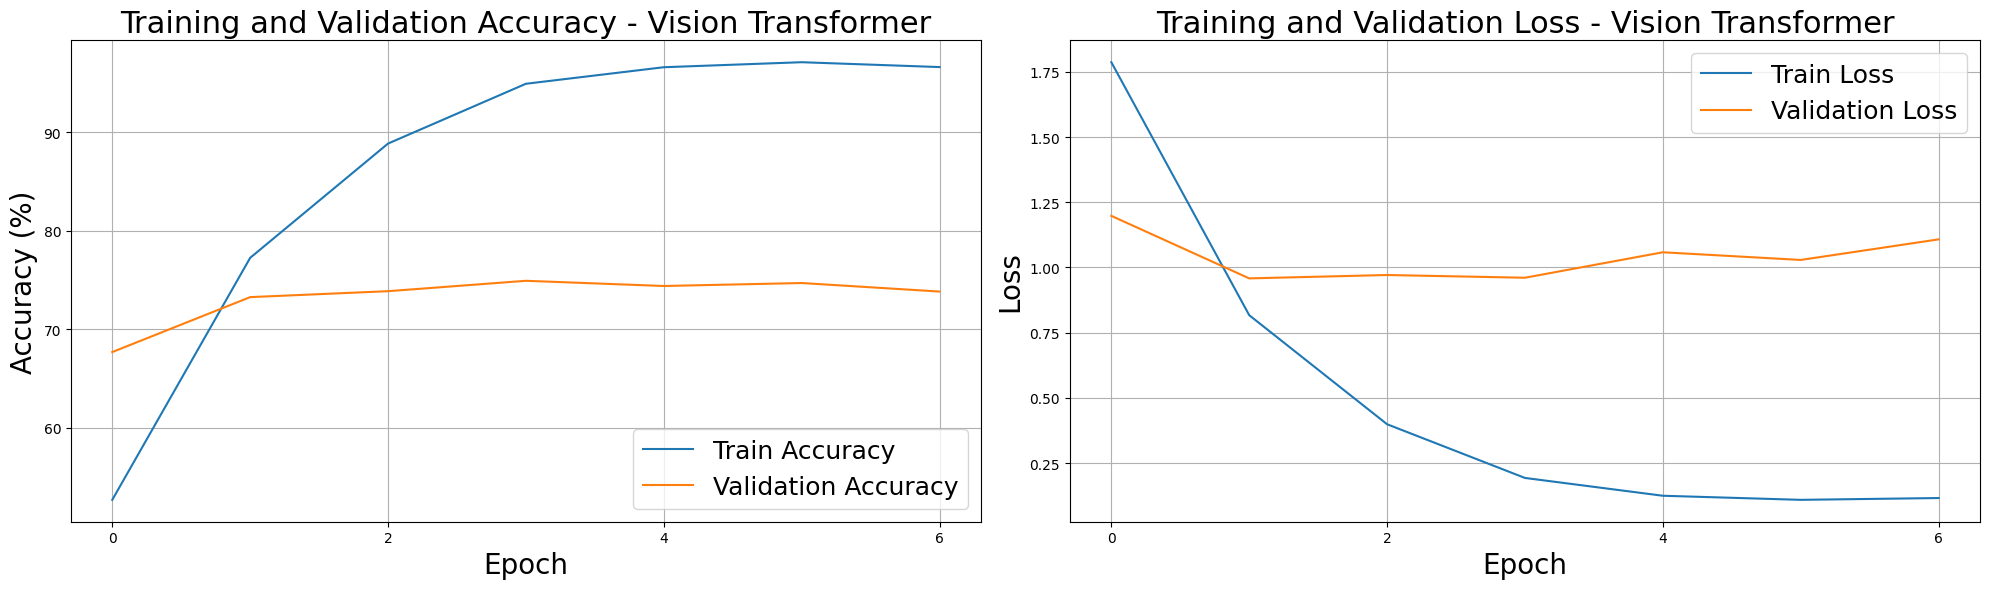

In [32]:
# =========================
# Plot Training Curves
# =========================
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
num_epochs_done = len(train_losses)
xticks = range(0, num_epochs_done + 1, 2)

# Accuracy
axs[0].plot(train_accuracies, label='Train Accuracy')
axs[0].plot(val_accuracies, label='Validation Accuracy')
axs[0].set_xlabel('Epoch', fontsize=20)
axs[0].set_ylabel('Accuracy (%)', fontsize=20)
axs[0].set_title('Training and Validation Accuracy - Vision Transformer', fontsize=22)
axs[0].legend(fontsize=18)
axs[0].set_xticks(xticks)
axs[0].grid(True)

# Loss
axs[1].plot(train_losses, label='Train Loss')
axs[1].plot(val_losses, label='Validation Loss')
axs[1].set_xlabel('Epoch', fontsize=20)
axs[1].set_ylabel('Loss', fontsize=20)
axs[1].set_title('Training and Validation Loss - Vision Transformer', fontsize=22)
axs[1].legend(fontsize=18)
axs[1].set_xticks(xticks)
axs[1].grid(True)

plt.tight_layout()
plt.savefig('vitTorch_training_curves.png', dpi=600)
plt.savefig('vitTorch_training_curves.pdf')
plt.show()

In [33]:
# =========================
# Test Evaluation
# =========================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Performance Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
mcc = matthews_corrcoef(y_true, y_pred)

print("\n===== 📊 Test Performance =====")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")

# Save Performance Metrics
metrics_df = pd.DataFrame([{
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "MCC": mcc
}])
metrics_df.to_csv("vitTorch_test_metrics.csv", index=False)
print("📁 Test metrics saved to vitTorch_test_metrics.csv")


Testing:   0%|          | 0/84 [00:00<?, ?it/s]


Testing:   1%|          | 1/84 [00:02<02:52,  2.08s/it]


Testing:   2%|▏         | 2/84 [00:02<01:27,  1.06s/it]


Testing:   4%|▎         | 3/84 [00:02<00:59,  1.35it/s]


Testing:   5%|▍         | 4/84 [00:03<00:46,  1.71it/s]


Testing:   6%|▌         | 5/84 [00:03<00:48,  1.62it/s]


Testing:   7%|▋         | 6/84 [00:04<00:41,  1.90it/s]


Testing:   8%|▊         | 7/84 [00:05<00:55,  1.40it/s]


Testing:  10%|▉         | 8/84 [00:05<00:45,  1.67it/s]


Testing:  11%|█         | 9/84 [00:05<00:39,  1.92it/s]


Testing:  12%|█▏        | 10/84 [00:06<00:34,  2.13it/s]


Testing:  13%|█▎        | 11/84 [00:07<00:40,  1.78it/s]


Testing:  14%|█▍        | 12/84 [00:07<00:35,  2.02it/s]


Testing:  15%|█▌        | 13/84 [00:07<00:36,  1.94it/s]


Testing:  17%|█▋        | 14/84 [00:08<00:32,  2.15it/s]


Testing:  18%|█▊        | 15/84 [00:08<00:35,  1.97it/s]


Testing:  19%|█▉        | 16/84 [00:09<00:31,  2.13it/s]


Testing:  20%|██        | 17/84 [00:09<00:29,  2.30it/s]


Testing:  21%|██▏       | 18/84 [00:10<00:27,  2.44it/s]


Testing:  23%|██▎       | 19/84 [00:10<00:33,  1.93it/s]


Testing:  24%|██▍       | 20/84 [00:11<00:30,  2.13it/s]


Testing:  25%|██▌       | 21/84 [00:11<00:30,  2.04it/s]


Testing:  26%|██▌       | 22/84 [00:12<00:27,  2.23it/s]


Testing:  27%|██▋       | 23/84 [00:12<00:27,  2.20it/s]


Testing:  29%|██▊       | 24/84 [00:12<00:25,  2.36it/s]


Testing:  30%|██▉       | 25/84 [00:13<00:23,  2.49it/s]


Testing:  31%|███       | 26/84 [00:13<00:22,  2.59it/s]


Testing:  32%|███▏      | 27/84 [00:13<00:21,  2.66it/s]


Testing:  33%|███▎      | 28/84 [00:14<00:23,  2.39it/s]


Testing:  35%|███▍      | 29/84 [00:14<00:22,  2.46it/s]


Testing:  36%|███▌      | 30/84 [00:15<00:23,  2.26it/s]


Testing:  37%|███▋      | 31/84 [00:15<00:21,  2.41it/s]


Testing:  38%|███▊      | 32/84 [00:16<00:33,  1.55it/s]


Testing:  39%|███▉      | 33/84 [00:17<00:28,  1.80it/s]


Testing:  40%|████      | 34/84 [00:17<00:24,  2.02it/s]


Testing:  42%|████▏     | 35/84 [00:17<00:22,  2.21it/s]


Testing:  43%|████▎     | 36/84 [00:18<00:20,  2.38it/s]


Testing:  44%|████▍     | 37/84 [00:18<00:18,  2.49it/s]


Testing:  45%|████▌     | 38/84 [00:18<00:17,  2.59it/s]


Testing:  46%|████▋     | 39/84 [00:19<00:17,  2.59it/s]


Testing:  48%|████▊     | 40/84 [00:19<00:16,  2.67it/s]


Testing:  49%|████▉     | 41/84 [00:20<00:16,  2.63it/s]


Testing:  50%|█████     | 42/84 [00:20<00:15,  2.69it/s]


Testing:  51%|█████     | 43/84 [00:20<00:14,  2.73it/s]


Testing:  52%|█████▏    | 44/84 [00:21<00:14,  2.77it/s]


Testing:  54%|█████▎    | 45/84 [00:21<00:13,  2.80it/s]


Testing:  55%|█████▍    | 46/84 [00:21<00:14,  2.68it/s]


Testing:  56%|█████▌    | 47/84 [00:22<00:17,  2.14it/s]


Testing:  57%|█████▋    | 48/84 [00:22<00:15,  2.31it/s]


Testing:  58%|█████▊    | 49/84 [00:23<00:20,  1.70it/s]


Testing:  60%|█████▉    | 50/84 [00:24<00:17,  1.94it/s]


Testing:  61%|██████    | 51/84 [00:25<00:24,  1.35it/s]


Testing:  62%|██████▏   | 52/84 [00:25<00:20,  1.60it/s]


Testing:  63%|██████▎   | 53/84 [00:26<00:19,  1.57it/s]


Testing:  64%|██████▍   | 54/84 [00:26<00:16,  1.82it/s]


Testing:  65%|██████▌   | 55/84 [00:27<00:14,  2.04it/s]


Testing:  67%|██████▋   | 56/84 [00:27<00:12,  2.23it/s]


Testing:  68%|██████▊   | 57/84 [00:27<00:11,  2.39it/s]


Testing:  69%|██████▉   | 58/84 [00:28<00:10,  2.51it/s]


Testing:  70%|███████   | 59/84 [00:28<00:12,  2.08it/s]


Testing:  71%|███████▏  | 60/84 [00:29<00:10,  2.26it/s]


Testing:  73%|███████▎  | 61/84 [00:29<00:10,  2.14it/s]


Testing:  74%|███████▍  | 62/84 [00:30<00:09,  2.31it/s]


Testing:  75%|███████▌  | 63/84 [00:30<00:10,  2.03it/s]


Testing:  76%|███████▌  | 64/84 [00:31<00:08,  2.23it/s]


Testing:  77%|███████▋  | 65/84 [00:31<00:09,  2.03it/s]


Testing:  79%|███████▊  | 66/84 [00:32<00:08,  2.22it/s]


Testing:  80%|███████▉  | 67/84 [00:32<00:07,  2.16it/s]


Testing:  81%|████████  | 68/84 [00:32<00:06,  2.33it/s]


Testing:  82%|████████▏ | 69/84 [00:33<00:07,  2.10it/s]


Testing:  83%|████████▎ | 70/84 [00:33<00:06,  2.27it/s]


Testing:  85%|████████▍ | 71/84 [00:34<00:06,  2.08it/s]


Testing:  86%|████████▌ | 72/84 [00:34<00:05,  2.26it/s]


Testing:  87%|████████▋ | 73/84 [00:35<00:04,  2.41it/s]


Testing:  88%|████████▊ | 74/84 [00:35<00:03,  2.53it/s]


Testing:  89%|████████▉ | 75/84 [00:35<00:03,  2.62it/s]


Testing:  90%|█████████ | 76/84 [00:36<00:02,  2.68it/s]


Testing:  92%|█████████▏| 77/84 [00:36<00:02,  2.73it/s]


Testing:  93%|█████████▎| 78/84 [00:36<00:02,  2.77it/s]


Testing:  94%|█████████▍| 79/84 [00:37<00:01,  2.79it/s]


Testing:  95%|█████████▌| 80/84 [00:37<00:01,  2.81it/s]


Testing:  96%|█████████▋| 81/84 [00:38<00:01,  2.81it/s]


Testing:  98%|█████████▊| 82/84 [00:38<00:00,  2.68it/s]


Testing:  99%|█████████▉| 83/84 [00:39<00:00,  2.14it/s]


Testing: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]


===== 📊 Test Performance =====
Accuracy:  0.7340
Precision: 0.7525
Recall:    0.7340
F1-Score:  0.7280
MCC:       0.7231
📁 Test metrics saved to vitTorch_test_metrics.csv


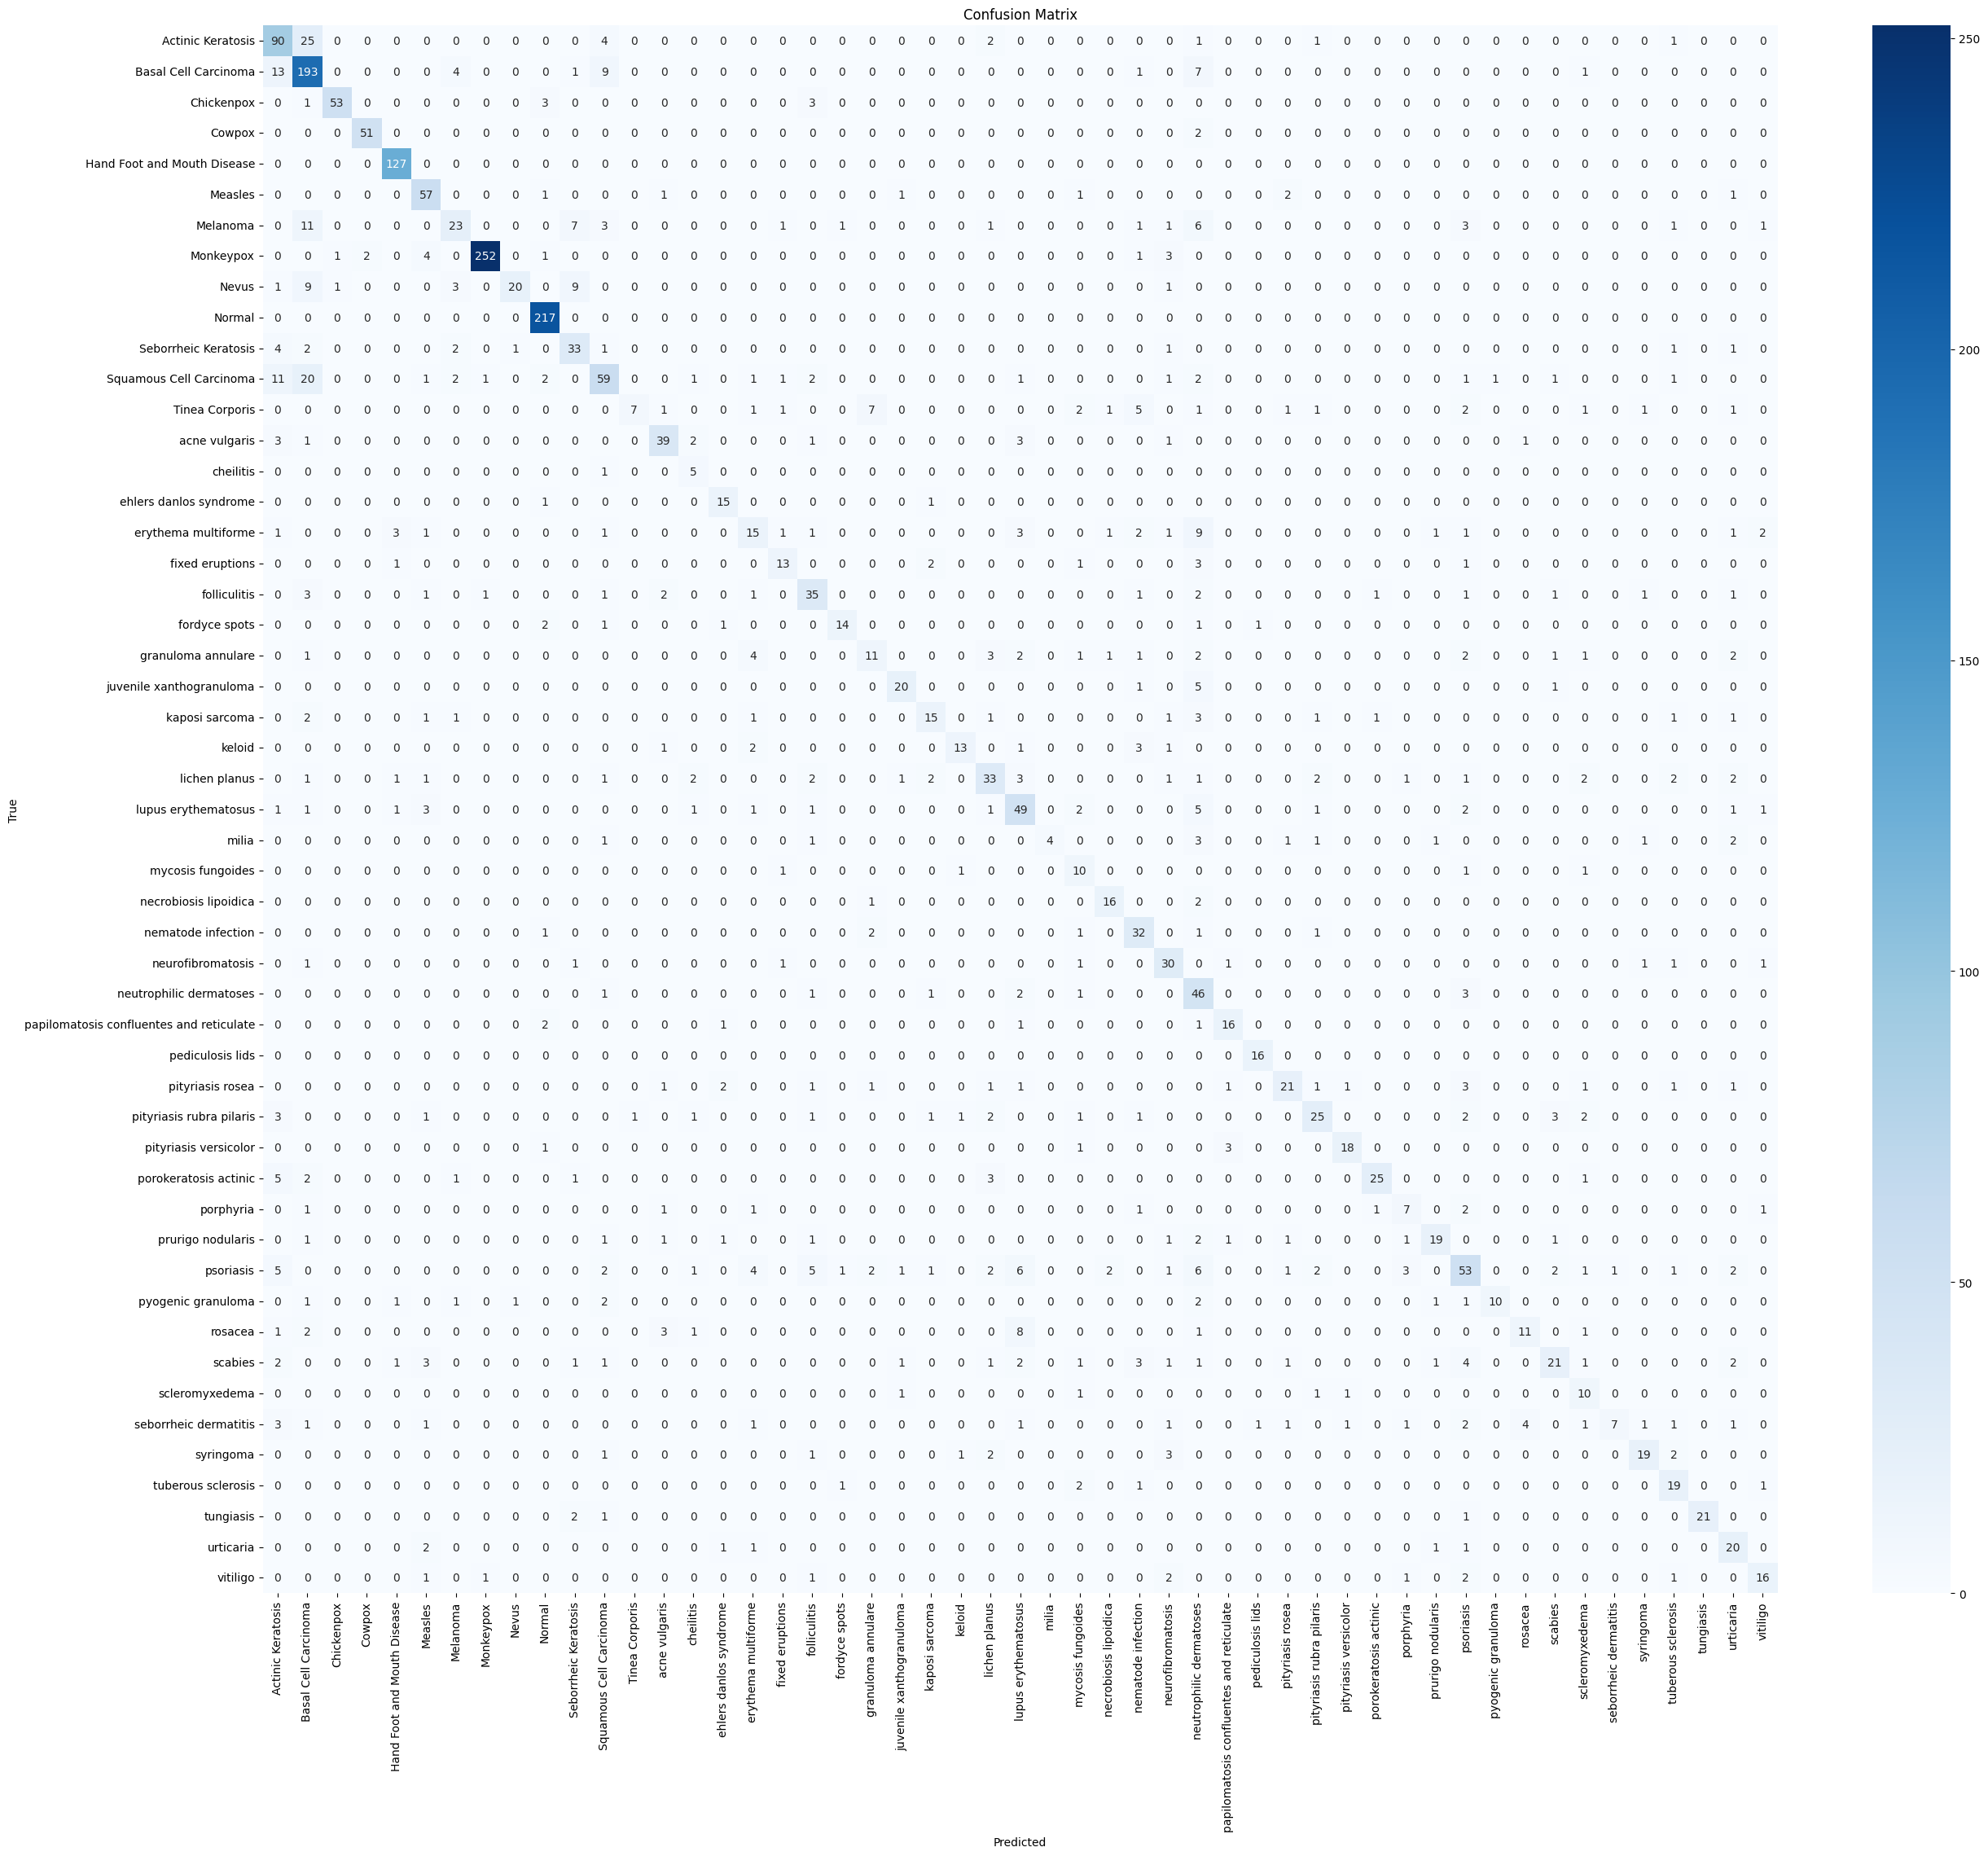

                                          precision    recall  f1-score   support

                       Actinic Keratosis       0.63      0.73      0.67       124
                    Basal Cell Carcinoma       0.69      0.84      0.76       229
                              Chickenpox       0.96      0.88      0.92        60
                                  Cowpox       0.96      0.96      0.96        53
             Hand Foot and Mouth Disease       0.94      1.00      0.97       127
                                 Measles       0.74      0.89      0.81        64
                                Melanoma       0.62      0.38      0.47        60
                               Monkeypox       0.99      0.95      0.97       264
                                   Nevus       0.91      0.45      0.61        44
                                  Normal       0.94      1.00      0.97       217
                    Seborrheic Keratosis       0.60      0.72      0.65        46
               

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate on test set
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(30, 25))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('vitTorch_confusion_matrix.png', dpi=600)
plt.savefig('vitTorch_confusion_matrix.pdf')
plt.show()

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm.to_csv("confusion_vitTorch.csv")

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


<h1><b>Zipping all files</b></h1>

In [ ]:
!zip -r /kaggle/working/output_files_swin_vit.zip /kaggle/working/*